<a href="https://colab.research.google.com/github/ahmedengu/feature_importance/blob/master/Stocks/Finland/Neste/Neste_1D_Close.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from IPython.display import clear_output
import pandas as pd

if pd.__version__ != '0.25.0' or False:
  # install
  !apt-get install default-jre build-essential swig
  !pip  install h2o==3.24.0.5 yfinance==0.1.43
  !pip  install git+https://github.com/ahmedengu/findatapy.git pandas==0.25.0
  clear_output(wait=True)

  !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
  !tar -xzvf ta-lib-0.4.0-src.tar.gz
  %cd ta-lib
  !./configure --prefix=/usr
  clear_output(wait=True)
  !make
  clear_output(wait=True)
  !make install
  clear_output(wait=True)
  !pip install Ta-Lib==0.4.17
  clear_output(wait=True)
  print('RESTARTING')
  %cd /content
  
  # force restart
  import os
  os.kill(os.getpid(), 9)

In [0]:
# Experiment Config
import pandas as pd
from IPython.display import display
from IPython.core.debugger import set_trace

data_ticker = "NESTE.HE"
data_resample = '1D'
data_label = 'Close'
data_label_name = 'y'
start_date = '1 Jan 2009'
finish_date = '1 Jan 2019'
is_duka = False
is_yahoo = True
kaggle_file = 'bitstamp' # default None
kaggle_folder = '1 Day/Stocks'

models_summary = {}
for metric in ['accuracy','F1','auc','logloss','mean_per_class_error','rmse','mse']:
  models_summary.update({metric:pd.DataFrame()})

# feature elimination config
model_selected_features = 50
PCA_k = 50
HCF_threshold = 0.90
LVF_threshold = 0.1
GLRM_k = 20
select_k = 50
select_percentile = 10
select_alpha = 0.1
select_rfe = 50

features_to_include = ['All', 'DLF', 'XGBF', 'RFE', 'Fwe'] # True for all , ['All','Fwe','RFE','Percentile','KBest','LVF','HCF','PCA','XGBF','GLMF','DLF','GLRM'] 
is_EDA = True
max_models_num = 10

# pandas options
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
# random seed
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)
import pandas as pd
import gc
import os

resample_how= {'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last',
                             'Volume': 'sum', 'Date': 'first'}

if is_duka:
  from findatapy.util import DataConstants

  DataConstants.market_thread_no.update({'dukascopy': 64})

  # Download dataset
  from findatapy.market import Market, MarketDataRequest, MarketDataGenerator

  market = Market(market_data_generator=MarketDataGenerator(log_every_day=30))

  md_request = MarketDataRequest(start_date=start_date, finish_date=finish_date,
                                       fields=['temp', 'ask', 'bid', 'askv', 'bidv'], vendor_fields=['temp', 'ask', 'bid', 'askv', 'bidv'],
                                       freq='tick', data_source='dukascopy',
                                       tickers=[data_ticker], vendor_tickers=[data_ticker])

  temp_dataset = market.fetch_market(md_request)
  full_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bid'].resample(data_resample).ohlc())
  full_dataset.columns = ['Open', 'High', 'Low', 'Close']
  temp_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bidv'].resample(data_resample).sum())
  temp_dataset.columns = ['Volume']
  full_dataset['Volume'] = temp_dataset['Volume']

  del temp_dataset, md_request, market, DataConstants, Market, MarketDataRequest, MarketDataGenerator

  gc.collect()

elif is_yahoo:
  import yfinance as yf
  from datetime import datetime

  full_dataset = yf.download(data_ticker, start=str(datetime.strptime(start_date, '%d %b %Y')).split(' ')[0], end=str(datetime.strptime(finish_date, '%d %b %Y')).split(' ')[0])
  full_dataset['Date']=full_dataset.index
  del yf,datetime

elif data_ticker == 'EURUSD':
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2014.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2015.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2016.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2017.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2018.zip
  !unzip -qq -o \*.zip
  full_dataset = pd.read_csv('DAT_ASCII_EURUSD_M1_2014.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';')
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2015.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2016.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2017.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2018.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset['Date'] = pd.to_datetime(full_dataset['Date'])
  full_dataset.index = full_dataset['Date']
  full_dataset = full_dataset.dropna()
  full_dataset = full_dataset.sort_index()
  full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]


    
elif data_ticker == 'APPLUSUSD':
  full_dataset=pd.read_csv('https://github.com/kyleconroy/apple-stock/raw/master/apple_stock_data.csv',index_col =0,parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > '2007-04-01']


elif data_ticker == 'COMI':
  full_dataset=pd.read_csv('https://static.mubasher.info/File.MubasherCharts/File.Historical_Stock_Charts_Dir/44507230b2b03e2da37352abf1a659545b44.csv',index_col =0,names =['Open', 'High', 'Low', 'Close','Volume'],parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Volume'] = full_dataset['Volume'] * full_dataset['Close'] 
  full_dataset = full_dataset.drop_duplicates()
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]
  
elif kaggle_file is not None:
  if not os.path.isfile('kaggle.json'):
    from google.colab import files
    files.upload()
    
    import time
    time.sleep(10)
    !ls
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !ls ~/.kaggle

    !chmod 600 /root/.kaggle/kaggle.json
    del files
    
  !kaggle datasets download $data_ticker
  !unzip -qq -o \*.zip
  !unzip -qq -o \*.zip

  if data_ticker == 'mczielinski/bitcoin-historical-data':
    
    full_dataset = pd.read_csv([file for file in os.listdir() if kaggle_file in file][0])
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Volume_(Currency)','Weighted_Price']
    full_dataset.index=pd.to_datetime(full_dataset['Date'], unit='s')

    resample_how.update({'Volume_(Currency)': 'sum', 'Weighted_Price': 'last'})

    full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()[1:-1]
    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]
  
  elif data_ticker == 'borismarjanovic/daily-and-intraday-stock-price-data':
    
    full_dataset = pd.read_csv(kaggle_folder + '/' + [file for file in os.listdir(kaggle_folder) if kaggle_file in file][0])
    if 'Time' in full_dataset.columns:
      full_dataset['Date'] = pd.to_datetime(full_dataset['Date'] + ' ' + full_dataset['Time'])
      full_dataset = full_dataset.drop('Time',axis=1)
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']
    full_dataset.index=pd.to_datetime(full_dataset['Date'])

    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]

  
gc.collect()
full_dataset = full_dataset.dropna()

full_dataset = full_dataset.drop('Date',axis=1, errors='ignore')
full_dataset = full_dataset.sort_index()
full_dataset = full_dataset[-100000:]
display(full_dataset)
display(full_dataset.describe())
full_dataset.to_pickle('full_dataset')
del full_dataset, set_random_seed, seed
gc.collect()

[*********************100%***********************]  1 of 1 downloaded


Open   High    Low  Close  Adj Close   Volume
Date                                                      
2009-01-02   3.57   3.70   3.57   3.70       1.19  1121418
2009-01-05   3.79   3.91   3.76   3.87       1.25  3431010
2009-01-07   3.97   4.00   3.85   3.85       1.24  3105822
2009-01-08   3.82   3.88   3.77   3.86       1.24  1905417
2009-01-09   3.89   3.91   3.70   3.71       1.19  3559104
...           ...    ...    ...    ...        ...      ...
2018-12-19  23.33  23.77  23.16  23.57      23.30  1049256
2018-12-20  23.21  23.35  22.59  22.59      22.33  1143492
2018-12-21  22.60  22.63  22.03  22.36      22.10  1783161
2018-12-27  22.50  22.77  22.15  22.24      21.98  1183863
2018-12-28  22.43  22.48  22.00  22.45      22.19   793566

[2512 rows x 6 columns]

Open         High          Low        Close    Adj Close        Volume
count  2512.000000  2512.000000  2512.000000  2512.000000  2512.000000  2.512000e+03
mean      7.702719     7.798694     7.612174     7.706919     5.884490  2.633797e+06
std       5.825237     5.895338     5.771711     5.833837     6.069698  1.610000e+06
min       2.100000     2.140000     2.050000     2.060000     0.940000  0.000000e+00
25%       3.700000     3.740000     3.650000     3.690000     1.680000  1.664950e+06
50%       4.870000     4.910000     4.815000     4.860000     3.000000  2.279858e+06
75%      10.385000    10.507500    10.215000    10.397500     8.485000  3.126622e+06
max      25.410000    25.510000    25.130000    25.370000    24.210000  2.023456e+07

7

In [4]:
# OHLC EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('full_dataset')))
  del pp

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


In [5]:
# features
from talib._ta_lib import *
import talib
import numpy as np
import uuid
import os


features_dataset = pd.read_pickle('full_dataset').sort_index()


periods = np.resize([2, 3, 3, 2], len(features_dataset['Close'])).astype(float)
timeperiods = [8, 12, 14, 20, 24, 30]
matypes = range(9)
nbdevs = [2, 3, 4, 5]

# date features
features_dataset['day'] = features_dataset.index.day
features_dataset['dayofweek'] = features_dataset.index.dayofweek
features_dataset['dayofyear'] = features_dataset.index.dayofyear
features_dataset['days_in_month'] = features_dataset.index.days_in_month
features_dataset['hour'] = features_dataset.index.hour
features_dataset['is_month_end'] = pd.factorize(features_dataset.index.is_month_end)[0]
features_dataset['is_month_start'] = pd.factorize(features_dataset.index.is_month_start)[0]
features_dataset['is_quarter_end'] = pd.factorize(features_dataset.index.is_quarter_end)[0]
features_dataset['is_quarter_start'] = pd.factorize(features_dataset.index.is_quarter_start)[0]
features_dataset['minute'] = features_dataset.index.minute
features_dataset['month'] = features_dataset.index.month
features_dataset['quarter'] = features_dataset.index.quarter
features_dataset['second'] = features_dataset.index.second
features_dataset['week'] = features_dataset.index.week
features_dataset['weekday'] = features_dataset.index.weekday
features_dataset['weekday_name'] = pd.factorize(features_dataset.index.weekday_name)[0]
features_dataset['weekofyear'] = features_dataset.index.weekofyear

# Overlap Studies
features_dataset['HT_TRENDLINE'] = HT_TRENDLINE(features_dataset['Close'])
features_dataset['mama'], features_dataset['fama'] = MAMA(features_dataset['Close'])
features_dataset['SAREXT'] = SAREXT(features_dataset['High'], features_dataset['Low'], startvalue=-4e37,
                                    offsetonreverse=-4e37, accelerationinitlong=-4e37,
                                    accelerationlong=-4e37, accelerationmaxlong=-4e37, accelerationinitshort=-4e37,
                                    accelerationshort=-4e37, accelerationmaxshort=-4e37)

for timeperiod in timeperiods:
    features_dataset['DEMA_' + str(timeperiod)] = DEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['EMA_' + str(timeperiod)] = EMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['KAMA_' + str(timeperiod)] = KAMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPOINT_' + str(timeperiod)] = MIDPOINT(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPRICE_' + str(timeperiod)] = MIDPRICE(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['SAR_' + str(timeperiod / 100)] = SAR(features_dataset['High'], features_dataset['Low'],
                                                           acceleration=timeperiod / 100,
                                                           maximum=timeperiod / 100)
    features_dataset['SMA_' + str(timeperiod)] = SMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TEMA_' + str(timeperiod)] = TEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIMA_' + str(timeperiod)] = TRIMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WMA_' + str(timeperiod)] = WMA(features_dataset['Close'], timeperiod=timeperiod)

    for matype in matypes:
        features_dataset['MA_' + str(timeperiod) + '_' + str(matype)] = MA(features_dataset['Close'],
                                                                           timeperiod=timeperiod, matype=matype)
        features_dataset['MAVP_' + str(timeperiod) + '_' + str(matype)] = MAVP(features_dataset['Close'], periods,
                                                                               minperiod=2,
                                                                               maxperiod=timeperiod, matype=matype)
        features_dataset['T3_' + str(timeperiod) + '_' + str(matype)] = T3(features_dataset['Close'],
                                                                           timeperiod=timeperiod,
                                                                           vfactor=matype / 10)

        for nbdev in nbdevs:
            features_dataset['BBANDS_upperband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_middleband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_lowerband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)] = BBANDS(
                features_dataset['Close'], timeperiod=timeperiod, nbdevup=nbdev, nbdevdn=nbdev, matype=matype)

            
gc.collect()
# Momentum Indicators
features_dataset['BOP'] = BOP(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                              features_dataset['Close'])

for timeperiod in timeperiods:
    features_dataset['ADX_' + str(timeperiod)] = ADX(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ADXR_' + str(timeperiod)] = ADXR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['aroondown_' + str(timeperiod)], features_dataset['aroonup_' + str(timeperiod)] = AROON(
        features_dataset['High'],
        features_dataset['Low'],
        timeperiod=timeperiod)
    features_dataset['AROONOSC_' + str(timeperiod)] = AROONOSC(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['CCI_' + str(timeperiod)] = CCI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['CMO_' + str(timeperiod)] = CMO(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['DX_' + str(timeperiod)] = DX(features_dataset['High'], features_dataset['Low'],
                                                   features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MACDFIX_' + str(timeperiod)], features_dataset['MACDFIX_signal_' + str(timeperiod)], features_dataset[
        'MACDFIX_hist_' + str(timeperiod)] = MACDFIX(features_dataset['Close'], signalperiod=timeperiod)
    features_dataset['MFI_' + str(timeperiod)] = MFI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], features_dataset['Volume'],
                                                     timeperiod=timeperiod)
    features_dataset['MINUS_DI_' + str(timeperiod)] = MINUS_DI(features_dataset['High'], features_dataset['Low'],
                                                               features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINUS_DM_' + str(timeperiod)] = MINUS_DM(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['MOM_' + str(timeperiod)] = MOM(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DI_' + str(timeperiod)] = PLUS_DI(features_dataset['High'], features_dataset['Low'],
                                                             features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DM_' + str(timeperiod)] = PLUS_DM(features_dataset['High'], features_dataset['Low'],
                                                             timeperiod=timeperiod)
    features_dataset['ROC_' + str(timeperiod)] = ROC(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCP_' + str(timeperiod)] = ROCP(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR_' + str(timeperiod)] = ROCR(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR100_' + str(timeperiod)] = ROCR100(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['RSI_' + str(timeperiod)] = RSI(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIX_' + str(timeperiod)] = TRIX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WILLR_' + str(timeperiod)] = WILLR(features_dataset['High'], features_dataset['Low'],
                                                         features_dataset['Close'], timeperiod=timeperiod)

    
gc.collect()
features_dataset['APO'] = APO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['MACD'], features_dataset['MACD_signal'], features_dataset['MACD_hist'] = MACD(
    features_dataset['Close'], fastperiod=12,
    slowperiod=26,
    signalperiod=9)
features_dataset['MACDEXT'], features_dataset['MACDEXT_signal'], features_dataset['MACDEXT_hist'] = MACDEXT(
    features_dataset['Close'],
    fastperiod=12,
    fastmatype=0,
    slowperiod=26,
    slowmatype=0,
    signalperiod=9,
    signalmatype=0)

features_dataset['PPO'] = PPO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['STOCH_slowk'], features_dataset['STOCH_slowd'] = STOCH(features_dataset['High'],
                                                                         features_dataset['Low'],
                                                                         features_dataset['Close'], fastk_period=5,
                                                                         slowk_period=3, slowk_matype=0,
                                                                         slowd_period=3, slowd_matype=0)
features_dataset['STOCHF_fastk'], features_dataset['STOCHF_fastd'] = STOCHF(features_dataset['High'],
                                                                            features_dataset['Low'],
                                                                            features_dataset['Close'], fastk_period=5,
                                                                            fastd_period=3, fastd_matype=0)
features_dataset['STOCHRSI_fastk'], features_dataset['STOCHRSI_fastd'] = STOCHRSI(features_dataset['Close'],
                                                                                  timeperiod=14,
                                                                                  fastk_period=5, fastd_period=3,
                                                                                  fastd_matype=0)
features_dataset['ULTOSC'] = ULTOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                    timeperiod1=7, timeperiod2=14, timeperiod3=28)

# Volume Indicators
features_dataset['AD'] = AD(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                            features_dataset['Volume'])
features_dataset['ADOSC'] = ADOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                  features_dataset['Volume'], fastperiod=3, slowperiod=10)
features_dataset['OBV'] = OBV(features_dataset['Close'], features_dataset['Volume'])

gc.collect()
# Volatility Indicators
for timeperiod in timeperiods:
    features_dataset['ATR_' + str(timeperiod)] = ATR(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['NATR_' + str(timeperiod)] = NATR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)

features_dataset['TRANGE'] = TRANGE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

# Price Transform
features_dataset['AVGPRICE'] = AVGPRICE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                        features_dataset['Close'])
features_dataset['MEDPRICE'] = MEDPRICE(features_dataset['High'], features_dataset['Low'])
features_dataset['TYPPRICE'] = TYPPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])
features_dataset['WCLPRICE'] = WCLPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

gc.collect()
# Cycle Indicators
features_dataset['HT_DCPERIOD'] = HT_DCPERIOD(features_dataset['Close'])
features_dataset['HT_DCPHASE'] = HT_DCPHASE(features_dataset['Close'])
features_dataset['HT_PHASOR_inphase'], features_dataset['HT_PHASOR_quadrature'] = HT_PHASOR(features_dataset['Close'])
features_dataset['HT_SINE_sine'], features_dataset['HT_SINE_leadsine'] = HT_SINE(features_dataset['Close'])
features_dataset['HT_TRENDMODE'] = HT_TRENDMODE(features_dataset['Close'])

# Pattern Recognition
features_dataset['CDL2CROWS'] = CDL2CROWS(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDL3BLACKCROWS'] = CDL3BLACKCROWS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3INSIDE'] = CDL3INSIDE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDL3LINESTRIKE'] = CDL3LINESTRIKE(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3OUTSIDE'] = CDL3OUTSIDE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3STARSINSOUTH'] = CDL3STARSINSOUTH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3WHITESOLDIERS'] = CDL3WHITESOLDIERS(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLABANDONEDBABY'] = CDLABANDONEDBABY(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'],
                                                        penetration=0)
features_dataset['CDLADVANCEBLOCK'] = CDLADVANCEBLOCK(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBELTHOLD'] = CDLBELTHOLD(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBREAKAWAY'] = CDLBREAKAWAY(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCLOSINGMARUBOZU'] = CDLCLOSINGMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCONCEALBABYSWALL'] = CDLCONCEALBABYSWALL(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCOUNTERATTACK'] = CDLCOUNTERATTACK(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDARKCLOUDCOVER'] = CDLDARKCLOUDCOVER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'],
                                                          penetration=0)
features_dataset['CDLDOJI'] = CDLDOJI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                      features_dataset['Close'])
features_dataset['CDLDOJISTAR'] = CDLDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDRAGONFLYDOJI'] = CDLDRAGONFLYDOJI(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLENGULFING'] = CDLENGULFING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLEVENINGDOJISTAR'] = CDLEVENINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLEVENINGSTAR'] = CDLEVENINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLGAPSIDESIDEWHITE'] = CDLGAPSIDESIDEWHITE(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLGRAVESTONEDOJI'] = CDLGRAVESTONEDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHAMMER'] = CDLHAMMER(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHANGINGMAN'] = CDLHANGINGMAN(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHARAMI'] = CDLHARAMI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHARAMICROSS'] = CDLHARAMICROSS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIGHWAVE'] = CDLHIGHWAVE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIKKAKE'] = CDLHIKKAKE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLHIKKAKEMOD'] = CDLHIKKAKEMOD(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHOMINGPIGEON'] = CDLHOMINGPIGEON(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLIDENTICAL3CROWS'] = CDLIDENTICAL3CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLINNECK'] = CDLINNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLINVERTEDHAMMER'] = CDLINVERTEDHAMMER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLKICKING'] = CDLKICKING(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLKICKINGBYLENGTH'] = CDLKICKINGBYLENGTH(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLADDERBOTTOM'] = CDLLADDERBOTTOM(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLEGGEDDOJI'] = CDLLONGLEGGEDDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLINE'] = CDLLONGLINE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMARUBOZU'] = CDLMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATCHINGLOW'] = CDLMATCHINGLOW(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATHOLD'] = CDLMATHOLD(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'], penetration=0)
features_dataset['CDLMORNINGDOJISTAR'] = CDLMORNINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLMORNINGSTAR'] = CDLMORNINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLONNECK'] = CDLONNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLPIERCING'] = CDLPIERCING(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRICKSHAWMAN'] = CDLRICKSHAWMAN(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRISEFALL3METHODS'] = CDLRISEFALL3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSEPARATINGLINES'] = CDLSEPARATINGLINES(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHOOTINGSTAR'] = CDLSHOOTINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHORTLINE'] = CDLSHORTLINE(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSPINNINGTOP'] = CDLSPINNINGTOP(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTALLEDPATTERN'] = CDLSTALLEDPATTERN(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTICKSANDWICH'] = CDLSTICKSANDWICH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTAKURI'] = CDLTAKURI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLTASUKIGAP'] = CDLTASUKIGAP(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTHRUSTING'] = CDLTHRUSTING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUNIQUE3RIVER'] = CDLUNIQUE3RIVER(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUPSIDEGAP2CROWS'] = CDLUPSIDEGAP2CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLXSIDEGAP3METHODS'] = CDLXSIDEGAP3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
gc.collect()

# Statistic Functions
for timeperiod in timeperiods:
    features_dataset['BETA_' + str(timeperiod)] = BETA(features_dataset['High'], features_dataset['Low'],
                                                       timeperiod=timeperiod)
    features_dataset['CORREL_' + str(timeperiod)] = CORREL(features_dataset['High'], features_dataset['Low'],
                                                           timeperiod=timeperiod)
    features_dataset['LINEARREG_' + str(timeperiod)] = LINEARREG(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['LINEARREG_ANGLE_' + str(timeperiod)] = LINEARREG_ANGLE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['LINEARREG_INTERCEPT_' + str(timeperiod)] = LINEARREG_INTERCEPT(features_dataset['Close'],
                                                                                     timeperiod=timeperiod)
    features_dataset['LINEARREG_SLOPE_' + str(timeperiod)] = LINEARREG_SLOPE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['STDDEV_' + str(timeperiod)] = STDDEV(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)
    features_dataset['TSF_' + str(timeperiod)] = TSF(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['VAR_' + str(timeperiod)] = VAR(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)

    
gc.collect()
# Math Transform
features_dataset['ACOS'] = ACOS(features_dataset['Close'])
features_dataset['ASIN'] = ASIN(features_dataset['Close'])
features_dataset['ATAN'] = ATAN(features_dataset['Close'])
features_dataset['CEIL'] = CEIL(features_dataset['Close'])
features_dataset['COS'] = COS(features_dataset['Close'])
features_dataset['COSH'] = COSH(features_dataset['Close'])
features_dataset['EXP'] = EXP(features_dataset['Close'])
features_dataset['FLOOR'] = FLOOR(features_dataset['Close'])
features_dataset['LN'] = LN(features_dataset['Close'])
features_dataset['LOG10'] = LOG10(features_dataset['Close'])
features_dataset['SIN'] = SIN(features_dataset['Close'])
features_dataset['SINH'] = SINH(features_dataset['Close'])
features_dataset['SQRT'] = SQRT(features_dataset['Close'])
features_dataset['TAN'] = TAN(features_dataset['Close'])
features_dataset['TANH'] = TANH(features_dataset['Close'])

gc.collect()
# Math Operator
features_dataset['ADD'] = ADD(features_dataset['High'], features_dataset['Low'])
features_dataset['DIV'] = DIV(features_dataset['High'], features_dataset['Low'])
features_dataset['MULT'] = MULT(features_dataset['High'], features_dataset['Low'])
features_dataset['SUB'] = SUB(features_dataset['High'], features_dataset['Low'])

for timeperiod in timeperiods:
    features_dataset['MAX_' + str(timeperiod)] = MAX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIN_' + str(timeperiod)] = MIN(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINMAX_min_' + str(timeperiod)], features_dataset['MINMAX_max_' + str(timeperiod)] = MINMAX(
        features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['SUM_' + str(timeperiod)] = SUM(features_dataset['Close'], timeperiod=timeperiod)
    
gc.collect()


features_dataset = features_dataset.drop(features_dataset.std()[(features_dataset.std() == 0)].index, axis=1)
features_dataset = features_dataset[50:].replace([np.inf, -np.inf], np.nan).dropna(axis=1)
features_dataset.to_pickle('features_dataset')
display(features_dataset)
display(features_dataset.describe())

for name in dir():
  if any( n in name for n in talib.get_functions()):
    del globals()[name]

del periods, timeperiods, matypes, nbdevs, features_dataset, talib
gc.collect()

Open   High    Low  Close  Adj Close   Volume  day  dayofweek  dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear       mama       fama     SAREXT     DEMA_8      EMA_8     KAMA_8  MIDPOINT_8  MIDPRICE_8   SAR_0.08     SMA_8     TEMA_8  TRIMA_8      WMA_8    MA_8_0   MAVP_8_0     T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5     MA_8_1   MAVP_8_1     T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
2009-03-16   2.99   3.06   2.97   3.03       0.98  3219276   16          0         75             31             0               0               0                 0      3        1    12        0             1          12   3.034576   3.227127  -3.184400   2.968556   3.045753   3.098179       3.030       3.050   3.233061   3.01750   2.991844   3.0300   3.016389   3.01750   2.986667   3.223437                3.127386                  3.01750                2.907614                3.182329                  3.01750                2.852671                3.237273                  3.01750                2.797727                3.292216                  3.01750                2.742784   3.045753   3.007808   3.190778                3.155640                 3.045753                2.935867                3.210583                 3.045753                2.880924                3.265526                 3.045753                2.825981                3.320469                 3.045753   
2009-03-17   3.04   3.06   2.99   3.00       0.97  2302839   17          1         76             31             0               0               0                 0      3        1    12        1             4          12   3.032847   3.222270  -3.178912   2.967635   3.035586   3.097439       3.030       3.050   3.207216   3.01500   2.992941   3.0255   3.012500   3.01500   3.015000   3.196792                3.125454                  3.01500                2.904546                3.180680                  3.01500                2.849320                3.235907                  3.01500                2.794093                3.291134                  3.01500                2.738866   3.035586   3.002698   3.165255                3.146039                 3.035586                2.925132                3.201266                 3.035586                2.869905                3.256493                 3.035586                2.814679                3.311720                 3.035586   
2009-03-18   3.04   3.06   2.98   3.02       

Open         High          Low        Close    Adj Close        Volume          day    dayofweek    dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start        month      quarter         week      weekday  weekday_name   weekofyear         mama         fama       SAREXT       DEMA_8        EMA_8       KAMA_8   MIDPOINT_8   MIDPRICE_8     SAR_0.08        SMA_8       TEMA_8      TRIMA_8        WMA_8       MA_8_0     MAVP_8_0       T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5       MA_8_1     MAVP_8_1       T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  \
count  2462.000000  2462.000000  2462.000000  2462.000000  2462.000000  2.462000e+03  2462.000000  2462.000000  2462.000000    2462.000000   2462.000000     2462.000000     2462.000000       2462.000000  2462.000000  2462.000000  2462.000000  2462.000000   2462.000000  2462.000000  2462.000000  2462.000000  2462.000000  2462.000000  2462.000000  2462.000000  2462.000000  2462.000000  2462.000000  2462.000000  2462.000000  2462.000000  2462.000000  2462.000000  2462.000000  2462.000000             2462.000000              2462.000000             2462.000000             2462.000000              2462.000000             2462.000000             2462.000000              2462.000000             2462.000000             2462.000000              2462.000000             2462.000000  2462.000000  2462.000000  2462.000000             2462.000000              2462.000000             2462.000000             2462.000000              2462.000000             2462.000000             2462.000000   
mean      7.787120     7.883960     7.696487     7.791946     5.981007  2.618480e+06    15.774574     1.985378   185.871243      30.457758      0.032088        0.028432        0.008936          0.008123     6.613323     2.539399    27.017872     1.985378      2.016247    27.017872     7.763410     7.699687     0.523001     7.792278     7.763865     7.763115     7.765211     7.764699     7.719717     7.764048     7.792236     7.764167     7.773446     7.764048     7.786049     7.706998                8.054653                 7.764048                7.473442                8.199955                 7.764048                7.328140                8.345258                 7.764048                7.182837                8.490561                 7.764048                7.037534     7.763865     7.785980     7.715506                8.054470                 7.763865                7.473260                8.199773                 7.763865                7.327957                8.345076   
std       5.853492     5.924039     5.799200     5.861754     6.092731  1.610642e+06     8.730045     1.407225   103.153614       0.789793      0.176269        0.166238        0.094125          0.089782     3.382550     1.105503    14.751927     1.407225      1.410668    14.751927     5.841424     5.766242     9.634688     5.864086     5.831588     5.832273     5.833763     5.833845     5.788142     5.833831     5.862984     5.834909     5.842733     5.833831     5.856817     5.773615                6.024514                 5.833831                5.653318                6.123374                 5.833831                5.567186                6.224431                 5.833831                5.483977                6.327580                 5.833831                5.403828     5.831588     5.855486     5.782777                6.022944                 5.831588                5.650361                6.122125                 5.831588                5.563857                6.223494   
min       2.100000     2.140000     2.

36

In [6]:
# features EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('features_dataset')))
  del pp

Output hidden; open in https://colab.research.google.com to view.

In [7]:
# label and scale
import numpy as np
from sklearn.preprocessing import minmax_scale
import os
import pandas as pd

features_dataset = pd.read_pickle('features_dataset')
label_df = features_dataset[[data_label]][:-1]
label_df[data_label_name] = pd.DataFrame(features_dataset[data_label][1:].values / features_dataset[data_label][:-1].values,
                             index=label_df.index).clip(0,1).astype(int)

scaled_df = features_dataset
scaled_df = pd.DataFrame(minmax_scale(scaled_df, axis=0, feature_range=(0, 1)), columns=scaled_df.columns,
                         index=scaled_df.index)
categorical_columns = features_dataset.select_dtypes(exclude=['float64', 'float32', 'float16', 'float_']).columns

scaled_df[categorical_columns] = features_dataset[categorical_columns]
scaled_df = scaled_df[:-1]
scaled_df[data_label_name] = label_df[data_label_name]

display(scaled_df)
scaled_df.to_pickle('scaled_df') 

label_df[-50:].to_pickle('predict_df')
del features_dataset, categorical_columns, scaled_df, label_df, minmax_scale
gc.collect()

Open      High       Low     Close  Adj Close   Volume  day  dayofweek  dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
2009-03-16  0.038181  0.039367  0.039861  0.041613   0.000430  3219276   16          0         75             31             0               0               0                 0      3        1    12        0             1          12  0.034550  0.040771  0.443449  0.036905  0.038215  0.036663    0.038352    0.039168  0.050429  0.037057  0.038336  0.037825  0.037648  0.037057  0.038284  0.043282                0.037114                 0.037057                0.039829                0.036474                 0.037057                0.046202                0.034650                 0.037057                0.055940                0.032975                 0.037057                0.067541  0.038215  0.038295  0.042181                0.037417                 0.038215                0.039865                0.035840                 0.038215                0.048256                0.033966                 0.038215                0.059768                0.032367                 0.038215   
2009-03-17  0.040326  0.039367  0.040728  0.040326   0.000000  2302839   17          1         76             31             0               0               0                 0      3        1    12        1             4          12  0.034473  0.040550  0.443558  0.036866  0.037768  0.036630    0.038352    0.039168  0.049327  0.036948  0.038383  0.037628  0.037478  0.036948  0.039508  0.042095                0.037032                 0.036948                0.039693                0.036407                 0.036948                0.046052                0.034599                 0.036948                0.055778                0.032937                 0.036948                0.067368  0.037768  0.038073  0.041047                0.037007                 0.037768                0.039387                0.035470                 0.037768                0.047766                0.033636                 0.037768                0.059267                0.032071                 0.037768   
2009-03-18  0.040326  0.039367  0.040295  0.041184  

139945

In [8]:
# load data into h2o
import h2o
import pandas as pd
from h2o.automl import H2OAutoML
import uuid
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import gc
import numpy as np

def load_h2o():
  global train_hf, index_splits
  try:
    h2o.cluster().shutdown()
    time.sleep(5)
  except:
    pass

  h2o.init(min_mem_size="9g",nthreads=-1)
  h2o.remove_all()
  train_hf = h2o.H2OFrame(pd.read_pickle('scaled_df'))
  
  gc.collect()
  train_hf[data_label_name] = train_hf[data_label_name].ascharacter().asfactor()
  index_splits = [int(len(train_hf)*0.7),int(len(train_hf)*0.9)]
  gc.collect()


try:
  load_h2o()
except:
  pass

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.4" 2019-07-16; OpenJDK Runtime Environment (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3); OpenJDK 64-Bit Server VM (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpgstpweay
  JVM stdout: /tmp/tmpgstpweay/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpgstpweay/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  ---------------------------------------------------
H2O cluster uptime:         02 secs
H2O cluster timezone:       Etc/UTC
H2O data parsing timezone:  UTC
H2O cluster version:        3.24.0.5
H2O cluster version age:    2 months and 7 days
H2O cluster name:           H2O_from_python_unknownUser_9nwmz8
H2O cluster total nodes:    1
H2O cluster free memory:    9 Gb
H2O cluster total cores:    2
H2O cluster allowed cores:  2
H2O cluster status:         accepting new members, healthy
H2O connection url:         http://127.0.0.1:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.6.8 final
--------------------------  ---------------------------------------------------

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
# define the model
%matplotlib inline

def model_train(feature_name='All', model_algo = None,features_list=None,training_frame=None, 
                nfolds=0,max_models=None):
  
  global train_hf, models_summary, features_to_include, max_models_num
  if features_to_include is not True and feature_name not in features_to_include:
    return []
  
  gc.collect()
  model_algo = [model_algo] if isinstance(model_algo,str) else model_algo
  for _ in range(3):
    try:
      aml = H2OAutoML(seed=1, nfolds=nfolds, max_models=(max_models or max_models_num),
                      include_algos=model_algo,project_name=str(uuid.uuid4()))
      t_hf = (training_frame or train_hf)

      aml.train(x=(features_list or list(t_hf.columns[:-1])), y=data_label_name, training_frame=t_hf[:index_splits[0],:], validation_frame=t_hf[index_splits[0]:index_splits[1],:], leaderboard_frame=t_hf[index_splits[1]:,:])
      if aml.leader is None:
        return None
      break
    except KeyboardInterrupt:
      return None
    except Exception as e:
      print(e)
      load_h2o()
      
  
  important_features = None
  try:
    display(aml.leaderboard.as_data_frame())
    important_features = aml.leader.varimp(use_pandas=True)
    display(important_features)
    important_features = list(important_features['variable'].values)
    aml.leader.varimp_plot()
    display(aml.leader)
    model_performance = aml.leader.model_performance(test_data=t_hf[index_splits[1]:,:])
    for k in models_summary:
      result = getattr(model_performance, k)()
      result = result[0][1] if isinstance(result,list) else result
      models_summary[k] = models_summary[k].append(pd.DataFrame({(model_algo[0] if model_algo is not None else 'All'):[result]},index=[feature_name]))
      display((k,result))
  except Exception as e:
    print(e)
  
  try:
    start_idx = max(-index_splits[1],-20)
    predicted = aml.leader.predict(t_hf[start_idx:,:])
    predicted = predicted.as_data_frame()[['predict']]
    predict_df = pd.read_pickle('predict_df')[start_idx:]
    predicted.index = predict_df.index
    predicted[data_label] = predict_df[data_label]

    up_mask = predicted['predict'] == 1
    down_mask = predicted['predict'] == 0

    plt.plot(predicted[data_label], color='tab:blue', label='Actual')
    plt.scatter(predicted.index[up_mask], predicted[data_label][up_mask], marker=mpl.markers.CARETUPBASE, color='tab:green', s=100, label='Up')
    plt.scatter(predicted.index[down_mask], predicted[data_label][down_mask],marker=mpl.markers.CARETDOWNBASE, color='tab:red', s=100, label='Down')
    plt.xticks(rotation = '60')
    
    plt.legend(loc='upper left')
    plt.show()
  except Exception as e:
    print(e)
  
  try:
    display(model_performance)
    model_performance.plot()
  except Exception as e:
    print(e)

  try:
    aml.leader.std_coef_plot()
  except Exception as e:
    print(e)
  
  try:
    aml.leader.plot()
  except Exception as e:
    print(e)
  
  import json
  from PIL import Image
  try:
    model_path = aml.leader.download_mojo(get_genmodel_jar=True)
    h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
    gc.collect()

    try:
      !wget -c https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip && unzip -n h2o-3.24.0.5.zip 

      !java -Xmx6g -cp h2o-3.24.0.5/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i $model_path -o model.gv --levels 3 -f 9
      !dot -Tpng model.gv -o model.png

      display(Image.open('model.png'))
    except Exception as e:
      pass

    try:
      !unzip -o -qq $model_path

      with open('experimental/modelDetails.json') as f:
          display(json.load(f)['parameters'])
    except:
      pass
  
  except Exception as e:
    print(e)

  try:
    del aml, predicted, Image, json, model_performance
  except Exception as e:
    print(e)

  h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
  gc.collect()

  return important_features

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id  auc    logloss  mean_per_class_error      rmse       mse
0              DeepLearning_1_AutoML_20190826_131722  0.5  17.898637                   0.5  0.719874  0.518219
1  DeepLearning_grid_1_AutoML_20190826_131722_mod...  0.5  16.640139                   0.5  0.694105  0.481781
2  DeepLearning_grid_1_AutoML_20190826_131722_mod...  0.5   0.705285                   0.5  0.505993  0.256029
3  DeepLearning_grid_1_AutoML_20190826_131722_mod...  0.5   0.708494                   0.5  0.507548  0.257605
4  DeepLearning_grid_1_AutoML_20190826_131722_mod...  0.5   0.703552                   0.5  0.505147  0.255174
5  DeepLearning_grid_1_AutoML_20190826_131722_mod...  0.5  17.898637                   0.5  0.719874  0.518219
6  DeepLearning_grid_1_AutoML_20190826_131722_mod...  0.5  17.879025                   0.5  0.719874  0.518219
7  DeepLearning_grid_1_AutoML_20190826_131722_mod...  0.5   0.701525                   0.5  0.504155  0.254172
8  DeepLearning_grid_1_AutoML_20190826_131722_mod...  0.5  17.898637                   0.5  0.719874  0.518219
9  DeepLearning_grid_1_AutoML_20190826_131722_mod...  0.5  17.898637                   0.5  0.719874  0.518219

variable  relative_importance  scaled_importance  percentage
0           CDLSEPARATINGLINES             1.000000           1.000000    0.001804
1      BBANDS_upperband_24_2_3             0.894092           0.894092    0.001613
2      BBANDS_lowerband_30_1_5             0.839397           0.839397    0.001515
3     BBANDS_middleband_24_5_2             0.810402           0.810402    0.001462
4     BBANDS_middleband_30_7_2             0.808776           0.808776    0.001459
...                        ...                  ...                ...         ...
1035                    T3_8_2             0.280495           0.280495    0.000506
1036                    WMA_20             0.275920           0.275920    0.000498
1037                    TSF_24             0.273540           0.273540    0.000494
1038   BBANDS_upperband_30_0_5             0.243444           0.243444    0.000439
1039                    MOM_30             0.217551           0.217551    0.000393

[1040 rows x 4 columns]

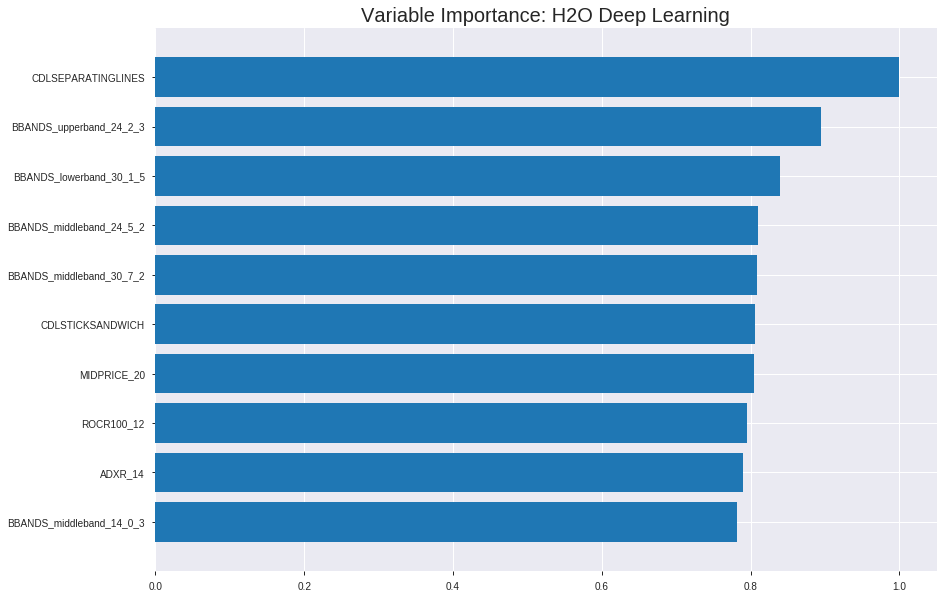

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_1_AutoML_20190826_131722


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.38977344608713593
RMSE: 0.6243183851907101
LogLoss: 1.5855534212751528
Mean Per-Class Error: 0.4760589768654284
AUC: 0.5192625176496144
pr_auc: 0.5551558516152082
Gini: 0.038525035299228794
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.00019882523014835672: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      0    792   1        (792.0/792.0)
1      0    930   0        (0.0/930.0)
Total  0    1722  0.4599   (792.0/1722.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.000198825  0.701357   399
max f2                       0.000198825  0.854465   399
max f0point5                 0.000198825  0.594781   399
max accuracy                 0.000914821  0.54065    397
max precision                0.987106     0.666667   6
max recall                   0.000198825  1          399
max specificity              0.999962     0.994949   0
max absolute_mcc             0.954329     0.0494994  19
max min_per_class_accuracy   0.186987     0.51828    285
max mean_per_class_accuracy  0.192829     0.523941   282

Gains/Lift Table: Avg response rate: 54.01 %, avg score: 28.89 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010453                    0.993051           1.02867   1.02867            0.555556         0.997409     0.555556                    0.997409            0.0107527       0.0107527                  2.86738   2.86738
    2        0.0203252                   0.982682           1.41594   1.21677            0.764706         0.987595     0.657143                    0.992642            0.0139785       0.0247312                  41.5939   21.6774
    3        0.0301974                   0.968216           1.08918   1.17506            0.588235         0.975131     0.634615                    0.986917            0.0107527       0.0354839                  8.91841   17.5062
    4        0.0400697                   0.942283           1.1981    1.18074            0.647059         0.957267     0.637681                    0.979612            0.011828        0.0473118                  19.8102   18.0739
    5        0.0505226                   0.921801           0.308602  1.0003             0.166667         0.930107     0.54023                     0.96937             0.00322581      0.0505376                  -69.1398  0.0296626
    6        0.100465                    0.797755           1.09805   1.04889            0.593023         0.861625     0.566474                    0.915809            0.0548387       0.105376                   9.80495   4.88905
    7        0.150407                    0.656729           1.05499   1.05092            0.569767         0.729394     0.567568                    0.85391             0.0526882       0.158065                   5.49887   5.09154
    8        0.200348                    0.574148           1.01193   1.0412             0.546512         0.613489     0.562319                    0.793979            0.0505376       0.208602                   1.1928    4.11968
    9        0.300232                    0.377668           1.01193   1.03146            0.546512         0.467609     0.55706                     0.6854              0.101075        0.309677                   1.1928    3.14594
    10       0.400116                    0.275261           1.04422   1.03465            0.563953         0.324715     0.558781                    0.595359            0.104301        0.413978                   4.42236   3.46458
    11       0.5                         0.186825           1.03346   1.03441            0.55814          0.229148     0.558653                    0.522202            0.103226        0.517204                   3.34584   3.44086
    12       0.599884                    0.114033           0.979632  1.02529            0.52907          0.15081      0.553727                    0.460363            0.0978495       0.615054                   -2.03676  2.52881
    13       0.699768                    0.0582826          0.936572  1.01262            0.505814         0.087711     0.546888                    0.407171            0.0935484       0.708602                   -6.34284  1.26248
    14       0.799652                    0.0156991          0.958102  1.00581            0.517442         0.0334937    0.54321                     0.360496            0.0956989       0.804301                   -4.1898   0.581442
    15       0.899535                    0.00123628         1.01193   1.00649            0.546512         0.00610369   0.543577                    0.321144            0.101075        0.905376                   1.1928    0.649326
    16       1                           1.50148e-05        0.941861  1                  0.508671         



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.5174917488002444
RMSE: 0.7193689934937733
LogLoss: 7.263720633964843
Mean Per-Class Error: 0.49278105911454395
AUC: 0.4701903175324348
pr_auc: 0.41494913279290757
Gini: -0.059619364935130426
Confusion Matrix (Act/Pred) for max f1 @ threshold = 1.2495437079838249e-07: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    213  1        (213.0/213.0)
1      0    279  0        (0.0/279.0)
Total  0    492  0.4329   (213.0/492.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       1.24954e-07  0.723735   367
max f2                       1.24954e-07  0.867537   367
max f0point5                 1.24954e-07  0.620828   367
max accuracy                 1.75828e-07  0.567073   365
max precision                0.999982     0.57971    13
max recall                   1.24954e-07  1          367
max specificity              1            0.746479   0
max absolute_mcc             2.15104e-05  0.0948295  295
max min_per_class_accuracy   0.0265674    0.480287   118
max mean_per_class_accuracy  0.999982     0.507219   13

Gains/Lift Table: Avg response rate: 56.71 %, avg score: 45.54 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.193089                    1                  0.965252  0.965252           0.547368         1            0.547368                    1                   0.18638         0.18638                    -3.47482  -3.47482
    2        0.20122                     1                  0.88172   0.961877           0.5              1            0.545455                    1                   0.00716846      0.193548                   -11.828   -3.81232
    3        0.300813                    0.999904           1.04367   0.988957           0.591837         0.999986     0.560811                    0.999995            0.103943        0.297491                   4.36691   -1.10433
    4        0.400407                    0.991613           0.827738  0.948857           0.469388         0.998175     0.538071                    0.999543            0.0824373       0.379928                   -17.2262  -5.11435
    5        0.5                         0.01731            1.04367   0.967742           0.591837         0.551197     0.54878                     0.910238            0.103943        0.483871                   4.36691   -3.22581
    6        0.599593                    0.000226455        1.00768   0.974376           0.571429         0.00252291   0.552542                    0.759465            0.100358        0.584229                   0.768049  -2.56242
    7        0.699187                    8.74858e-05        0.971692  0.973993           0.55102          0.00014535   0.552326                    0.651306            0.0967742       0.681004                   -2.83081  -2.60065
    8        0.79878                     3.6866e-05         0.935703  0.969219           0.530612         6.25561e-05  0.549618                    0.570108            0.09319         0.774194                   -6.42967  -3.07806
    9        0.898374                    1.14774e-05        1.07966   0.981463           0.612245         2.29742e-05  0.556561                    0.506908            0.107527        0.88172                    7.96577   -1.85374
    10       1                           1.24954e-07        1.16387   1                  0.66             5.48365e-06  0.567073                    0.455394            0.11828         1                          16.3871   0


Scoring History: 


timestamp            duration    training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-26 13:17:23  0.000 sec                     0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-26 13:17:27  4.128 sec   1144 obs/sec      1         1             1722       0.624318         1.58555             -0.569172      0.519263        0.555156           1.02867          0.45993                          0.719369           7.26372               -1.1079          0.47019           0.414949             0.965252           0.432927
    2019-08-26 13:17:29  6.337 sec   4938 obs/sec      10        10            17220      0.499937         0.6977              -0.00620852    0.581778        0.622496           1.64588          0.442509                         0.616374           8.77586               -0.547516        0.470443          0.259157             0.96122            0.432927
    2019-08-26 13:17:29  6.534 sec   4907 obs/sec      10        10            17220      0.624318         1.58555             -0.569172      0.519263        0.555156           1.02867          0.45993                          0.719369           7.26372               -1.1079          0.47019           0.414949             0.965252           0.432927

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ----------------------
CDLSEPARATINGLINES        1.0                    1.0                  0.0018043942007124041
BBANDS_upperband_24_2_3   0.894092321395874      0.894092321395874    0.0016132949996282059
BBANDS_lowerband_30_1_5   0.8393965363502502     0.8393965363502502   0.0015146022422884702
BBANDS_middleband_24_5_2  0.8104017972946167     0.8104017972946167   0.0014622843032853156
BBANDS_middleband_30_7_2  0.8087756037712097     0.8087756037712097   0.001459350009122444
---                       ---                    ---                  ---
T3_8_2                    0.28049468994140625    0.28049468994140625  0.0005061229918608974
WMA_20                    0.2759202718734741     0.2759202718734741   0.0004978689384274866
TSF_24                    0.2735404968261719     0.2735404968261719   0.0004935748861331343
BBANDS_upperband_30_0_5   0.24344366788864136    0.24344366788864136  0.00043926834253842095
MOM_30                    0.21755117177963257    0.21755117177963257  0.00039254807271735703


See the whole table with table.as_data_frame()


('accuracy', 0.4817813765182186)

('F1', 0.6502732240437158)

('auc', 0.5)

('logloss', 17.898637160115648)

('mean_per_class_error', 0.5)

('rmse', 0.7198740330653561)

('mse', 0.5182186234817814)

deeplearning prediction progress: |███████████████████████████████████████| 100%


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


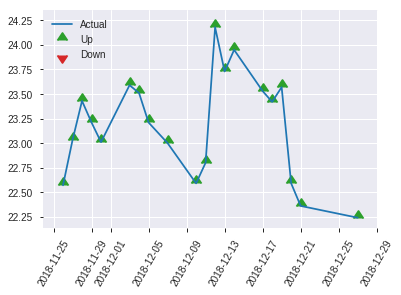


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.5182186234817814
RMSE: 0.7198740330653561
LogLoss: 17.898637160115648
Mean Per-Class Error: 0.5
AUC: 0.5
pr_auc: 0.0
Gini: 0.0
Confusion Matrix (Act/Pred) for max f1 @ threshold = 1.0: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    128  1        (128.0/128.0)
1      0    119  0        (0.0/119.0)
Total  0    247  0.5182   (128.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       1            0.650273  0
max f2                       1            0.82296   0
max f0point5                 1            0.537489  0
max accuracy                 1            0.481781  0
max precision                1            0.481781  0
max recall                   1            1         0
max specificity              1            0         0
max absolute_mcc             1            0         0
max min_per_class_accuracy   1            0         0
max mean_per_class_accuracy  1            0.5       0

Gains/Lift Table: Avg response rate: 48.18 %, avg score: 100.00 %



group    cumulative_data_fraction    lower_threshold    lift    cumulative_lift    response_rate    score    cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain    cumulative_gain
--  -------  --------------------------  -----------------  ------  -----------------  ---------------  -------  --------------------------  ------------------  --------------  -------------------------  ------  -----------------
    1        1                           1                  1       1                  0.481781         1        0.481781                    1                   1               1                          0       0

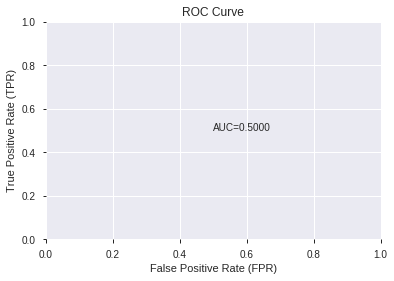

This function is available for GLM models only


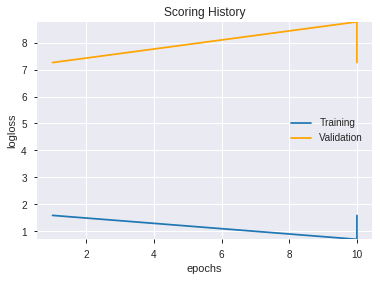

--2019-08-26 13:50:41--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.139.155
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.139.155|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 368257676 (351M) [application/zip]
Saving to: ‘h2o-3.24.0.5.zip’

h2o-3.24.0.5.zip    100%[===================>] 351.20M  13.9MB/s    in 27s     

2019-08-26 13:51:09 (13.0 MB/s) - ‘h2o-3.24.0.5.zip’ saved [368257676/368257676]

Archive:  h2o-3.24.0.5.zip
   creating: h2o-3.24.0.5/
   creating: h2o-3.24.0.5/bindings/
   creating: h2o-3.24.0.5/bindings/java/
 extracting: h2o-3.24.0.5/bindings/java/h2o-bindings-3.24.0.zip  
  inflating: h2o-3.24.0.5/h2o.jar    
   creating: h2o-3.24.0.5/python/
  inflating: h2o-3.24.0.5/python/h2o-3.24.0.5-py2.py3-none-any.whl  
   creating: h2o-3.24.0.5/R/
  inflating: h2o-3.24.0.5/R/h2o_3.24.0.5.tar.gz  
ERROR: U

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_1_AutoML_20190826_131722',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_1_AutoML_20190826_131722',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_2_sid_97b9',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_2_sid_97b9',


In [10]:
# DeepLearning
features_list = model_train(feature_name='All',model_algo="DeepLearning")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190826_135123_model_3  0.574120  0.776606              0.500000  0.524270  0.274859
1  DeepLearning_grid_1_AutoML_20190826_135123_model_4  0.548976  0.737668              0.484375  0.519118  0.269484
2  DeepLearning_grid_1_AutoML_20190826_135123_model_7  0.537421  0.722093              0.492188  0.513971  0.264166
3  DeepLearning_grid_1_AutoML_20190826_135123_model_2  0.536108  7.698671              0.500000  0.694089  0.481759
4  DeepLearning_grid_1_AutoML_20190826_135123_model_1  0.507550  2.594717              0.496094  0.681844  0.464912
5  DeepLearning_grid_1_AutoML_20190826_135123_model_8  0.500000  0.711466              0.500000  0.508977  0.259057
6  DeepLearning_grid_1_AutoML_20190826_135123_model_9  0.500000  0.703511              0.500000  0.505127  0.255154
7               DeepLearning_1_AutoML_20190826_135123  0.495273  1.984985              0.500000  0.686519  0.471308
8  DeepLearning_grid_1_AutoML_20190826_135123_model_6  0.491859  0.713247              0.500000  0.509826  0.259923
9  DeepLearning_grid_1_AutoML_20190826_135123_model_5  0.484211  0.703414              0.500000  0.505080  0.255106

variable  relative_importance  scaled_importance  percentage
0                  CDLINNECK             1.000000           1.000000    0.058547
1             CDLMORNINGSTAR             0.975499           0.975499    0.057112
2                CDLPIERCING             0.936164           0.936164    0.054809
3           CDLSTICKSANDWICH             0.831944           0.831944    0.048708
4              CDLHIKKAKEMOD             0.829012           0.829012    0.048536
5            CDLSHOOTINGSTAR             0.640525           0.640525    0.037501
6                 AROONOSC_8             0.527575           0.527575    0.030888
7         CDLSEPARATINGLINES             0.519530           0.519530    0.030417
8                       week             0.514399           0.514399    0.030116
9                    ADXR_14             0.408139           0.408139    0.023895
10                     DX_12             0.382102           0.382102    0.022371
11                PLUS_DI_24             0.356399           0.356399    0.020866
12                   NATR_20             0.306309           0.306309    0.017933
13                   NATR_14             0.276494           0.276494    0.016188
14                PLUS_DI_14             0.269910           0.269910    0.015802
15   BBANDS_lowerband_30_1_5             0.266577           0.266577    0.015607
16   BBANDS_lowerband_24_1_4             0.266116           0.266116    0.015580
17   BBANDS_upperband_24_6_5             0.262091           0.262091    0.015345
18                    ROC_14             0.261786           0.261786    0.015327
19  BBANDS_middleband_30_0_3             0.254834           0.254834    0.014920
20                ROCR100_12             0.251533           0.251533    0.014726
21   BBANDS_upperband_24_1_4             0.247529           0.247529    0.014492
22  BBANDS_middleband_30_7_2             0.245360           0.245360    0.014365
23                ROCR100_14             0.245310           0.245310    0.014362
24   BBANDS_lowerband_12_4_5             0.244197           0.244197    0.014297
25   BBANDS_lowerband_20_0_4             0.244113           0.244113    0.014292
26    BBANDS_lowerband_8_6_4             0.243365           0.243365    0.014248
27   BBANDS_upperband_24_5_2             0.243312           0.243312    0.014245
28   BBANDS_upperband_24_0_5             0.242708           0.242708    0.014210
29    BBANDS_upperband_8_0_5             0.239788           0.239788    0.014039
30                  MAVP_8_6             0.239429           0.239429    0.014018
31   BBANDS_upperband_14_2_5             0.237528           0.237528    0.013906
32  BBANDS_middleband_12_2_5             0.235809           0.235809    0.013806
33   BBANDS_upperband_14_7_5             0.235280           0.235280    0.013775
34  BBANDS_middleband_14_0_3             0.234847           0.234847    0.013749
35    BBANDS_upperband_8_8_5             0.233709           0.233709    0.013683
36  BBANDS_middleband_24_0_4             0.232459           0.232459    0.013610
37   BBANDS_lowerband_14_5_4             0.231675           0.231675    0.013564
38                 MAVP_30_6             0.231282           0.231282    0.013541
39               MIDPRICE_20             0.230307           0.230307    0.013484
40  BBANDS_middleband_14_5_5             0.228677           0.228677    0.013388
41              LINEARREG_30             0.227753           0.227753    0.013334
42                    MOM_14             0.227446           0.227446    0.013316
43   BBANDS_upperband_24_2_3             0.225940           0.225940    0.013228
44    BBANDS_upperband_8_3_5             0.224663           0.224663    0.013153
45  BBANDS_middleband_12_3_5             0.220910           0.220910    0.012934
46   BBANDS_upperband_12_0_2             0.220249           0.220249    0.012895
47                   MA_12_0             0.211611           0.211611    0.012389
48   BBANDS_upperband_20_7_2             0.209734  

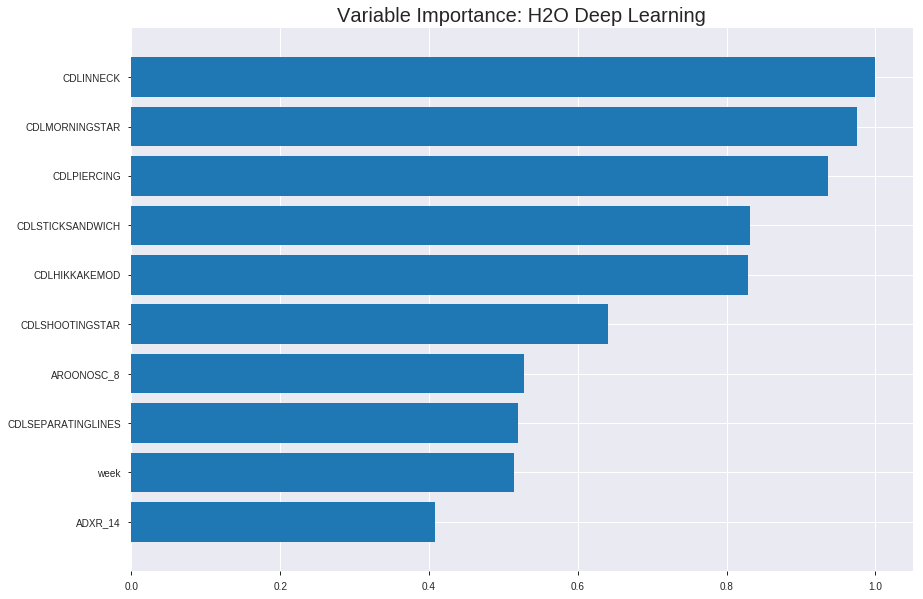

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190826_135123_model_3


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.2541737267376444
RMSE: 0.504156450655592
LogLoss: 0.7072302306343987
Mean Per-Class Error: 0.4372026718800912
AUC: 0.5686081242532856
pr_auc: 0.5955071831919648
Gini: 0.1372162485065711
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.17761488063429332: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      24   768   0.9697   (768.0/792.0)
1      10   920   0.0108   (10.0/930.0)
Total  34   1688  0.4518   (778.0/1722.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.177615     0.702827  379
max f2                       0.0963371    0.855094  395
max f0point5                 0.478478     0.603584  221
max accuracy                 0.478478     0.569686  221
max precision                0.99996      1         0
max recall                   0.0963371    1         395
max specificity              0.99996      1         0
max absolute_mcc             0.487439     0.126931  216
max min_per_class_accuracy   0.514393     0.55914   194
max mean_per_class_accuracy  0.522187     0.562797  188

Gains/Lift Table: Avg response rate: 54.01 %, avg score: 50.62 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010453                    0.85864            1.33728   1.33728            0.722222         0.943114  0.722222                    0.943114            0.0139785       0.0139785                  33.7276   33.7276
    2        0.0203252                   0.809676           1.08918   1.21677            0.588235         0.833338  0.657143                    0.889794            0.0107527       0.0247312                  8.91841   21.6774
    3        0.0301974                   0.775552           0.980266  1.13945            0.529412         0.790177  0.615385                    0.857227            0.00967742      0.0344086                  -1.97343  13.9454
    4        0.0400697                   0.759694           1.1981    1.1539             0.647059         0.769543  0.623188                    0.835623            0.011828        0.0462366                  19.8102   15.3904
    5        0.0505226                   0.741409           1.23441   1.17056            0.666667         0.749531  0.632184                    0.817811            0.0129032       0.0591398                  23.4409   17.056
    6        0.100465                    0.685385           1.14111   1.15592            0.616279         0.712255  0.624277                    0.765338            0.0569892       0.116129                   14.111    15.592
    7        0.150407                    0.645562           1.14111   1.151              0.616279         0.663361  0.621622                    0.731477            0.0569892       0.173118                   14.111    15.1003
    8        0.200348                    0.614686           1.16264   1.1539             0.627907         0.630817  0.623188                    0.706385            0.0580645       0.231183                   16.2641   15.3904
    9        0.300232                    0.577546           1.11958   1.14248            0.604651         0.594579  0.617021                    0.669188            0.111828        0.343011                   11.958    14.2485
    10       0.400116                    0.547405           1.00116   1.10721            0.540698         0.562895  0.597968                    0.642654            0.1             0.443011                   0.116279  10.7205
    11       0.5                         0.515731           1.13035   1.11183            0.610465         0.532505  0.600465                    0.62065             0.112903        0.555914                   13.0345   11.1828
    12       0.599884                    0.479115           0.990398  1.09161            0.534884         0.49852   0.589545                    0.600314            0.0989247       0.654839                   -0.96024  9.16092
    13       0.699768                    0.437412           0.818155  1.05258            0.44186          0.460075  0.568465                    0.580297            0.0817204       0.736559                   -18.1845  5.25766
    14       0.799652                    0.384571           0.861215  1.02867            0.465116         0.413119  0.555556                    0.559415            0.0860215       0.822581                   -13.8785  2.86738
    15       0.899535                    0.31898            0.947337  1.01964            0.511628         0.353023  0.550678                    0.536497            0.0946237       0.917204                   -5.26632  1.96422
    16       1                           0.00483354         0.824128  1                  0.445087         0.235272  0.54007                     0.506235           



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.3155484258693678
RMSE: 0.5617369721403139
LogLoss: 0.8790837576252182
Mean Per-Class Error: 0.4496188601140896
AUC: 0.531197940330153
pr_auc: 0.6193767214688574
Gini: 0.06239588066030599
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.11035290129272492: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      11   202  0.9484   (202.0/213.0)
1      5    274  0.0179   (5.0/279.0)
Total  16   476  0.4207   (207.0/492.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.110353     0.725828  384
max f2                       0.000126972  0.867537  399
max f0point5                 0.110353     0.627577  384
max accuracy                 0.110353     0.579268  384
max precision                0.842432     1         0
max recall                   0.000126972  1         399
max specificity              0.842432     1         0
max absolute_mcc             0.522989     0.141253  67
max min_per_class_accuracy   0.315549     0.526882  210
max mean_per_class_accuracy  0.522989     0.550381  67

Gains/Lift Table: Avg response rate: 56.71 %, avg score: 33.72 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101626                   0.790986           1.41075   1.41075            0.8              0.822179  0.8                         0.822179            0.0143369       0.0143369                  41.0753   41.0753
    2        0.0203252                   0.744145           1.41075   1.41075            0.8              0.764462  0.8                         0.793321            0.0143369       0.0286738                  41.0753   41.0753
    3        0.0304878                   0.707924           1.41075   1.41075            0.8              0.725518  0.8                         0.77072             0.0143369       0.0430108                  41.0753   41.0753
    4        0.0406504                   0.681              1.05806   1.32258            0.6              0.691901  0.75                        0.751015            0.0107527       0.0537634                  5.80645   32.2581
    5        0.050813                    0.661492           1.05806   1.26968            0.6              0.668008  0.72                        0.734414            0.0107527       0.0645161                  5.80645   26.9677
    6        0.101626                    0.580804           1.41075   1.34022            0.8              0.611922  0.76                        0.673168            0.0716846       0.136201                   41.0753   34.0215
    7        0.150407                    0.518231           1.10215   1.263              0.625            0.552171  0.716216                    0.633926            0.0537634       0.189964                   10.2151   26.3005
    8        0.20122                     0.49333            0.775914  1.14               0.44             0.506777  0.646465                    0.601817            0.0394265       0.229391                   -22.4086  14.0002
    9        0.300813                    0.412911           1.04367   1.10811            0.591837         0.450711  0.628378                    0.551789            0.103943        0.333333                   4.36691   10.8108
    10       0.400407                    0.361379           1.07966   1.10103            0.612245         0.384301  0.624365                    0.510129            0.107527        0.44086                    7.96577   10.1032
    11       0.5                         0.316014           0.827738  1.04659            0.469388         0.341236  0.593496                    0.476488            0.0824373       0.523297                   -17.2262  4.6595
    12       0.599593                    0.274572           0.719772  0.992309           0.408163         0.294416  0.562712                    0.446246            0.0716846       0.594982                   -28.0228  -0.769091
    13       0.699187                    0.218164           0.899715  0.97912            0.510204         0.249123  0.555233                    0.418167            0.0896057       0.684588                   -10.0285  -2.08802
    14       0.79878                     0.166018           1.00768   0.982681           0.571429         0.190678  0.557252                    0.389803            0.100358        0.784946                   0.768049  -1.73192
    15       0.898374                    0.131039           1.22361   1.00939            0.693878         0.148029  0.572398                    0.363               0.121864        0.90681                    22.3612   0.939036
    16       1                           0.000126972        0.916989  1                  0.52             0.109006  0.567073                    0.337188     


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-26 13:53:51  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-26 13:53:54  2 min 29.749 sec  6401 obs/sec      10        1             17220      0.596674         1.82109             -0.433283      0.511925        0.558378           1.13154          0.45993                          0.753043           13.1024               -1.30986         0.517761          0.586208             1.41075            0.432927
    2019-08-26 13:54:00  2 min 35.767 sec  7994 obs/sec      40        4             68880      0.512498         0.730481            -0.0574088     0.547414        0.573825           1.02867          0.455285                         0.561354           0.930523              -0.283571        0.521918          0.604933             1.41075            0.422764
    2019-08-26 13:54:06  2 min 41.676 sec  9546 obs/sec      80        8             137760     0.515064         0.736456            -0.0680241     0.544531        0.574073           1.13154          0.458188                         0.646699           1.31028               -0.703533        0.518906          0.612786             1.41075            0.432927
    2019-08-26 13:54:11  2 min 46.808 sec  10620 obs/sec     120       12            206640     0.504156         0.70723             -0.0232667     0.568608        0.595507           1.33728          0.4518                           0.561737           0.879084              -0.285323        0.531198          0.619377             1.41075            0.420732
    2019-08-26 13:54:17  2 min 52.735 sec  11579 obs/sec     170       17            292740     0.516892         0.749474            -0.0756183     0.565895        0.598278           1.33728          0.455285                         0.710626           2.02411               -1.05697         0.538451          0.61938              1.41075            0.430894
    2019-08-26 13:54:22  2 min 58.101 sec  12431 obs/sec     220       22            378840     0.52329          0.782834            -0.102411      0.56499         0.596561           1.44014          0.454704                         0.733235           2.77019               -1.18994         0.533529          0.616152             1.41075            0.432927
    2019-08-26 13:54:28  3 min  3.504 sec  12991 obs/sec     270       27            464940     0.523296         0.799388            -0.102437      0.578822        0.620906           1.64588          0.457027                         0.743761           3.31995               -1.25327         0.531265          0.615539             1.41075            0.432927
    2019-08-26 13:54:28  3 min  3.604 sec  12989 obs/sec     270       27            464940     0.504156         0.70723             -0.0232667     0.568608        0.595507           1.33728          0.4518                           0.561737           0.879084              -0.285323        0.531198          0.619377             1.41075            0.420732

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  --------------------
CDLINNECK                 1.0                    1.0                  0.058546630164811535
CDLMORNINGSTAR            0.9754994511604309     0.9754994511604309   0.05711220559306638
CDLPIERCING               0.9361644387245178     0.9361644387245178   0.05480927316745272
CDLSTICKSANDWICH          0.8319442272186279     0.8319442272186279   0.048707530988718946
CDLHIKKAKEMOD             0.8290121555328369     0.8290121555328369   0.04853586807211422
---                       ---                    ---                  ---
BBANDS_middleband_12_3_5  0.22090980410575867    0.22090980410575867  0.012933524600760818
BBANDS_upperband_12_0_2   0.22024880349636078    0.22024880349636078  0.012894825242543685
MA_12_0                   0.21161140501499176    0.21161140501499176  0.012389134668068867
BBANDS_upperband_20_7_2   0.2097337394952774     0.2097337394952774   0.012279203679312933
BBANDS_middleband_24_5_2  0.2084723711013794     0.2084723711013794   0.012205354810453803


See the whole table with table.as_data_frame()


('accuracy', 0.5951417004048583)

('F1', 0.6502732240437158)

('auc', 0.5741202731092437)

('logloss', 0.776605684489557)

('mean_per_class_error', 0.4065782563025211)

('rmse', 0.524269708217813)

('mse', 0.2748587269547908)

deeplearning prediction progress: |███████████████████████████████████████| 100%


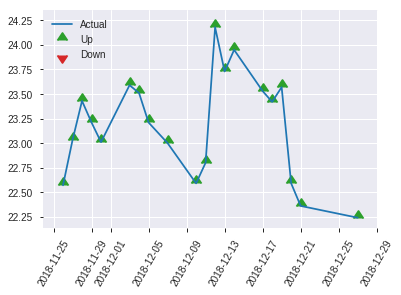


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.2748587269547908
RMSE: 0.524269708217813
LogLoss: 0.776605684489557
Mean Per-Class Error: 0.4065782563025211
AUC: 0.5741202731092437
pr_auc: 0.5326919811032097
Gini: 0.14824054621848748
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.022015256824347337: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    128  1        (128.0/128.0)
1      0    119  0        (0.0/119.0)
Total  0    247  0.5182   (128.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.0220153    0.650273  246
max f2                       0.0220153    0.82296   246
max f0point5                 0.409573     0.577265  110
max accuracy                 0.409573     0.595142  110
max precision                0.911802     1         0
max recall                   0.0220153    1         246
max specificity              0.911802     1         0
max absolute_mcc             0.409573     0.187683  110
max min_per_class_accuracy   0.388934     0.563025  120
max mean_per_class_accuracy  0.409573     0.593422  110

Gains/Lift Table: Avg response rate: 48.18 %, avg score: 37.95 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0121457                   0.851161           1.38375   1.38375            0.666667         0.880561  0.666667                    0.880561            0.0168067       0.0168067                  38.3754    38.3754
    2        0.0202429                   0.831935           0         0.830252           0                0.836006  0.4                         0.862739            0               0.0168067                  -100       -16.9748
    3        0.0323887                   0.7683             0.691877  0.778361           0.333333         0.811049  0.375                       0.843355            0.00840336      0.0252101                  -30.8123   -22.1639
    4        0.0404858                   0.721982           2.07563   1.03782            1                0.747211  0.5                         0.824126            0.0168067       0.0420168                  107.563    3.78151
    5        0.0526316                   0.680452           1.38375   1.11765            0.666667         0.701352  0.538462                    0.795794            0.0168067       0.0588235                  38.3754    11.7647
    6        0.101215                    0.621158           1.03782   1.07933            0.5              0.650394  0.52                        0.726002            0.0504202       0.109244                   3.78151    7.93277
    7        0.149798                    0.567337           1.21078   1.12196            0.583333         0.590561  0.540541                    0.682075            0.0588235       0.168067                   21.0784    12.1962
    8        0.202429                    0.530789           1.59664   1.24538            0.769231         0.551619  0.6                         0.648156            0.0840336       0.252101                   59.6639    24.5378
    9        0.299595                    0.489481           1.29727   1.26221            0.625            0.509133  0.608108                    0.603068            0.12605         0.378151                   29.7269    26.2208
    10       0.40081                     0.429929           0.996303  1.19506            0.48             0.461708  0.575758                    0.567371            0.10084         0.478992                   -0.369748  19.506
    11       0.502024                    0.370154           0.830252  1.12151            0.4              0.407203  0.540323                    0.535079            0.0840336       0.563025                   -16.9748   12.151
    12       0.59919                     0.320415           1.03782   1.10794            0.5              0.342379  0.533784                    0.50383             0.10084         0.663866                   3.78151    10.7938
    13       0.700405                    0.25013            0.747227  1.05581            0.36             0.281309  0.508671                    0.471674            0.0756303       0.739496                   -25.2773   5.58119
    14       0.797571                    0.189511           0.951331  1.04308            0.458333         0.215812  0.502538                    0.440503            0.092437        0.831933                   -4.86695   4.30832
    15       0.898785                    0.149485           0.498151  0.981717           0.24             0.169264  0.472973                    0.409958            0.0504202       0.882353                   -50.1849   -1.8283
    16       1                           0.0220153          1.16235   1                  0.56             0.109269  0.481781                    

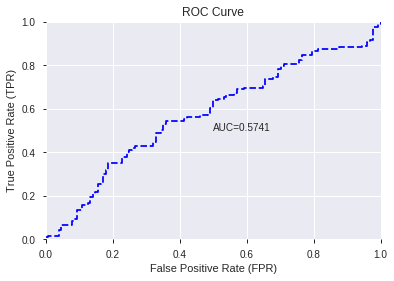

This function is available for GLM models only


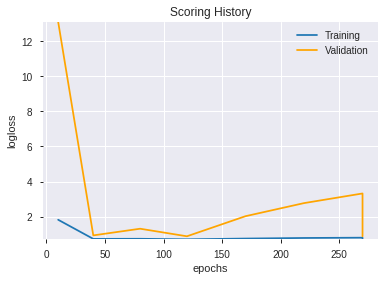

--2019-08-26 14:02:27--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.21.203
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.21.203|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190826_135123_model_3',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190826_135123_model_3',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_10_sid_97b9',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['CDLINNECK',
 'CDLMORNINGSTAR',
 'CDLPIERCING',
 'CDLSTICKSANDWICH',
 'CDLHIKKAKEMOD',
 'CDLSHOOTINGSTAR',
 'AROONOSC_8',
 'CDLSEPARATINGLINES',
 'week',
 'ADXR_14',
 'DX_12',
 'PLUS_DI_24',
 'NATR_20',
 'NATR_14',
 'PLUS_DI_14',
 'BBANDS_lowerband_30_1_5',
 'BBANDS_lowerband_24_1_4',
 'BBANDS_upperband_24_6_5',
 'ROC_14',
 'BBANDS_middleband_30_0_3',
 'ROCR100_12',
 'BBANDS_upperband_24_1_4',
 'BBANDS_middleband_30_7_2',
 'ROCR100_14',
 'BBANDS_lowerband_12_4_5',
 'BBANDS_lowerband_20_0_4',
 'BBANDS_lowerband_8_6_4',
 'BBANDS_upperband_24_5_2',
 'BBANDS_upperband_24_0_5',
 'BBANDS_upperband_8_0_5',
 'MAVP_8_6',
 'BBANDS_upperband_14_2_5',
 'BBANDS_middleband_12_2_5',
 'BBANDS_upperband_14_7_5',
 'BBANDS_middleband_14_0_3',
 'BBANDS_upperband_8_8_5',
 'BBANDS_middleband_24_0_4',
 'BBANDS_lowerband_14_5_4',
 'MAVP_30_6',
 'MIDPRICE_20',
 'BBANDS_middleband_14_5_5',
 'LINEARREG_30',
 'MOM_14',
 'BBANDS_upperband_24_2_3',
 'BBANDS_upperband_8_3_5',
 'BBANDS_middleband_12_3_5',
 'BBANDS_u

In [11]:
# DeepLearning with top DeepLearning features
model_train(feature_name='DLF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc  logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190826_140239_model_1  0.470129   0.7222                   0.5  0.514038  0.264235

variable  relative_importance  scaled_importance  percentage
0                  CDLINNECK             0.008913           1.000000    0.109572
1           CDLSTICKSANDWICH             0.006246           0.700817    0.076790
2              CDLHIKKAKEMOD             0.005351           0.600356    0.065782
3                    NATR_20             0.004353           0.488418    0.053517
4                 PLUS_DI_24             0.004161           0.466891    0.051158
5                      DX_12             0.003526           0.395628    0.043350
6                    NATR_14             0.003353           0.376210    0.041222
7         CDLSEPARATINGLINES             0.003090           0.346650    0.037983
8            CDLSHOOTINGSTAR             0.003065           0.343940    0.037686
9             CDLMORNINGSTAR             0.002581           0.289627    0.031735
10                ROCR100_14             0.002448           0.274626    0.030091
11                    ROC_14             0.002435           0.273161    0.029931
12   BBANDS_lowerband_14_5_4             0.002317           0.259970    0.028485
13   BBANDS_lowerband_12_4_5             0.002039           0.228797    0.025070
14                   ADXR_14             0.001817           0.203913    0.022343
15    BBANDS_lowerband_8_6_4             0.001668           0.187159    0.020507
16                ROCR100_12             0.001486           0.166734    0.018269
17   BBANDS_lowerband_20_0_4             0.001159           0.130019    0.014246
18   BBANDS_upperband_24_6_5             0.001157           0.129804    0.014223
19   BBANDS_upperband_24_1_4             0.001143           0.128236    0.014051
20               CDLPIERCING             0.001076           0.120682    0.013223
21  BBANDS_middleband_12_2_5             0.000989           0.110917    0.012153
22              LINEARREG_30             0.000970           0.108863    0.011928
23  BBANDS_middleband_14_5_5             0.000963           0.108072    0.011842
24                   MA_12_0             0.000960           0.107712    0.011802
25  BBANDS_middleband_12_3_5             0.000948           0.106310    0.011649
26   BBANDS_upperband_24_2_3             0.000944           0.105903    0.011604
27                 MAVP_30_6             0.000890           0.099869    0.010943
28                  MAVP_8_6             0.000858           0.096275    0.010549
29  BBANDS_middleband_14_0_3             0.000806           0.090410    0.009906
30   BBANDS_upperband_24_0_5             0.000795           0.089193    0.009773
31  BBANDS_middleband_30_7_2             0.000763           0.085637    0.009383
32   BBANDS_upperband_14_7_5             0.000745           0.083564    0.009156
33               MIDPRICE_20             0.000691           0.077511    0.008493
34   BBANDS_lowerband_24_1_4             0.000641           0.071865    0.007874
35   BBANDS_upperband_24_5_2             0.000640           0.071838    0.007871
36   BBANDS_lowerband_30_1_5             0.000596           0.066819    0.007321
37   BBANDS_upperband_12_0_2             0.000574           0.064421    0.007059
38  BBANDS_middleband_30_0_3             0.000572           0.064175    0.007032
39  BBANDS_middleband_24_5_2             0.000509           0.057080    0.006254
40   BBANDS_upperband_14_2_5             0.000484           0.054340    0.005954
41  BBANDS_middleband_24_0_4             0.000471           0.052819    0.005788
42    BBANDS_upperband_8_0_5             0.000469           0.052622    0.005766
43    BBANDS_upperband_8_8_5             0.000395           0.044282    0.004852
44   BBANDS_upperband_20_7_2             0.000358           0.040217    0.004407
45                AROONOSC_8             0.000352           0.039474    0.004325
46                    MOM_14             0.000256           0.028771    0.003153
47    BBANDS_upperband_8_3_5             0.000234           0.026240    0.002875
48                      week             0.000083  

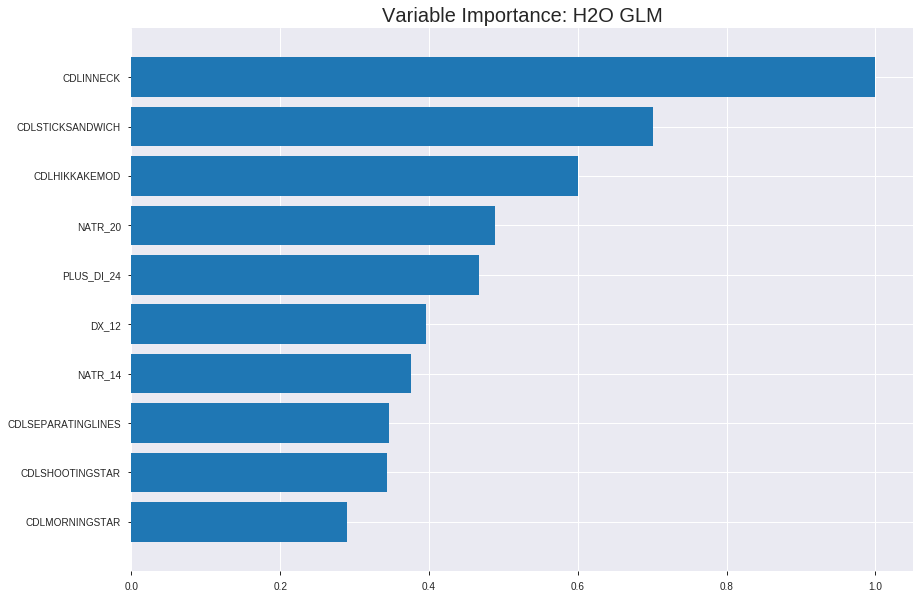

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190826_140239_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24808861870231952
RMSE: 0.49808495129076075
LogLoss: 0.6893175541324243
Null degrees of freedom: 1721
Residual degrees of freedom: 1671
Null deviance: 2376.1277882295276
Residual deviance: 2374.0096564320693
AIC: 2476.0096564320693
AUC: 0.5205427935266644
pr_auc: 0.5572191924891304
Gini: 0.041085587053328876
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5240996131840802: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      5    787   0.9937   (787.0/792.0)
1      0    930   0        (0.0/930.0)
Total  5    1717  0.457    (787.0/1722.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.5241       0.702682   394
max f2                       0.5241       0.855251   394
max f0point5                 0.533539     0.599688   333
max accuracy                 0.533539     0.553426   333
max precision                0.591179     1          0
max recall                   0.5241       1          394
max specificity              0.591179     1          0
max absolute_mcc             0.533539     0.0710968  333
max min_per_class_accuracy   0.539006     0.509677   224
max mean_per_class_accuracy  0.533539     0.522296   333

Gains/Lift Table: Avg response rate: 54.01 %, avg score: 54.01 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010453                    0.556307           1.33728   1.33728            0.722222         0.55927   0.722222                    0.55927             0.0139785       0.0139785                  33.7276   33.7276
    2        0.0203252                   0.555431           1.08918   1.21677            0.588235         0.555722  0.657143                    0.557547            0.0107527       0.0247312                  8.91841   21.6774
    3        0.0301974                   0.554965           1.08918   1.17506            0.588235         0.555132  0.634615                    0.556757            0.0107527       0.0354839                  8.91841   17.5062
    4        0.0400697                   0.554469           0.980266  1.12707            0.529412         0.554731  0.608696                    0.556258            0.00967742      0.0451613                  -1.97343  12.7069
    5        0.0505226                   0.554233           0.720072  1.04286            0.388889         0.554376  0.563218                    0.555869            0.00752688      0.0526882                  -27.9928  4.28624
    6        0.100465                    0.551295           0.947337  0.995376           0.511628         0.552574  0.537572                    0.554231            0.0473118       0.1                        -5.26632  -0.462428
    7        0.150407                    0.54703            1.14111   1.04377            0.616279         0.549049  0.563707                    0.55251             0.0569892       0.156989                   14.111    4.37663
    8        0.200348                    0.543823           1.18417   1.07877            0.639535         0.545281  0.582609                    0.550708            0.0591398       0.216129                   18.4171   7.87658
    9        0.300232                    0.541135           0.979632  1.04579            0.52907          0.54211   0.564797                    0.547847            0.0978495       0.313978                   -2.03676  4.57852
    10       0.400116                    0.540008           0.968867  1.02658            0.523256         0.540572  0.554427                    0.546031            0.0967742       0.410753                   -3.11328  2.65836
    11       0.5                         0.538997           0.979632  1.0172             0.52907          0.539461  0.549361                    0.544719            0.0978495       0.508602                   -2.03676  1.72043
    12       0.599884                    0.538186           0.958102  1.00736            0.517442         0.538588  0.544046                    0.543698            0.0956989       0.604301                   -4.1898   0.736346
    13       0.699768                    0.537011           1.05499   1.01416            0.569767         0.537635  0.547718                    0.542832            0.105376        0.709677                   5.49887   1.41614
    14       0.799652                    0.535237           1.03346   1.01657            0.55814          0.536191  0.54902                     0.542003            0.103226        0.812903                   3.34584   1.65718
    15       0.899535                    0.533348           1.04422   1.01964            0.563953         0.534316  0.550678                    0.541149            0.104301        0.917204                   4.42236   1.96422
    16       1                           0.474278           0.824128  1                  0.445087         0.530402  0.54007                     0.54007       



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.24554517094055162
RMSE: 0.49552514662784936
LogLoss: 0.6842117325403275
Null degrees of freedom: 491
Residual degrees of freedom: 441
Null deviance: 674.6256660447343
Residual deviance: 673.2643448196823
AIC: 775.2643448196823
AUC: 0.4854022582327898
pr_auc: 0.5679568584807326
Gini: -0.029195483534420363
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5201708739037567: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    212  0.9953   (212.0/213.0)
1      0    279  0        (0.0/279.0)
Total  1    491  0.4309   (212.0/492.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.520171     0.724675   398
max f2                       0.520171     0.868077   398
max f0point5                 0.553424     0.623025   391
max accuracy                 0.554075     0.571138   384
max precision                0.586531     1          0
max recall                   0.520171     1          398
max specificity              0.586531     1          0
max absolute_mcc             0.565238     0.0753497  166
max min_per_class_accuracy   0.564491     0.491039   191
max mean_per_class_accuracy  0.568659     0.52196    62

Gains/Lift Table: Avg response rate: 56.71 %, avg score: 56.41 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101626                   0.583728           1.41075   1.41075            0.8              0.584686  0.8                         0.584686            0.0143369       0.0143369                  41.0753   41.0753
    2        0.0203252                   0.583042           1.05806   1.23441            0.6              0.583475  0.7                         0.58408             0.0107527       0.0250896                  5.80645   23.4409
    3        0.0304878                   0.582297           1.05806   1.17563            0.6              0.582791  0.666667                    0.58365             0.0107527       0.0358423                  5.80645   17.5627
    4        0.0406504                   0.580216           1.05806   1.14624            0.6              0.581449  0.65                        0.5831              0.0107527       0.046595                   5.80645   14.6237
    5        0.050813                    0.579291           0.705376  1.05806            0.4              0.579647  0.6                         0.582409            0.00716846      0.0537634                  -29.4624  5.80645
    6        0.101626                    0.569653           1.19914   1.1286             0.68             0.573342  0.64                        0.577876            0.0609319       0.114695                   19.914    12.8602
    7        0.150407                    0.568545           1.10215   1.12002            0.625            0.569117  0.635135                    0.575035            0.0537634       0.168459                   10.2151   12.0023
    8        0.20122                     0.567892           0.705376  1.01531            0.4              0.568218  0.575758                    0.573314            0.0358423       0.204301                   -29.4624  1.53144
    9        0.300813                    0.566488           0.75576   0.929381           0.428571         0.567233  0.527027                    0.5713              0.0752688       0.27957                    -24.424   -7.0619
    10       0.400407                    0.565389           0.935703  0.930954           0.530612         0.566004  0.527919                    0.569983            0.09319         0.37276                    -6.42967  -6.90464
    11       0.5                         0.564467           1.18762   0.982079           0.673469         0.564955  0.556911                    0.568982            0.11828         0.491039                   18.7623   -1.79211
    12       0.599593                    0.562923           1.07966   0.998287           0.612245         0.563808  0.566102                    0.568122            0.107527        0.598566                   7.96577   -0.171314
    13       0.699187                    0.560725           0.863726  0.97912            0.489796         0.562019  0.555233                    0.567253            0.0860215       0.684588                   -13.6274  -2.08802
    14       0.79878                     0.55916            1.18762   1.00512            0.673469         0.559798  0.569975                    0.566323            0.11828         0.802867                   18.7623   0.511642
    15       0.898374                    0.55657            0.971692  1.00141            0.55102          0.557828  0.567873                    0.565382            0.0967742       0.899642                   -2.83081  0.141099
    16       1                           0.503299           0.987527  1                  0.56             0.552948  0.567073                    0.564118  


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-26 14:02:39  0.000 sec   2            1.8       51            1.37864           1.36842
    2019-08-26 14:02:39  0.034 sec   3            1.1       51            1.37817           1.36846
    2019-08-26 14:02:39  0.050 sec   4            0.71      51            1.37759           1.36865
    2019-08-26 14:02:39  0.062 sec   5            0.44      51            1.37691           1.36913
    2019-08-26 14:02:39  0.094 sec   7            0.27      51            1.37616           1.37006
    2019-08-26 14:02:39  0.120 sec   9            0.17      51            1.37538           1.37155

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5222672064777328)

('F1', 0.6502732240437158)

('auc', 0.47012867647058826)

('logloss', 0.7222002130717227)

('mean_per_class_error', 0.48900341386554624)

('rmse', 0.5140377029035553)

('mse', 0.2642347600063638)

glm prediction progress: |████████████████████████████████████████████████| 100%


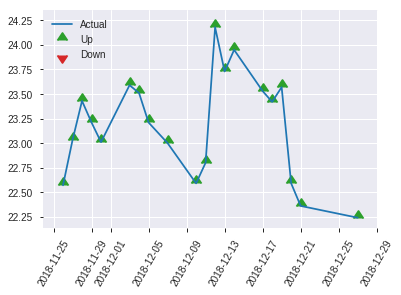


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2642347600063638
RMSE: 0.5140377029035553
LogLoss: 0.7222002130717227
Null degrees of freedom: 246
Residual degrees of freedom: 196
Null deviance: 345.4517445763613
Residual deviance: 356.76690525743106
AIC: 458.76690525743106
AUC: 0.47012867647058826
pr_auc: 0.44847124408101335
Gini: -0.059742647058823484
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5797938715952411: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    128  1        (128.0/128.0)
1      0    119  0        (0.0/119.0)
Total  0    247  0.5182   (128.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.579794     0.650273  246
max f2                       0.579794     0.82296   246
max f0point5                 0.585345     0.540284  233
max accuracy                 0.608444     0.522267  46
max precision                0.608444     0.510638  46
max recall                   0.579794     1         246
max specificity              0.641087     0.992188  0
max absolute_mcc             0.609965     0.129607  10
max min_per_class_accuracy   0.603095     0.462185  122
max mean_per_class_accuracy  0.608444     0.510997  46

Gains/Lift Table: Avg response rate: 48.18 %, avg score: 60.04 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0121457                   0.614807           0.691877  0.691877           0.333333         0.624933  0.333333                    0.624933            0.00840336      0.00840336                 -30.8123   -30.8123
    2        0.0202429                   0.61111            0         0.415126           0                0.612611  0.2                         0.620004            0               0.00840336                 -100       -58.4874
    3        0.0323887                   0.610191           0.691877  0.518908           0.333333         0.610509  0.25                        0.616443            0.00840336      0.0168067                  -30.8123   -48.1092
    4        0.0404858                   0.609979           0         0.415126           0                0.61012   0.2                         0.615179            0               0.0168067                  -100       -58.4874
    5        0.0526316                   0.609722           1.38375   0.638655           0.666667         0.609815  0.307692                    0.613941            0.0168067       0.0336134                  38.3754    -36.1345
    6        0.101215                    0.60931            0.691877  0.664202           0.333333         0.609517  0.32                        0.611817            0.0336134       0.0672269                  -30.8123   -33.5798
    7        0.149798                    0.608793           1.38375   0.89757            0.666667         0.609077  0.432432                    0.610929            0.0672269       0.134454                   38.3754    -10.243
    8        0.202429                    0.608332           1.27731   0.996303           0.615385         0.608573  0.48                        0.610316            0.0672269       0.201681                   27.7311    -0.369748
    9        0.299595                    0.607218           0.778361  0.925619           0.375            0.6078    0.445946                    0.6095              0.0756303       0.277311                   -22.1639   -7.43811
    10       0.40081                     0.604836           0.913277  0.922502           0.44             0.605917  0.444444                    0.608595            0.092437        0.369748                   -8.67227   -7.74977
    11       0.502024                    0.602995           0.913277  0.920642           0.44             0.603899  0.443548                    0.607648            0.092437        0.462185                   -8.67227   -7.93575
    12       0.59919                     0.600839           1.38375   0.995742           0.666667         0.601921  0.47973                     0.60672             0.134454        0.596639                   38.3754    -0.425846
    13       0.700405                    0.592971           0.996303  0.995823           0.48             0.595658  0.479769                    0.605121            0.10084         0.697479                   -0.369748  -0.417739
    14       0.797571                    0.590917           0.951331  0.990402           0.458333         0.592131  0.477157                    0.603539            0.092437        0.789916                   -4.86695   -0.959775
    15       0.898785                    0.588999           0.996303  0.991067           0.48             0.590381  0.477477                    0.602057            0.10084         0.890756                   -0.369748  -0.89333
    16       1                           0.579794           1.07933   1                  0.52             0.585277  0.481781  

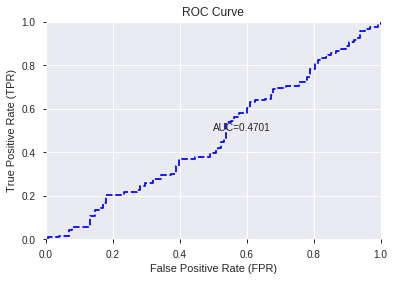

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


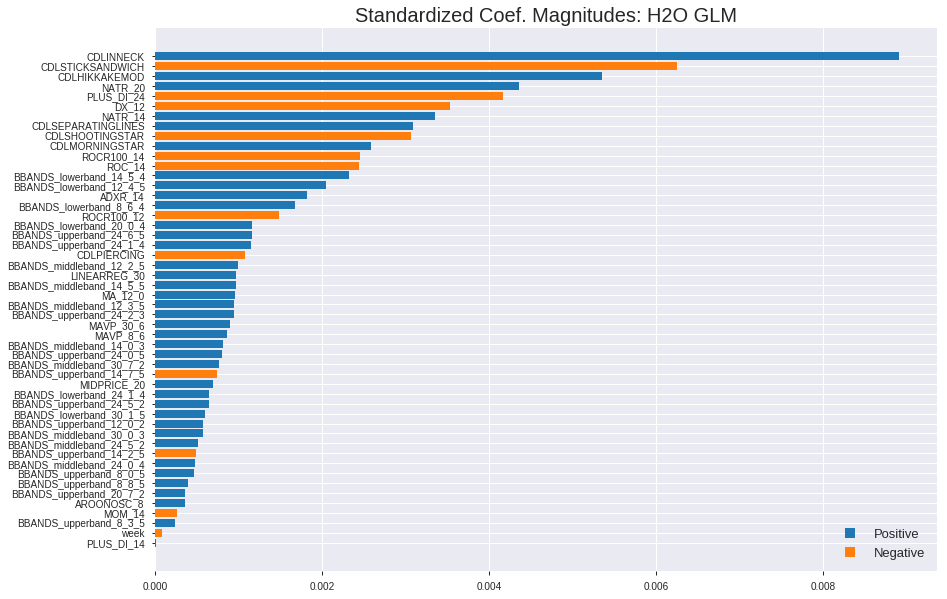

'log_likelihood'
--2019-08-26 14:02:45--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.105.251
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.105.251|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190826_140239_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190826_140239_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_18_sid_97b9',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_18_s

['CDLINNECK',
 'CDLSTICKSANDWICH',
 'CDLHIKKAKEMOD',
 'NATR_20',
 'PLUS_DI_24',
 'DX_12',
 'NATR_14',
 'CDLSEPARATINGLINES',
 'CDLSHOOTINGSTAR',
 'CDLMORNINGSTAR',
 'ROCR100_14',
 'ROC_14',
 'BBANDS_lowerband_14_5_4',
 'BBANDS_lowerband_12_4_5',
 'ADXR_14',
 'BBANDS_lowerband_8_6_4',
 'ROCR100_12',
 'BBANDS_lowerband_20_0_4',
 'BBANDS_upperband_24_6_5',
 'BBANDS_upperband_24_1_4',
 'CDLPIERCING',
 'BBANDS_middleband_12_2_5',
 'LINEARREG_30',
 'BBANDS_middleband_14_5_5',
 'MA_12_0',
 'BBANDS_middleband_12_3_5',
 'BBANDS_upperband_24_2_3',
 'MAVP_30_6',
 'MAVP_8_6',
 'BBANDS_middleband_14_0_3',
 'BBANDS_upperband_24_0_5',
 'BBANDS_middleband_30_7_2',
 'BBANDS_upperband_14_7_5',
 'MIDPRICE_20',
 'BBANDS_lowerband_24_1_4',
 'BBANDS_upperband_24_5_2',
 'BBANDS_lowerband_30_1_5',
 'BBANDS_upperband_12_0_2',
 'BBANDS_middleband_30_0_3',
 'BBANDS_middleband_24_5_2',
 'BBANDS_upperband_14_2_5',
 'BBANDS_middleband_24_0_4',
 'BBANDS_upperband_8_0_5',
 'BBANDS_upperband_8_8_5',
 'BBANDS_upperband

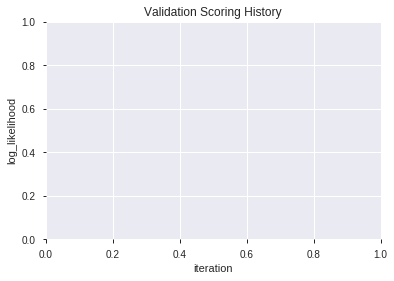

In [12]:
# GLM with top DeepLearning features
model_train(feature_name='DLF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190826_140256_model_5  0.536962  0.703510              0.488872  0.504691  0.254713
1               XGBoost_2_AutoML_20190826_140256  0.534500  0.695637              0.496094  0.501213  0.251214
2               XGBoost_1_AutoML_20190826_140256  0.528690  0.704817              0.488281  0.505693  0.255725
3  XGBoost_grid_1_AutoML_20190826_140256_model_7  0.526261  0.708704              0.496094  0.507587  0.257645
4  XGBoost_grid_1_AutoML_20190826_140256_model_3  0.526129  0.701923              0.500000  0.504255  0.254273
5  XGBoost_grid_1_AutoML_20190826_140256_model_1  0.519105  0.721602              0.500000  0.513678  0.263865
6  XGBoost_grid_1_AutoML_20190826_140256_model_2  0.515494  0.699782              0.500000  0.503258  0.253268
7  XGBoost_grid_1_AutoML_20190826_140256_model_4  0.503184  0.696201              0.500000  0.501512  0.251515
8               XGBoost_3_AutoML_20190826_140256  0.501313  0.714988              0.496094  0.510535  0.260646
9  XGBoost_grid_1_AutoML_20190826_140256_model_6  0.470949  0.712528              0.500000  0.509389  0.259478

variable  relative_importance  scaled_importance  percentage
0                 ROCR100_12          1092.647217           1.000000    0.052818
1                      DX_12          1045.457520           0.956812    0.050536
2     BBANDS_upperband_8_0_5           936.864014           0.857426    0.045287
3                    NATR_14           924.007629           0.845660    0.044666
4                 PLUS_DI_14           916.143738           0.838463    0.044286
5                     MOM_14           845.223999           0.773556    0.040857
6                       week           776.103149           0.710296    0.037516
7                     ROC_14           761.211792           0.696667    0.036796
8                    ADXR_14           758.684692           0.694355    0.036674
9     BBANDS_lowerband_8_6_4           726.171936           0.664599    0.035102
10                PLUS_DI_24           698.192200           0.638991    0.033750
11    BBANDS_upperband_8_3_5           688.863159           0.630453    0.033299
12                  MAVP_8_6           681.548523           0.623759    0.032945
13                AROONOSC_8           620.209167           0.567621    0.029980
14   BBANDS_lowerband_12_4_5           617.922180           0.565528    0.029870
15   BBANDS_lowerband_20_0_4           564.474182           0.516612    0.027286
16                   NATR_20           563.674255           0.515879    0.027247
17   BBANDS_upperband_14_2_5           557.121826           0.509883    0.026931
18   BBANDS_lowerband_30_1_5           515.170105           0.471488    0.024903
19    BBANDS_upperband_8_8_5           478.030670           0.437498    0.023108
20                ROCR100_14           454.536682           0.415996    0.021972
21   BBANDS_lowerband_14_5_4           450.695190           0.412480    0.021786
22   BBANDS_lowerband_24_1_4           442.740692           0.405200    0.021402
23   BBANDS_upperband_14_7_5           365.888947           0.334865    0.017687
24   BBANDS_upperband_12_0_2           355.813354           0.325643    0.017200
25   BBANDS_upperband_24_6_5           330.196136           0.302198    0.015961
26   BBANDS_upperband_24_0_5           319.297882           0.292224    0.015435
27  BBANDS_middleband_12_3_5           281.395966           0.257536    0.013602
28   BBANDS_upperband_24_1_4           280.268829           0.256504    0.013548
29  BBANDS_middleband_12_2_5           265.229492           0.242740    0.012821
30   BBANDS_upperband_20_7_2           262.775696           0.240495    0.012702
31                   MA_12_0           243.394989           0.222757    0.011765
32              LINEARREG_30           220.073837           0.201413    0.010638
33   BBANDS_upperband_24_2_3           212.242538           0.194246    0.010260
34   BBANDS_upperband_24_5_2           201.909561           0.184789    0.009760
35  BBANDS_middleband_24_0_4           199.404358           0.182497    0.009639
36  BBANDS_middleband_14_5_5           175.132614           0.160283    0.008466
37               MIDPRICE_20           170.538528           0.156078    0.008244
38  BBANDS_middleband_24_5_2           164.693787           0.150729    0.007961
39  BBANDS_middleband_30_7_2           147.782425           0.135252    0.007144
40  BBANDS_middleband_30_0_3           140.350784           0.128450    0.006784
41  BBANDS_middleband_14_0_3           125.551903           0.114906    0.006069
42                 MAVP_30_6            77.864853           0.071263    0.003764
43           CDLSHOOTINGSTAR            21.517475           0.019693    0.001040
44                 CDLINNECK             3.929072           0.003596    0.000190
45          CDLSTICKSANDWICH             3.300783           0.003021    0.000160
46            CDLMORNINGSTAR             2.943591           0.002694    0.000142

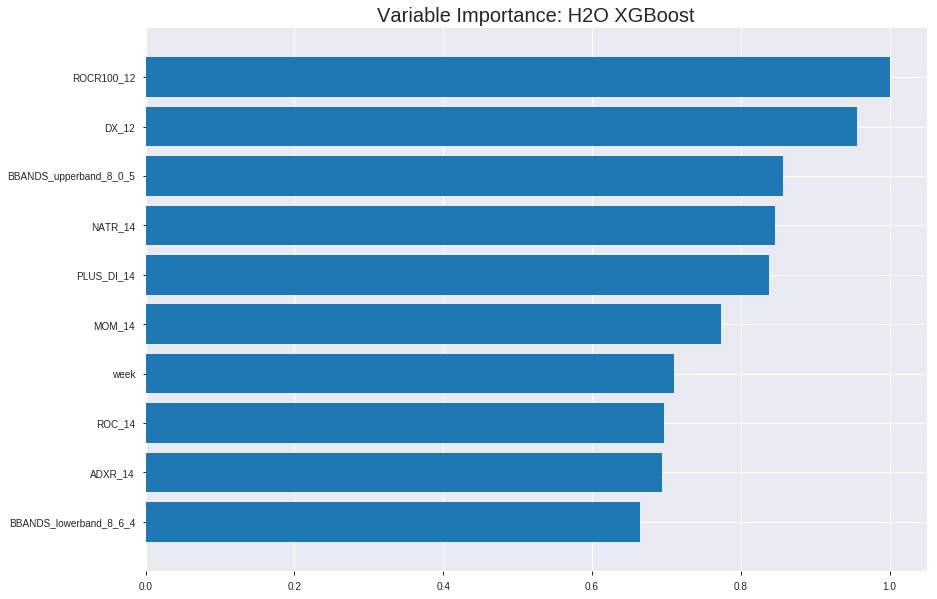

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190826_140256_model_5


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.07290737338342557
RMSE: 0.27001365406850364
LogLoss: 0.30306668663864483
Mean Per-Class Error: 0.0026881720430107503
AUC: 0.9998852775062452
pr_auc: 0.9977536122469051
Gini: 0.9997705550124905
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.524910569190979: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      792  0    0        (0.0/792.0)
1      5    925  0.0054   (5.0/930.0)
Total  797  925  0.0029   (5.0/1722.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.524911     0.997305  188
max f2                       0.524911     0.995694  188
max f0point5                 0.524911     0.99892   188
max accuracy                 0.524911     0.997096  188
max precision                0.916747     1         0
max recall                   0.44929      1         207
max specificity              0.916747     1         0
max absolute_mcc             0.524911     0.994175  188
max min_per_class_accuracy   0.524911     0.994624  188
max mean_per_class_accuracy  0.524911     0.997312  188

Gains/Lift Table: Avg response rate: 54.01 %, avg score: 53.77 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010453                    0.894948           1.85161   1.85161            1                0.906372  1                           0.906372            0.0193548       0.0193548                  85.1613   85.1613
    2        0.0203252                   0.877957           1.85161   1.85161            1                0.885452  1                           0.896211            0.0182796       0.0376344                  85.1613   85.1613
    3        0.0301974                   0.867268           1.85161   1.85161            1                0.872338  1                           0.888406            0.0182796       0.055914                   85.1613   85.1613
    4        0.0400697                   0.859557           1.85161   1.85161            1                0.863521  1                           0.882275            0.0182796       0.0741935                  85.1613   85.1613
    5        0.0505226                   0.854341           1.85161   1.85161            1                0.857098  1                           0.877066            0.0193548       0.0935484                  85.1613   85.1613
    6        0.100465                    0.831528           1.85161   1.85161            1                0.841533  1                           0.859402            0.0924731       0.186022                   85.1613   85.1613
    7        0.150407                    0.813482           1.85161   1.85161            1                0.821911  1                           0.846953            0.0924731       0.278495                   85.1613   85.1613
    8        0.200348                    0.796771           1.85161   1.85161            1                0.805499  1                           0.83662             0.0924731       0.370968                   85.1613   85.1613
    9        0.300232                    0.761519           1.85161   1.85161            1                0.778391  1                           0.817248            0.184946        0.555914                   85.1613   85.1613
    10       0.400116                    0.711362           1.85161   1.85161            1                0.737521  1                           0.797345            0.184946        0.74086                    85.1613   85.1613
    11       0.5                         0.641701           1.85161   1.85161            1                0.679011  1                           0.773706            0.184946        0.925806                   85.1613   85.1613
    12       0.599884                    0.380137           0.742798  1.66699            0.401163         0.494284  0.90029                     0.727181            0.0741935       1                          -25.7202  66.6989
    13       0.699768                    0.307063           0         1.42905            0                0.342726  0.771784                    0.672304            0               1                          -100      42.9046
    14       0.799652                    0.255092           0         1.25054            0                0.28056   0.675381                    0.623372            0               1                          -100      25.0545
    15       0.899535                    0.201213           0         1.11168            0                0.227555  0.600387                    0.57942             0               1                          -100      11.1685
    16       1                           0.0852871          0         1                  0                0.163728  0.54007                     0.537658         



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.257132711716517
RMSE: 0.5070825492131602
LogLoss: 0.7085853508975887
Mean Per-Class Error: 0.4574688273007219
AUC: 0.5223299173776229
pr_auc: 0.6151290276559095
Gini: 0.04465983475524582
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.23261158168315887: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    213  1        (213.0/213.0)
1      0    279  0        (0.0/279.0)
Total  0    492  0.4329   (213.0/492.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.232612     0.723735  399
max f2                       0.232612     0.867537  399
max f0point5                 0.232612     0.620828  399
max accuracy                 0.232612     0.567073  399
max precision                0.760934     1         0
max recall                   0.232612     1         399
max specificity              0.760934     1         0
max absolute_mcc             0.678628     0.159047  27
max min_per_class_accuracy   0.524728     0.498208  192
max mean_per_class_accuracy  0.636707     0.542531  54

Gains/Lift Table: Avg response rate: 56.71 %, avg score: 50.99 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101626                   0.727604           1.05806   1.05806            0.6              0.744384  0.6                         0.744384            0.0107527       0.0107527                  5.80645   5.80645
    2        0.0203252                   0.723118           1.76344   1.41075            1                0.724772  0.8                         0.734578            0.0179211       0.0286738                  76.3441   41.0753
    3        0.0304878                   0.712181           1.76344   1.52832            1                0.72032   0.866667                    0.729825            0.0179211       0.046595                   76.3441   52.8315
    4        0.0406504                   0.690763           1.76344   1.5871             1                0.700008  0.9                         0.722371            0.0179211       0.0645161                  76.3441   58.7097
    5        0.050813                    0.685446           1.05806   1.48129            0.6              0.688011  0.84                        0.715499            0.0107527       0.0752688                  5.80645   48.129
    6        0.101626                    0.649016           1.1286    1.30495            0.64             0.666435  0.74                        0.690967            0.0573477       0.132616                   12.8602   30.4946
    7        0.150407                    0.630843           1.02867   1.21534            0.583333         0.63854   0.689189                    0.673964            0.0501792       0.182796                   2.86738   21.5344
    8        0.20122                     0.614875           0.775914  1.10438            0.44             0.621699  0.626263                    0.660765            0.0394265       0.222222                   -22.4086  10.4377
    9        0.300813                    0.579512           0.899715  1.03662            0.510204         0.596858  0.587838                    0.639607            0.0896057       0.311828                   -10.0285  3.66173
    10       0.400407                    0.550048           0.899715  1.00257            0.510204         0.565497  0.568528                    0.621173            0.0896057       0.401434                   -10.0285  0.256536
    11       0.5                         0.523241           0.971692  0.996416           0.55102          0.535656  0.565041                    0.604139            0.0967742       0.498208                   -2.83081  -0.358423
    12       0.599593                    0.489193           1.11565   1.01622            0.632653         0.506988  0.576271                    0.588002            0.111111        0.609319                   11.5646   1.62202
    13       0.699187                    0.446078           1.07966   1.02526            0.612245         0.470324  0.581395                    0.57124             0.107527        0.716846                   7.96577   2.52563
    14       0.79878                     0.399666           0.827738  1.00063            0.469388         0.424338  0.56743                     0.552924            0.0824373       0.799283                   -17.2262  0.0629292
    15       0.898374                    0.348477           0.935703  0.993432           0.530612         0.375759  0.563348                    0.533284            0.09319         0.892473                   -6.42967  -0.656838
    16       1                           0.232612           1.05806   1                  0.6              0.302861  0.567073                    0.509867   


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-26 14:03:11  3.175 sec   0                  0.5              0.693147            0.5             0                  1                0.45993                          0.5                0.693147              0.5               0                    1                  0.432927
    2019-08-26 14:03:11  3.434 sec   5                  0.464819         0.624871            0.922976        0.930357           1.85161          0.159698                         0.503712           0.700674              0.511182          0.573588             0.66129            0.432927
    2019-08-26 14:03:11  3.650 sec   10                 0.419954         0.543274            0.984354        0.98587            1.85161          0.0592334                        0.501934           0.69713               0.516137          0.603669             1.76344            0.432927
    2019-08-26 14:03:12  3.886 sec   15                 0.389555         0.490847            0.993895        0.993936           1.85161          0.0406504                        0.503199           0.699712              0.513512          0.594952             1.76344            0.430894
    2019-08-26 14:03:12  4.051 sec   20                 0.368116         0.45515             0.996854        0.995261           1.85161          0.0261324                        0.50335            0.700104              0.526957          0.602358             1.05806            0.432927
    2019-08-26 14:03:12  4.230 sec   25                 0.3472           0.420992            0.998385        0.997602           1.85161          0.0197445                        0.503652           0.700835              0.522624          0.59827              1.05806            0.430894
    2019-08-26 14:03:12  4.458 sec   30                 0.32913          0.392176            0.999116        0.998201           1.85161          0.014518                         0.504611           0.702866              0.514581          0.592286             1.05806            0.430894
    2019-08-26 14:03:13  4.656 sec   35                 0.311865         0.365333            0.999432        0.996312           1.85161          0.00929152                       0.505654           0.705359              0.519713          0.596989             1.05806            0.432927
    2019-08-26 14:03:13  4.869 sec   40                 0.296615         0.342224            0.999605        0.997526           1.85161          0.00638792                       0.506286           0.706774              0.519133          0.60331              1.05806            0.432927
    2019-08-26 14:03:13  5.071 sec   45                 0.283514         0.322667            0.999832        0.998783           1.85161          0.00638792                       0.506158           0.706626              0.522456          0.609453             1.05806            0.432927
    2019-08-26 14:03:13  5.286 sec   50                 0.270014         0.303067            0.999885        0.997754           1.85161          0.0029036                        0.507083           0.708585              0.52233           0.615129             1.05806            0.432927

Variable Importances: 


variable                relative_importance    scaled_importance      percentage
----------------------  ---------------------  ---------------------  ----------------------
ROCR100_12              1092.647216796875      1.0                    0.05281757045408081
DX_12                   1045.45751953125       0.9568115888273958     0.05053646350417198
BBANDS_upperband_8_0_5  936.864013671875       0.8574258912390015     0.045287152419668984
NATR_14                 924.0076293945312      0.8456596193081283     0.04466568652297822
PLUS_DI_14              916.1437377929688      0.8384625190175005     0.0442855531713129
---                     ---                    ---                    ---
MAVP_30_6               77.86485290527344      0.07126257378253922    0.0037639160114983972
CDLSHOOTINGSTAR         21.517475128173828     0.019692975735803264   0.0010401351333762926
CDLINNECK               3.929072380065918      0.0035959203663045976  0.00018992777729455714
CDLSTICKSANDWICH        3.300783157348633      0.0030209047408961223  0.00015955684898734767
CDLMORNINGSTAR          2.9435911178588867     0.0026939995568634714  0.00014229051139789888


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.562753036437247)

('F1', 0.6518105849582173)

('auc', 0.5369616596638656)

('logloss', 0.7035101441651849)

('mean_per_class_error', 0.4463957457983193)

('rmse', 0.504690827812561)

('mse', 0.25471283167812814)

xgboost prediction progress: |████████████████████████████████████████████| 100%


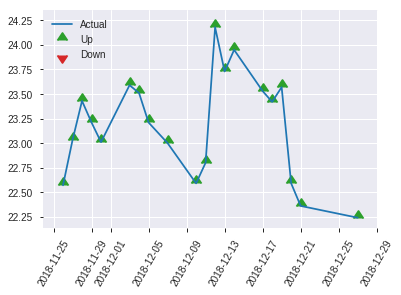


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.25471283167812814
RMSE: 0.504690827812561
LogLoss: 0.7035101441651849
Mean Per-Class Error: 0.4463957457983193
AUC: 0.5369616596638656
pr_auc: 0.5106377254654813
Gini: 0.07392331932773111
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3122812807559967: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      5    123  0.9609   (123.0/128.0)
1      2    117  0.0168   (2.0/119.0)
Total  7    240  0.5061   (125.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.312281     0.651811  239
max f2                       0.231699     0.82296   246
max f0point5                 0.396814     0.543131  204
max accuracy                 0.583436     0.562753  60
max precision                0.73909      1         0
max recall                   0.231699     1         246
max specificity              0.73909      1         0
max absolute_mcc             0.583436     0.124219  60
max min_per_class_accuracy   0.513867     0.537815  122
max mean_per_class_accuracy  0.583436     0.553604  60

Gains/Lift Table: Avg response rate: 48.18 %, avg score: 50.73 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0121457                   0.716917           0.691877  0.691877           0.333333         0.730803  0.333333                    0.730803            0.00840336      0.00840336                 -30.8123   -30.8123
    2        0.0202429                   0.707583           2.07563   1.24538            1                0.714458  0.6                         0.724265            0.0168067       0.0252101                  107.563    24.5378
    3        0.0323887                   0.699387           0         0.778361           0                0.704583  0.375                       0.716884            0               0.0252101                  -100       -22.1639
    4        0.0404858                   0.697062           1.03782   0.830252           0.5              0.698106  0.4                         0.713129            0.00840336      0.0336134                  3.78151    -16.9748
    5        0.0526316                   0.686124           2.07563   1.11765            1                0.693181  0.538462                    0.708525            0.0252101       0.0588235                  107.563    11.7647
    6        0.101215                    0.644316           1.21078   1.16235            0.583333         0.660587  0.56                        0.685515            0.0588235       0.117647                   21.0784    16.2353
    7        0.149798                    0.612933           1.21078   1.17806            0.583333         0.629793  0.567568                    0.667443            0.0588235       0.176471                   21.0784    17.806
    8        0.202429                    0.595804           1.11765   1.16235            0.538462         0.603935  0.56                        0.650931            0.0588235       0.235294                   11.7647    16.2353
    9        0.299595                    0.563852           0.951331  1.09391            0.458333         0.580969  0.527027                    0.628241            0.092437        0.327731                   -4.86695   9.39132
    10       0.40081                     0.537201           0.913277  1.0483             0.44             0.549449  0.505051                    0.608344            0.092437        0.420168                   -8.67227   4.82981
    11       0.502024                    0.512566           1.16235   1.07129            0.56             0.522828  0.516129                    0.591103            0.117647        0.537815                   16.2353    7.1293
    12       0.59919                     0.488174           0.778361  1.02379            0.375            0.499335  0.493243                    0.576221            0.0756303       0.613445                   -22.1639   2.37906
    13       0.700405                    0.457334           0.996303  1.01982            0.48             0.472178  0.491329                    0.561186            0.10084         0.714286                   -0.369748  1.98183
    14       0.797571                    0.405802           1.03782   1.02201            0.5              0.435757  0.492386                    0.545905            0.10084         0.815126                   3.78151    2.20108
    15       0.898785                    0.36091            0.830252  1.00042            0.4              0.387815  0.481982                    0.528102            0.0840336       0.89916                    -16.9748   0.0416383
    16       1                           0.231699           0.996303  1                  0.48             0.322569  0.481781                 

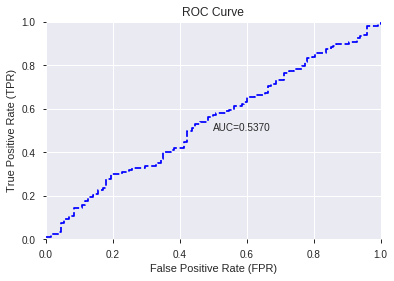

This function is available for GLM models only


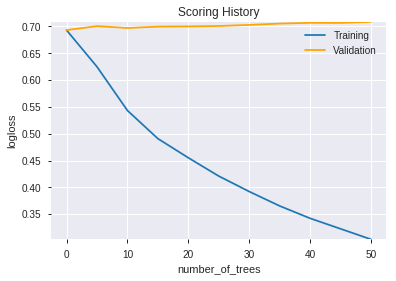

--2019-08-26 14:03:20--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.187.59
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.187.59|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190826_140256_model_5',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190826_140256_model_5',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_26_sid_97b9',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['ROCR100_12',
 'DX_12',
 'BBANDS_upperband_8_0_5',
 'NATR_14',
 'PLUS_DI_14',
 'MOM_14',
 'week',
 'ROC_14',
 'ADXR_14',
 'BBANDS_lowerband_8_6_4',
 'PLUS_DI_24',
 'BBANDS_upperband_8_3_5',
 'MAVP_8_6',
 'AROONOSC_8',
 'BBANDS_lowerband_12_4_5',
 'BBANDS_lowerband_20_0_4',
 'NATR_20',
 'BBANDS_upperband_14_2_5',
 'BBANDS_lowerband_30_1_5',
 'BBANDS_upperband_8_8_5',
 'ROCR100_14',
 'BBANDS_lowerband_14_5_4',
 'BBANDS_lowerband_24_1_4',
 'BBANDS_upperband_14_7_5',
 'BBANDS_upperband_12_0_2',
 'BBANDS_upperband_24_6_5',
 'BBANDS_upperband_24_0_5',
 'BBANDS_middleband_12_3_5',
 'BBANDS_upperband_24_1_4',
 'BBANDS_middleband_12_2_5',
 'BBANDS_upperband_20_7_2',
 'MA_12_0',
 'LINEARREG_30',
 'BBANDS_upperband_24_2_3',
 'BBANDS_upperband_24_5_2',
 'BBANDS_middleband_24_0_4',
 'BBANDS_middleband_14_5_5',
 'MIDPRICE_20',
 'BBANDS_middleband_24_5_2',
 'BBANDS_middleband_30_7_2',
 'BBANDS_middleband_30_0_3',
 'BBANDS_middleband_14_0_3',
 'MAVP_30_6',
 'CDLSHOOTINGSTAR',
 'CDLINNECK',
 'CDLSTICK

In [13]:
# XGBoost with top DeepLearning features
model_train(feature_name='DLF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc    logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190826_140333_model_1  0.490415  14.279517                   0.5  0.693979  0.481606

variable  relative_importance  scaled_importance    percentage
0                      BETA_12         1.042013e-02           1.000000  1.160401e-02
1          CDLGAPSIDESIDEWHITE         1.030562e-02           0.989011  1.147649e-02
2                          OBV         9.987856e-03           0.958515  1.112262e-02
3                  CDLHIGHWAVE         9.659261e-03           0.926981  1.075669e-02
4                          day         9.238971e-03           0.886646  1.028865e-02
...                        ...                  ...                ...           ...
1035    BBANDS_upperband_8_3_4         2.376689e-06           0.000228  2.646715e-06
1036  BBANDS_middleband_14_3_4         1.977906e-06           0.000190  2.202625e-06
1037                 MAVP_24_2         1.580899e-06           0.000152  1.760512e-06
1038                 MAVP_24_6         1.170843e-06           0.000112  1.303868e-06
1039   BBANDS_upperband_24_7_2         5.950139e-07           0.000057  6.626160e-07

[1040 rows x 4 columns]

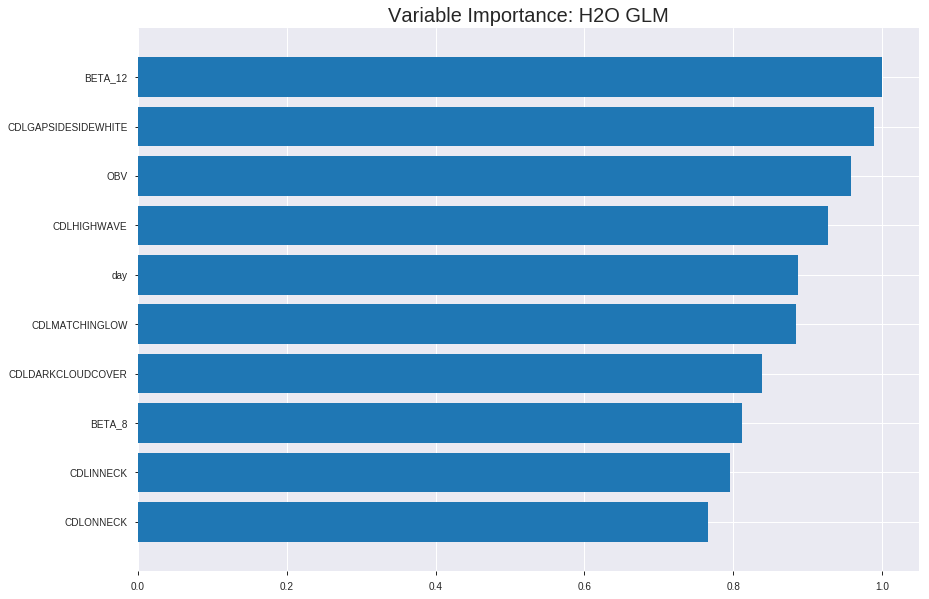

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190826_140333_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24467292908015342
RMSE: 0.4946442449681927
LogLoss: 0.6824255984543578
Null degrees of freedom: 1721
Residual degrees of freedom: 681
Null deviance: 2376.1277882295276
Residual deviance: 2350.273761076808
AIC: 4432.273761076808
AUC: 0.6089598946453786
pr_auc: 0.632664266610304
Gini: 0.21791978929075717
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5059906878999328: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      65   727   0.9179   (727.0/792.0)
1      26   904   0.028    (26.0/930.0)
Total  91   1631  0.4373   (753.0/1722.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.505991     0.705974  351
max f2                       0.478302     0.855251  394
max f0point5                 0.526544     0.619381  276
max accuracy                 0.526544     0.587108  276
max precision                0.624019     1         0
max recall                   0.478302     1         394
max specificity              0.624019     1         0
max absolute_mcc             0.543932     0.170679  186
max min_per_class_accuracy   0.539048     0.577419  213
max mean_per_class_accuracy  0.543932     0.58427   186

Gains/Lift Table: Avg response rate: 54.01 %, avg score: 54.01 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010453                    0.597829           1.64588   1.64588            0.888889         0.606678  0.888889                    0.606678            0.0172043       0.0172043                  64.5878   64.5878
    2        0.0203252                   0.590751           1.08918   1.37548            0.588235         0.59351   0.742857                    0.600282            0.0107527       0.027957                   8.91841   37.5484
    3        0.0301974                   0.58601            1.41594   1.38871            0.764706         0.587811  0.75                        0.596205            0.0139785       0.0419355                  41.5939   38.871
    4        0.0400697                   0.58135            1.30702   1.36858            0.705882         0.583104  0.73913                     0.592977            0.0129032       0.0548387                  30.7021   36.8583
    5        0.0505226                   0.578386           1.02867   1.29826            0.555556         0.580095  0.701149                    0.590312            0.0107527       0.0655914                  2.86738   29.8257
    6        0.100465                    0.568916           1.22723   1.26295            0.662791         0.572413  0.682081                    0.581414            0.0612903       0.126882                   22.7232   26.295
    7        0.150407                    0.561251           1.24876   1.25824            0.674419         0.56525   0.679537                    0.576047            0.0623656       0.189247                   24.8762   25.8239
    8        0.200348                    0.557509           1.29182   1.26661            0.697674         0.559314  0.684058                    0.571876            0.0645161       0.253763                   29.1823   26.6611
    9        0.300232                    0.550363           1.09805   1.21053            0.593023         0.553609  0.653772                    0.565799            0.109677        0.363441                   9.80495   21.0532
    10       0.400116                    0.544272           1.10881   1.18514            0.598837         0.54723   0.640058                    0.561163            0.110753        0.474194                   10.8815   18.514
    11       0.5                         0.539282           0.958102  1.13978            0.517442         0.541684  0.615563                    0.557272            0.0956989       0.569892                   -4.1898   13.9785
    12       0.599884                    0.534221           1.00116   1.1167             0.540698         0.536733  0.603098                    0.553852            0.1             0.669892                   0.116279  11.6704
    13       0.699768                    0.528527           0.904276  1.08638            0.488372         0.531614  0.586722                    0.550678            0.0903226       0.760215                   -9.57239  8.6382
    14       0.799652                    0.522084           0.882746  1.06095            0.476744         0.525519  0.572985                    0.547535            0.088172        0.848387                   -11.7254  6.0946
    15       0.899535                    0.513011           0.807389  1.03279            0.436047         0.518208  0.557779                    0.544279            0.0806452       0.929032                   -19.2611  3.27912
    16       1                           0.46836            0.706396  1                  0.381503         0.502381  0.54007                     0.54007             0.



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.265392047145964
RMSE: 0.5151621561663512
LogLoss: 0.7797918381571665
Null degrees of freedom: 491
Residual degrees of freedom: -549
Null deviance: 674.6256660447343
Residual deviance: 767.3151687466518
AIC: 2849.3151687466516
AUC: 0.47571810793073854
pr_auc: 0.5491946049367714
Gini: -0.048563784138522914
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.0011855611815654104: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      3    210  0.9859   (210.0/213.0)
1      0    279  0        (0.0/279.0)
Total  3    489  0.4268   (210.0/492.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.00118556   0.726562  397
max f2                       0.00118556   0.869159  397
max f0point5                 0.00118556   0.624161  397
max accuracy                 0.00118556   0.573171  397
max precision                0.628486     0.75      3
max recall                   0.00118556   1         397
max specificity              0.63225      0.995305  0
max absolute_mcc             0.581348     0.106986  137
max min_per_class_accuracy   0.570377     0.478873  190
max mean_per_class_accuracy  0.558959     0.513958  244

Gains/Lift Table: Avg response rate: 56.71 %, avg score: 53.17 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101626                   0.625595           1.05806   1.05806            0.6              0.629594  0.6                         0.629594            0.0107527       0.0107527                  5.80645   5.80645
    2        0.0203252                   0.618052           1.05806   1.05806            0.6              0.62127   0.6                         0.625432            0.0107527       0.0215054                  5.80645   5.80645
    3        0.0304878                   0.615957           1.05806   1.05806            0.6              0.616852  0.6                         0.622572            0.0107527       0.0322581                  5.80645   5.80645
    4        0.0406504                   0.613282           1.41075   1.14624            0.8              0.615047  0.65                        0.620691            0.0143369       0.046595                   41.0753   14.6237
    5        0.050813                    0.610422           0.352688  0.987527           0.2              0.611905  0.56                        0.618934            0.00358423      0.0501792                  -64.7312  -1.24731
    6        0.101626                    0.603633           0.775914  0.88172            0.44             0.60694   0.5                         0.612937            0.0394265       0.0896057                  -22.4086  -11.828
    7        0.150407                    0.598263           0.955197  0.905551           0.541667         0.600765  0.513514                    0.608989            0.046595        0.136201                   -4.48029  -9.44493
    8        0.20122                     0.593358           1.19914   0.979689           0.68             0.5959    0.555556                    0.605684            0.0609319       0.197133                   19.914    -2.03106
    9        0.300813                    0.585128           0.683783  0.88172            0.387755         0.589111  0.5                         0.600197            0.0681004       0.265233                   -31.6217  -11.828
    10       0.400407                    0.577204           1.04367   0.922002           0.591837         0.580942  0.522843                    0.595408            0.103943        0.369176                   4.36691   -7.79979
    11       0.5                         0.57026            1.15163   0.967742           0.653061         0.573811  0.54878                     0.591106            0.114695        0.483871                   15.1635   -3.22581
    12       0.599593                    0.562577           1.22361   1.01024            0.693878         0.567166  0.572881                    0.58713             0.121864        0.605735                   22.3612   1.02424
    13       0.699187                    0.55321            0.827738  0.984246           0.469388         0.557781  0.55814                     0.582949            0.0824373       0.688172                   -17.2262  -1.57539
    14       0.79878                     0.539225           1.00768   0.987168           0.571429         0.546614  0.559796                    0.578419            0.100358        0.78853                    0.768049  -1.28321
    15       0.898374                    0.510382           1.07966   0.997421           0.612245         0.529187  0.565611                    0.572961            0.107527        0.896057                   7.96577   -0.25787
    16       1                           0.00068569         1.0228    1                  0.58             0.166661  0.567073                    0.53167  


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-26 14:03:36  0.000 sec   2            2.9       1041          1.36799           1.55996
    2019-08-26 14:03:38  1.852 sec   4            2.1       1041          1.36485           1.55958
    2019-08-26 14:03:40  3.851 sec   6            1.5       1041          1.36115           3.53202
    2019-08-26 14:03:42  5.732 sec   8            1.1       1041          1.35686           6.66102
    2019-08-26 14:03:44  7.617 sec   10           0.82      1041          1.35195           11.4763
    2019-08-26 14:03:46  9.574 sec   12           0.6       1041          1.34651           18.3288
    2019-08-26 14:03:48  11.454 sec  14           0.43      1041          1.34062           27.476

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5465587044534413)

('F1', 0.6502732240437158)

('auc', 0.49041491596638653)

('logloss', 14.279517241128547)

('mean_per_class_error', 0.46999737394957986)

('rmse', 0.6939786833485675)

('mse', 0.48160641294221124)

glm prediction progress: |████████████████████████████████████████████████| 100%


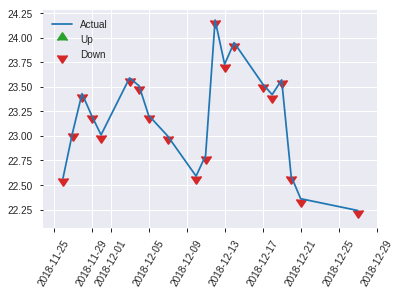


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.48160641294221124
RMSE: 0.6939786833485675
LogLoss: 14.279517241128547
Null degrees of freedom: 246
Residual degrees of freedom: -794
Null deviance: 345.4517445763613
Residual deviance: 103961.13774984881
AIC: 106043.13774984881
AUC: 0.49041491596638653
pr_auc: 0.49132048947410134
Gini: -0.019170168067226934
Confusion Matrix (Act/Pred) for max f1 @ threshold = 6.228345205970866e-64: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    128  1        (128.0/128.0)
1      0    119  0        (0.0/119.0)
Total  0    247  0.5182   (128.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       6.22835e-64  0.650273  78
max f2                       6.22835e-64  0.82296   78
max f0point5                 6.22835e-64  0.537489  78
max accuracy                 0.000180153  0.546559  10
max precision                0.0166705    1         0
max recall                   6.22835e-64  1         78
max specificity              0.0166705    1         0
max absolute_mcc             0.000180153  0.14535   10
max min_per_class_accuracy   3.53885e-21  0.294118  71
max mean_per_class_accuracy  0.000180153  0.530003  10

Gains/Lift Table: Avg response rate: 48.18 %, avg score:  0.01 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score         cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ------------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0121457                   0.00145783         1.38375   1.38375            0.666667         0.00762908    0.666667                    0.00762908          0.0168067       0.0168067                  38.3754   38.3754
    2        0.0202429                   0.000473021        2.07563   1.6605             1                0.000886124   0.8                         0.0049319           0.0168067       0.0336134                  107.563   66.0504
    3        0.0323887                   0.000320032        1.38375   1.55672            0.666667         0.000399201   0.75                        0.00323214          0.0168067       0.0504202                  38.3754   55.6723
    4        0.0404858                   0.000183821        2.07563   1.6605             1                0.000259809   0.8                         0.00263767          0.0168067       0.0672269                  107.563   66.0504
    5        0.0526316                   0.000111582        0.691877  1.43697            0.333333         0.000151836   0.692308                    0.00206402          0.00840336      0.0756303                  -30.8123  43.6975
    6        0.101215                    5.89583e-06        0.691877  1.07933            0.333333         3.71193e-05   0.52                        0.00109111          0.0336134       0.109244                   -30.8123  7.93277
    7        0.149798                    6.04924e-08        0.691877  0.953668           0.333333         1.49963e-06   0.459459                    0.00073772          0.0336134       0.142857                   -30.8123  -4.6332
    8        0.202429                    3.15983e-10        1.27731   1.03782            0.615385         1.30231e-08   0.5                         0.000545916         0.0672269       0.210084                   27.7311   3.78151
    9        0.299595                    4.24692e-26        0.864846  0.981717           0.416667         1.86506e-12   0.472973                    0.000368862         0.0840336       0.294118                   -13.5154  -1.8283
    10       0.40081                     2.2031e-201        1.24538   1.0483             0.6              3.05602e-28   0.505051                    0.000275715         0.12605         0.420168                   24.5378   4.82981
    11       0.502024                    8.55066e-277       1.24538   1.08803            0.6              3.48925e-204  0.524194                    0.000220128         0.12605         0.546218                   24.5378   8.8032
    12       1                           0                  0.911252  1                  0.439024         1.26331e-281  0.481781                    0.000110509         0.453782        1                          -8.87477  0

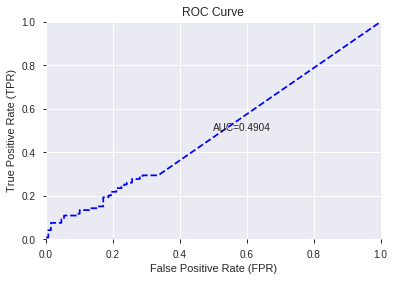

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


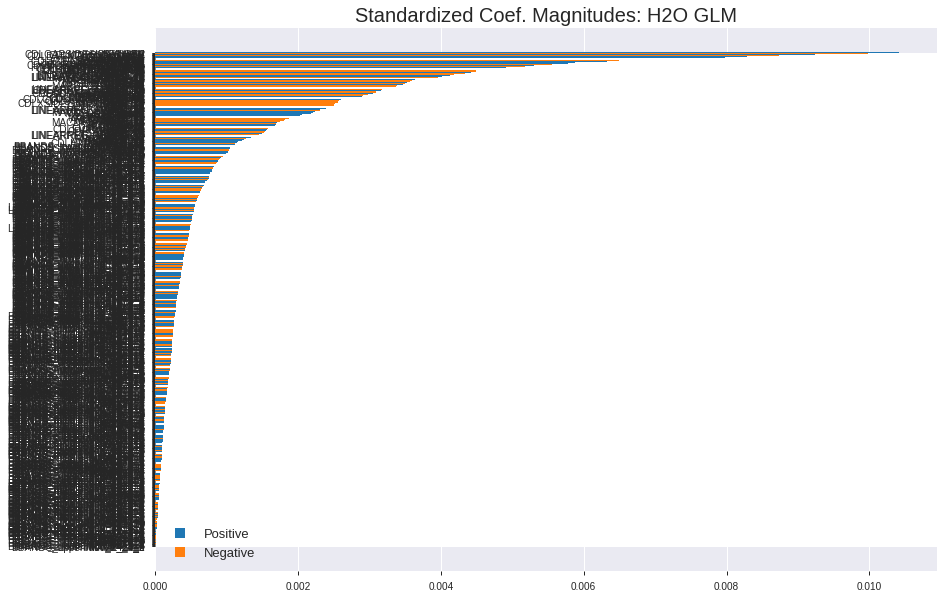

'log_likelihood'
--2019-08-26 14:04:08--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.236.243
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.236.243|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190826_140333_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190826_140333_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_34_sid_97b9',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_34_s

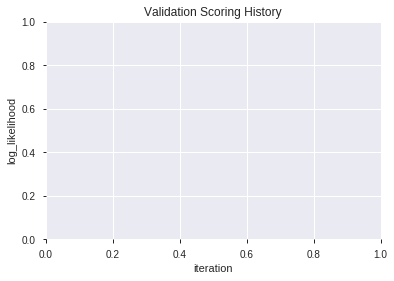

In [14]:
# GLM
glm_features = model_train(feature_name='All',model_algo="GLM")

In [15]:
# DeepLearning with top GLM features
model_train(feature_name='GLMF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

[]

In [16]:
# GLM with top GLM features
model_train(feature_name='GLMF',model_algo="GLM",features_list = features_list[:model_selected_features])

[]

In [17]:
# XGBoost with top GLM features
model_train(feature_name='GLMF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190826_140423_model_5  0.570772  0.692306              0.481355  0.499537  0.249537
1  XGBoost_grid_1_AutoML_20190826_140423_model_2  0.565060  0.694644              0.500000  0.500692  0.250693
2               XGBoost_1_AutoML_20190826_140423  0.550945  0.694973              0.496094  0.500707  0.250707
3  XGBoost_grid_1_AutoML_20190826_140423_model_4  0.543789  0.694625              0.500000  0.500663  0.250664
4  XGBoost_grid_1_AutoML_20190826_140423_model_3  0.541492  0.693504              0.488577  0.500219  0.250219
5  XGBoost_grid_1_AutoML_20190826_140423_model_6  0.539062  0.707548              0.500000  0.506631  0.256675
6  XGBoost_grid_1_AutoML_20190826_140423_model_7  0.532891  0.703656              0.492188  0.504901  0.254925
7               XGBoost_2_AutoML_20190826_140423  0.532235  0.699796              0.492188  0.503231  0.253241
8               XGBoost_3_AutoML_20190826_140423  0.511489  0.699768              0.466912  0.503279  0.253290
9  XGBoost_grid_1_AutoML_20190826_140423_model_1  0.505679  0.710172              0.500000  0.508204  0.258272

variable  relative_importance  scaled_importance  percentage
0                        day           460.891968           1.000000    0.019297
1                     Volume           410.266296           0.890157    0.017177
2                        BOP           370.644531           0.804190    0.015518
3                  dayofyear           354.695984           0.769586    0.014850
4                       Open           341.389221           0.740714    0.014293
..                       ...                  ...                ...         ...
615  BBANDS_lowerband_12_7_4             1.048416           0.002275    0.000044
616  BBANDS_lowerband_24_6_4             1.011423           0.002194    0.000042
617  BBANDS_lowerband_24_5_4             0.578921           0.001256    0.000024
618  BBANDS_upperband_14_0_3             0.500198           0.001085    0.000021
619                  quarter             0.351249           0.000762    0.000015

[620 rows x 4 columns]

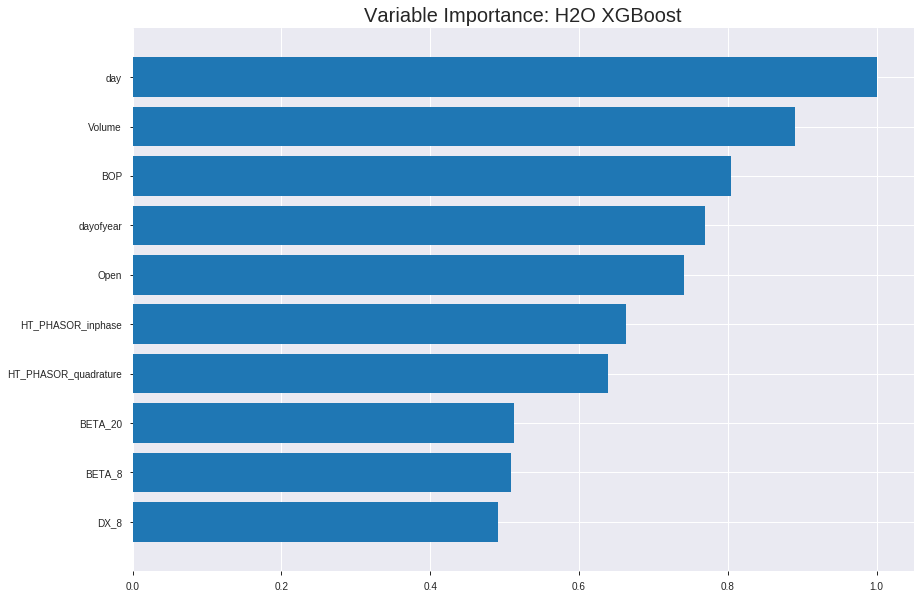

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190826_140423_model_5


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.03826251249074569
RMSE: 0.1956080583481818
LogLoss: 0.20771507450740703
Mean Per-Class Error: 0.0
AUC: 1.0
pr_auc: 0.9989247311827957
Gini: 1.0
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4944419860839844: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      792  0    0        (0.0/792.0)
1      0    930  0        (0.0/930.0)
Total  792  930  0        (0.0/1722.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value    idx
---------------------------  -----------  -------  -----
max f1                       0.494442     1        205
max f2                       0.494442     1        205
max f0point5                 0.494442     1        205
max accuracy                 0.494442     1        205
max precision                0.947091     1        0
max recall                   0.494442     1        205
max specificity              0.947091     1        0
max absolute_mcc             0.494442     1        205
max min_per_class_accuracy   0.494442     1        205
max mean_per_class_accuracy  0.494442     1        205

Gains/Lift Table: Avg response rate: 54.01 %, avg score: 53.69 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010453                    0.918634           1.85161   1.85161            1                0.927994  1                           0.927994            0.0193548       0.0193548                  85.1613   85.1613
    2        0.0203252                   0.910297           1.85161   1.85161            1                0.913741  1                           0.921071            0.0182796       0.0376344                  85.1613   85.1613
    3        0.0301974                   0.904715           1.85161   1.85161            1                0.907209  1                           0.916539            0.0182796       0.055914                   85.1613   85.1613
    4        0.0400697                   0.898609           1.85161   1.85161            1                0.902091  1                           0.91298             0.0182796       0.0741935                  85.1613   85.1613
    5        0.0505226                   0.894218           1.85161   1.85161            1                0.896384  1                           0.909546            0.0193548       0.0935484                  85.1613   85.1613
    6        0.100465                    0.879655           1.85161   1.85161            1                0.886196  1                           0.897938            0.0924731       0.186022                   85.1613   85.1613
    7        0.150407                    0.867546           1.85161   1.85161            1                0.873699  1                           0.88989             0.0924731       0.278495                   85.1613   85.1613
    8        0.200348                    0.853356           1.85161   1.85161            1                0.860096  1                           0.882463            0.0924731       0.370968                   85.1613   85.1613
    9        0.300232                    0.82739            1.85161   1.85161            1                0.840747  1                           0.868584            0.184946        0.555914                   85.1613   85.1613
    10       0.400116                    0.794885           1.85161   1.85161            1                0.812141  1                           0.854494            0.184946        0.74086                    85.1613   85.1613
    11       0.5                         0.732545           1.85161   1.85161            1                0.768868  1                           0.837389            0.184946        0.925806                   85.1613   85.1613
    12       0.599884                    0.273128           0.742798  1.66699            0.401163         0.461969  0.90029                     0.774879            0.0741935       1                          -25.7202  66.6989
    13       0.699768                    0.216018           0         1.42905            0                0.242411  0.771784                    0.698875            0               1                          -100      42.9046
    14       0.799652                    0.178989           0         1.25054            0                0.196361  0.675381                    0.636107            0               1                          -100      25.0545
    15       0.899535                    0.145213           0         1.11168            0                0.162631  0.600387                    0.583532            0               1                          -100      11.1685
    16       1                           0.0723069          0         1                  0                0.119848  0.54007                     0.536948         



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2682186077081261
RMSE: 0.5178982599971987
LogLoss: 0.7337262512215664
Mean Per-Class Error: 0.47753546367812616
AUC: 0.4902232991737762
pr_auc: 0.5616051883712376
Gini: -0.019553401652447566
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.17237794399261475: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    213  1        (213.0/213.0)
1      0    279  0        (0.0/279.0)
Total  0    492  0.4329   (213.0/492.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.172378     0.723735  399
max f2                       0.172378     0.867537  399
max f0point5                 0.172378     0.620828  399
max accuracy                 0.172378     0.567073  399
max precision                0.78231      1         0
max recall                   0.172378     1         399
max specificity              0.78231      1         0
max absolute_mcc             0.29924      0.114709  376
max min_per_class_accuracy   0.516991     0.507042  191
max mean_per_class_accuracy  0.498525     0.522465  205

Gains/Lift Table: Avg response rate: 56.71 %, avg score: 50.11 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101626                   0.73208            1.05806   1.05806            0.6              0.75416   0.6                         0.75416             0.0107527       0.0107527                  5.80645   5.80645
    2        0.0203252                   0.718132           0.705376  0.88172            0.4              0.724592  0.5                         0.739376            0.00716846      0.0179211                  -29.4624  -11.828
    3        0.0304878                   0.706041           0.352688  0.705376           0.2              0.712798  0.4                         0.730517            0.00358423      0.0215054                  -64.7312  -29.4624
    4        0.0406504                   0.692515           1.05806   0.793548           0.6              0.699985  0.45                        0.722884            0.0107527       0.0322581                  5.80645   -20.6452
    5        0.050813                    0.677925           1.76344   0.987527           1                0.685606  0.56                        0.715428            0.0179211       0.0501792                  76.3441   -1.24731
    6        0.101626                    0.650803           1.05806   1.0228             0.6              0.666567  0.58                        0.690998            0.0537634       0.103943                   5.80645   2.27957
    7        0.150407                    0.624905           1.17563   1.07236            0.666667         0.635952  0.608108                    0.673145            0.0573477       0.16129                    17.5627   7.23627
    8        0.20122                     0.610138           0.775914  0.997502           0.44             0.616851  0.565657                    0.658929            0.0394265       0.200717                   -22.4086  -0.24981
    9        0.300813                    0.568826           0.935703  0.977042           0.530612         0.590437  0.554054                    0.636253            0.09319         0.293907                   -6.42967  -2.29584
    10       0.400407                    0.540818           0.935703  0.966759           0.530612         0.55498   0.548223                    0.616038            0.09319         0.387097                   -6.42967  -3.32405
    11       0.5                         0.517404           1.18762   1.01075            0.673469         0.528139  0.573171                    0.598529            0.11828         0.505376                   18.7623   1.07527
    12       0.599593                    0.476661           0.971692  1.00426            0.55102          0.495691  0.569492                    0.581448            0.0967742       0.602151                   -2.83081  0.426463
    13       0.699187                    0.440149           0.899715  0.989372           0.510204         0.456623  0.561047                    0.563667            0.0896057       0.691756                   -10.0285  -1.06277
    14       0.79878                     0.396807           0.827738  0.969219           0.469388         0.418553  0.549618                    0.545574            0.0824373       0.774194                   -17.2262  -3.07806
    15       0.898374                    0.331643           1.07966   0.981463           0.612245         0.374082  0.556561                    0.526563            0.107527        0.88172                    7.96577   -1.85374
    16       1                           0.172378           1.16387   1                  0.66             0.276277  0.567073                    0.50112


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-26 14:04:51  13.574 sec  0                  0.5              0.693147            0.5             0                  1                0.45993                          0.5                0.693147              0.5               0                    1                  0.432927
    2019-08-26 14:04:52  14.803 sec  5                  0.455405         0.607407            0.966221        0.970939           1.85161          0.107433                         0.502014           0.697204              0.485781          0.560821             1.05806            0.432927
    2019-08-26 14:04:53  15.474 sec  10                 0.409796         0.525833            0.991976        0.991135           1.85161          0.0371661                        0.501786           0.696773              0.502129          0.573136             1.05806            0.426829
    2019-08-26 14:04:53  16.202 sec  15                 0.365569         0.451843            0.997765        0.997004           1.85161          0.0180023                        0.504493           0.702395              0.480573          0.566416             1.05806            0.432927
    2019-08-26 14:04:54  16.932 sec  20                 0.328357         0.393454            0.999513        0.998506           1.85161          0.00929152                       0.507166           0.708033              0.476046          0.561979             1.41075            0.430894
    2019-08-26 14:04:55  17.698 sec  25                 0.298141         0.348067            0.999853        0.998802           1.85161          0.0058072                        0.510353           0.715135              0.472597          0.548095             0.705376           0.432927
    2019-08-26 14:04:56  18.423 sec  30                 0.272227         0.310581            0.999943        0.998877           1.85161          0.00232288                       0.509637           0.714138              0.496273          0.559399             0.705376           0.432927
    2019-08-26 14:04:56  19.120 sec  35                 0.249628         0.279059            0.999952        0.998885           1.85161          0.00116144                       0.50555            0.705377              0.508742          0.569351             1.05806            0.432927
    2019-08-26 14:04:57  19.833 sec  40                 0.388388         0.470563            0.873813        0.923384           1.85161          0.228223                         0.5065             0.707788              0.506336          0.57381              0.705376           0.432927
    2019-08-26 14:04:58  20.558 sec  45                 0.415737         0.517876            0.803818        0.889428           1.85161          0.283972                         0.51506            0.726753              0.489281          0.56102              0.705376           0.432927
    2019-08-26 14:04:58  21.274 sec  50                 0.195608         0.207715            1               0.998925           1.85161          0                                0.517898           0.733726              0.490223          0.561605             1.05806            0.432927

Variable Importances: 


variable                 relative_importance    scaled_importance      percentage
-----------------------  ---------------------  ---------------------  ----------------------
day                      460.8919677734375      1.0                    0.019296610089947173
Volume                   410.26629638671875     0.890157184488828      0.017177016107846086
BOP                      370.64453125           0.8041896087722649     0.015518133318865555
dayofyear                354.69598388671875     0.7695859522140296     0.014850400050574846
Open                     341.38922119140625     0.7407141913118006     0.014293272937834353
---                      ---                    ---                    ---
BBANDS_lowerband_12_7_4  1.0484161376953125     0.0022747546301581166  4.389505314846317e-05
BBANDS_lowerband_24_6_4  1.0114232301712036     0.002194490902189888   4.2346235285494664e-05
BBANDS_lowerband_24_5_4  0.5789209604263306     0.0012560881961625181  2.423824415993319e-05
BBANDS_upperband_14_0_3  0.50019770860672       0.0010852818959357611  2.0942261583551007e-05
quarter                  0.35124924778938293    0.0007621075487304824  1.4706092214457534e-05


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5951417004048583)

('F1', 0.6535211267605634)

('auc', 0.5707720588235294)

('logloss', 0.6923058620637604)

('mean_per_class_error', 0.40805540966386555)

('rmse', 0.4995366459510145)

('mse', 0.2495368606479892)

xgboost prediction progress: |████████████████████████████████████████████| 100%


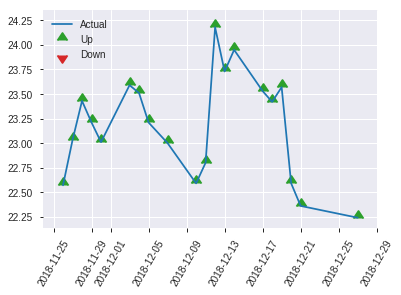


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2495368606479892
RMSE: 0.4995366459510145
LogLoss: 0.6923058620637604
Mean Per-Class Error: 0.40805540966386555
AUC: 0.5707720588235294
pr_auc: 0.5614271686141408
Gini: 0.14154411764705888
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3229828178882599: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      8    120  0.9375   (120.0/128.0)
1      3    116  0.0252   (3.0/119.0)
Total  11   236  0.498    (123.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.322983     0.653521  235
max f2                       0.257221     0.8241    245
max f0point5                 0.549531     0.573614  100
max accuracy                 0.549531     0.595142  100
max precision                0.753325     1         0
max recall                   0.257221     1         245
max specificity              0.753325     1         0
max absolute_mcc             0.549531     0.186895  100
max min_per_class_accuracy   0.52145      0.554622  119
max mean_per_class_accuracy  0.549531     0.591945  100

Gains/Lift Table: Avg response rate: 48.18 %, avg score: 51.65 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0121457                   0.739458           0.691877  0.691877           0.333333         0.745821  0.333333                    0.745821            0.00840336      0.00840336                 -30.8123  -30.8123
    2        0.0202429                   0.715769           2.07563   1.24538            1                0.738906  0.6                         0.743055            0.0168067       0.0252101                  107.563   24.5378
    3        0.0323887                   0.702659           2.07563   1.55672            1                0.709858  0.75                        0.730606            0.0252101       0.0504202                  107.563   55.6723
    4        0.0404858                   0.694408           1.03782   1.45294            0.5              0.695688  0.7                         0.723622            0.00840336      0.0588235                  3.78151   45.2941
    5        0.0526316                   0.684595           2.07563   1.59664            1                0.691207  0.769231                    0.716142            0.0252101       0.0840336                  107.563   59.6639
    6        0.101215                    0.654812           1.21078   1.41143            0.583333         0.66849   0.68                        0.693269            0.0588235       0.142857                   21.0784   41.1429
    7        0.149798                    0.630065           1.38375   1.40245            0.666667         0.64306   0.675676                    0.676985            0.0672269       0.210084                   38.3754   40.2453
    8        0.202429                    0.60481            0.957983  1.28689            0.461538         0.617208  0.62                        0.661443            0.0504202       0.260504                   -4.20168  28.6891
    9        0.299595                    0.579381           1.21078   1.26221            0.583333         0.592777  0.608108                    0.639173            0.117647        0.378151                   21.0784   26.2208
    10       0.40081                     0.553536           1.07933   1.21603            0.52             0.567606  0.585859                    0.6211              0.109244        0.487395                   7.93277   21.6026
    11       0.502024                    0.519288           0.664202  1.10477            0.32             0.534215  0.532258                    0.603583            0.0672269       0.554622                   -33.5798  10.4771
    12       0.59919                     0.499349           0.778361  1.05184            0.375            0.509501  0.506757                    0.588327            0.0756303       0.630252                   -22.1639  5.18397
    13       0.700405                    0.462718           0.830252  1.01982            0.4              0.476114  0.491329                    0.572111            0.0840336       0.714286                   -16.9748  1.98183
    14       0.797571                    0.423713           0.951331  1.01147            0.458333         0.443044  0.48731                     0.556387            0.092437        0.806723                   -4.86695  1.14746
    15       0.898785                    0.374621           0.830252  0.991067           0.4              0.400064  0.477477                    0.538783            0.0840336       0.890756                   -16.9748  -0.89333
    16       1                           0.189881           1.07933   1                  0.52             0.318743  0.481781                    0.516512       

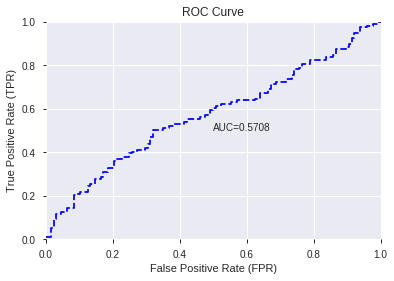

This function is available for GLM models only


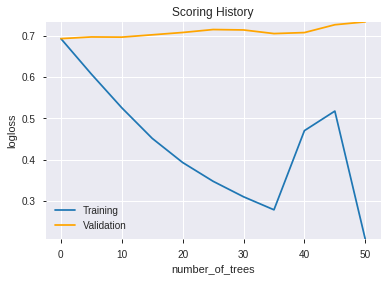

--2019-08-26 14:05:10--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.113.107
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.113.107|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at he

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190826_140423_model_5',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190826_140423_model_5',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_42_sid_97b9',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

In [18]:
# XGBoost
xgb_features = model_train(feature_name='All',model_algo="XGBoost")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190826_140521_model_3  0.566833  0.985078              0.500000  0.579793  0.336160
1  DeepLearning_grid_1_AutoML_20190826_140521_model_4  0.544774  0.790928              0.496094  0.539391  0.290943
2  DeepLearning_grid_1_AutoML_20190826_140521_model_6  0.543395  0.711152              0.472656  0.508825  0.258903
3  DeepLearning_grid_1_AutoML_20190826_140521_model_1  0.530626  2.521237              0.496094  0.670913  0.450124
4  DeepLearning_grid_1_AutoML_20190826_140521_model_2  0.506237  7.294670              0.472656  0.694104  0.481780
5  DeepLearning_grid_1_AutoML_20190826_140521_model_8  0.500000  0.693847              0.500000  0.500350  0.250350
6  DeepLearning_grid_1_AutoML_20190826_140521_model_9  0.500000  0.697592              0.500000  0.502214  0.252219
7  DeepLearning_grid_1_AutoML_20190826_140521_model_7  0.493501  0.704678              0.500000  0.505707  0.255740
8  DeepLearning_grid_1_AutoML_20190826_140521_model_5  0.483325  0.704256              0.500000  0.505491  0.255521
9               DeepLearning_1_AutoML_20190826_140521  0.477876  2.321929              0.500000  0.707107  0.500000

variable  relative_importance  scaled_importance  percentage
0             CDLMORNINGSTAR             1.000000           1.000000    0.054656
1                  CDLINNECK             0.952636           0.952636    0.052068
2                CDLPIERCING             0.920970           0.920970    0.050337
3           CDLSTICKSANDWICH             0.846922           0.846922    0.046290
4              CDLHIKKAKEMOD             0.828289           0.828289    0.045271
5            CDLSHOOTINGSTAR             0.686468           0.686468    0.037520
6                 AROONOSC_8             0.565319           0.565319    0.030898
7         CDLSEPARATINGLINES             0.536737           0.536737    0.029336
8                       week             0.503212           0.503212    0.027504
9                    ADXR_14             0.413917           0.413917    0.022623
10                   NATR_20             0.380956           0.380956    0.020822
11                PLUS_DI_24             0.359746           0.359746    0.019662
12                     DX_12             0.348301           0.348301    0.019037
13                   NATR_14             0.344634           0.344634    0.018836
14   BBANDS_lowerband_30_1_5             0.322979           0.322979    0.017653
15                    ROC_14             0.306313           0.306313    0.016742
16                ROCR100_14             0.297274           0.297274    0.016248
17   BBANDS_upperband_24_6_5             0.290483           0.290483    0.015877
18                PLUS_DI_14             0.289139           0.289139    0.015803
19                ROCR100_12             0.288882           0.288882    0.015789
20  BBANDS_middleband_30_0_3             0.288862           0.288862    0.015788
21   BBANDS_upperband_24_0_5             0.279825           0.279825    0.015294
22    BBANDS_upperband_8_3_5             0.279661           0.279661    0.015285
23   BBANDS_upperband_24_1_4             0.278421           0.278421    0.015217
24   BBANDS_lowerband_24_1_4             0.274883           0.274883    0.015024
25    BBANDS_upperband_8_0_5             0.273379           0.273379    0.014942
26    BBANDS_upperband_8_8_5             0.271415           0.271415    0.014835
27    BBANDS_lowerband_8_6_4             0.270934           0.270934    0.014808
28   BBANDS_lowerband_20_0_4             0.269621           0.269621    0.014736
29   BBANDS_lowerband_14_5_4             0.268925           0.268925    0.014698
30  BBANDS_middleband_30_7_2             0.268506           0.268506    0.014676
31                    MOM_14             0.265612           0.265612    0.014517
32   BBANDS_upperband_14_2_5             0.263720           0.263720    0.014414
33   BBANDS_upperband_24_5_2             0.262710           0.262710    0.014359
34                 MAVP_30_6             0.262374           0.262374    0.014340
35  BBANDS_middleband_14_5_5             0.261752           0.261752    0.014306
36               MIDPRICE_20             0.261623           0.261623    0.014299
37                  MAVP_8_6             0.261121           0.261121    0.014272
38              LINEARREG_30             0.254568           0.254568    0.013914
39   BBANDS_upperband_20_7_2             0.253503           0.253503    0.013856
40  BBANDS_middleband_24_0_4             0.253211           0.253211    0.013840
41   BBANDS_upperband_14_7_5             0.249720           0.249720    0.013649
42  BBANDS_middleband_12_2_5             0.247771           0.247771    0.013542
43                   MA_12_0             0.247751           0.247751    0.013541
44   BBANDS_upperband_24_2_3             0.246720           0.246720    0.013485
45  BBANDS_middleband_24_5_2             0.246059           0.246059    0.013449
46  BBANDS_middleband_14_0_3             0.245419           0.245419    0.013414
47   BBANDS_lowerband_12_4_5             0.239590           0.239590    0.013095
48   BBANDS_upperband_12_0_2             0.233524  

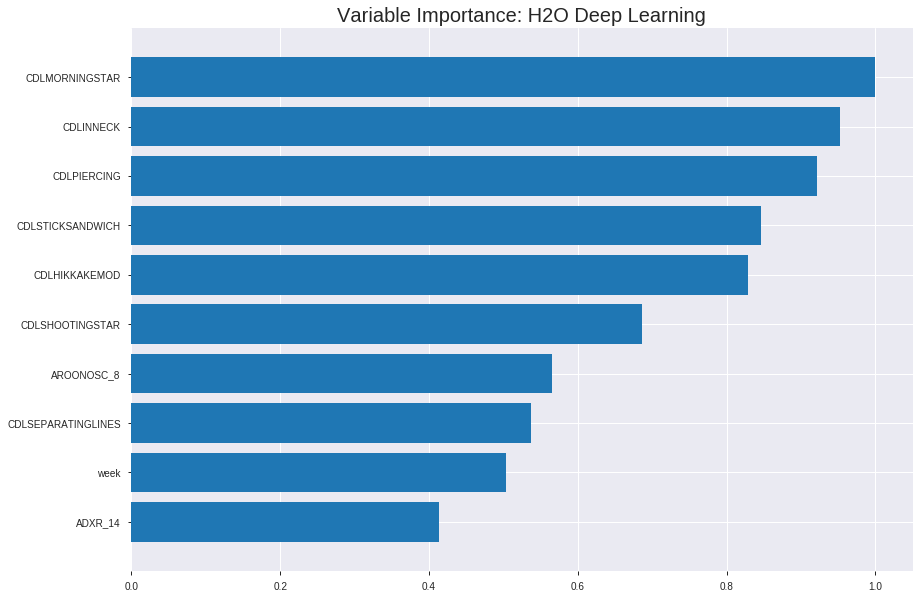

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190826_140521_model_3


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.26753745438612353
RMSE: 0.5172402288938125
LogLoss: 0.746433709639429
Mean Per-Class Error: 0.4508390355164549
AUC: 0.5580536548278484
pr_auc: 0.58396087362151
Gini: 0.11610730965569682
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.07736831604980549: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      19   773   0.976    (773.0/792.0)
1      7    923   0.0075   (7.0/930.0)
Total  26   1696  0.453    (780.0/1722.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.0773683    0.70297   383
max f2                       0.00234317   0.854779  398
max f0point5                 0.106786     0.598408  376
max accuracy                 0.417727     0.557491  231
max precision                0.98166      1         0
max recall                   0.00234317   1         398
max specificity              0.98166      1         0
max absolute_mcc             0.51903      0.101567  165
max min_per_class_accuracy   0.477237     0.53871   195
max mean_per_class_accuracy  0.51903      0.549161  165

Gains/Lift Table: Avg response rate: 54.01 %, avg score: 46.86 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010453                    0.920882           1.33728   1.33728            0.722222         0.942824  0.722222                    0.942824            0.0139785       0.0139785                  33.7276   33.7276
    2        0.0203252                   0.87447            0.65351   1.00516            0.352941         0.89704   0.542857                    0.920586            0.00645161      0.0204301                  -34.649   0.516129
    3        0.0301974                   0.819885           0.980266  0.997022           0.529412         0.843104  0.538462                    0.895255            0.00967742      0.0301075                  -1.97343  -0.297767
    4        0.0400697                   0.795481           0.871347  0.966059           0.470588         0.809509  0.521739                    0.87413             0.00860215      0.0387097                  -12.8653  -3.39411
    5        0.0505226                   0.760771           1.23441   1.02158            0.666667         0.778462  0.551724                    0.854336            0.0129032       0.0516129                  23.4409   2.15795
    6        0.100465                    0.691634           1.33488   1.17733            0.72093          0.72079   0.635838                    0.787949            0.0666667       0.11828                    33.4884   17.7326
    7        0.150407                    0.639798           1.01193   1.12241            0.546512         0.668301  0.606178                    0.74822             0.0505376       0.168817                   1.1928    12.2406
    8        0.200348                    0.599491           1.09805   1.11633            0.593023         0.616908  0.602899                    0.715487            0.0548387       0.223656                   9.80495   11.6335
    9        0.300232                    0.544402           1.14111   1.12458            0.616279         0.569529  0.60735                     0.666929            0.113978        0.337634                   14.111    12.4577
    10       0.400116                    0.510421           1.04422   1.10452            0.563953         0.525737  0.596517                    0.631682            0.104301        0.441935                   4.42236   10.4518
    11       0.5                         0.477244           0.947337  1.07312            0.511628         0.492625  0.579559                    0.603903            0.0946237       0.536559                   -5.26632  7.31183
    12       0.599884                    0.430552           1.01193   1.06293            0.546512         0.455903  0.574056                    0.57926             0.101075        0.637634                   1.1928    6.29298
    13       0.699768                    0.383792           0.958102  1.04797            0.517442         0.407068  0.565975                    0.554682            0.0956989       0.733333                   -4.1898   4.79668
    14       0.799652                    0.32562            0.893511  1.02867            0.482558         0.355797  0.555556                    0.529839            0.0892473       0.822581                   -10.6489  2.86738
    15       0.899535                    0.249008           0.925806  1.01725            0.5              0.292443  0.549387                    0.503479            0.0924731       0.915054                   -7.41935  1.72515
    16       1                           2.43842e-05        0.845534  1                  0.456647         0.15659   0.54007                     0.468629     



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.3060000386747203
RMSE: 0.5531727023947587
LogLoss: 0.8667190820930557
Mean Per-Class Error: 0.4582765409662275
AUC: 0.5193514732360711
pr_auc: 0.6142924909302422
Gini: 0.03870294647214223
Confusion Matrix (Act/Pred) for max f1 @ threshold = 8.214752596676302e-05: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    213  1        (213.0/213.0)
1      0    279  0        (0.0/279.0)
Total  0    492  0.4329   (213.0/492.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       8.21475e-05  0.723735  399
max f2                       8.21475e-05  0.867537  399
max f0point5                 8.21475e-05  0.620828  399
max accuracy                 0.0260457    0.567073  398
max precision                0.954905     1         0
max recall                   8.21475e-05  1         399
max specificity              0.954905     1         0
max absolute_mcc             0.809686     0.119396  46
max min_per_class_accuracy   0.421905     0.516129  199
max mean_per_class_accuracy  0.463958     0.541723  179

Gains/Lift Table: Avg response rate: 56.71 %, avg score: 45.12 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101626                   0.944892           1.76344   1.76344            1                0.949173  1                           0.949173            0.0179211       0.0179211                  76.3441   76.3441
    2        0.0203252                   0.937518           1.41075   1.5871             0.8              0.940896  0.9                         0.945035            0.0143369       0.0322581                  41.0753   58.7097
    3        0.0304878                   0.9225             0.705376  1.29319            0.4              0.932574  0.733333                    0.940881            0.00716846      0.0394265                  -29.4624  29.319
    4        0.0406504                   0.912364           1.41075   1.32258            0.8              0.91973   0.75                        0.935593            0.0143369       0.0537634                  41.0753   32.2581
    5        0.050813                    0.894057           1.41075   1.34022            0.8              0.900613  0.76                        0.928597            0.0143369       0.0681004                  41.0753   34.0215
    6        0.101626                    0.823631           1.19914   1.26968            0.68             0.849528  0.72                        0.889063            0.0609319       0.129032                   19.914    26.9677
    7        0.150407                    0.73418            0.955197  1.16768            0.541667         0.778645  0.662162                    0.853251            0.046595        0.175627                   -4.48029  16.7684
    8        0.20122                     0.690804           0.987527  1.12219            0.56             0.711877  0.636364                    0.817551            0.0501792       0.225806                   -1.24731  12.219
    9        0.300813                    0.586531           0.971692  1.07236            0.55102          0.629399  0.608108                    0.755257            0.0967742       0.322581                   -2.83081  7.23627
    10       0.400407                    0.491269           1.04367   1.06523            0.591837         0.535905  0.604061                    0.700698            0.103943        0.426523                   4.36691   6.52257
    11       0.5                         0.419873           0.899715  1.03226            0.510204         0.45546   0.585366                    0.651849            0.0896057       0.516129                   -10.0285  3.22581
    12       0.599593                    0.359961           0.75576   0.986331           0.428571         0.396274  0.559322                    0.609398            0.0752688       0.591398                   -24.424   -1.36687
    13       0.699187                    0.280207           0.863726  0.968867           0.489796         0.325529  0.549419                    0.568963            0.0860215       0.677419                   -13.6274  -3.11328
    14       0.79878                     0.205923           0.971692  0.969219           0.55102          0.236524  0.549618                    0.527514            0.0967742       0.774194                   -2.83081  -3.07806
    15       0.898374                    0.155128           1.18762   0.993432           0.673469         0.182676  0.563348                    0.489285            0.11828         0.892473                   18.7623   -0.656838
    16       1                           8.54152e-06        1.05806   1                  0.6              0.114576  0.567073                    0.451205      


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-26 14:07:10  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-26 14:07:12  1 min 50.161 sec  6860 obs/sec      10        1             17220      0.590446         1.58542             -0.40352       0.508557        0.549401           1.13154          0.45993                          0.753042           10.8333               -1.30986         0.519461          0.586159             1.41075            0.432927
    2019-08-26 14:07:18  1 min 55.843 sec  8492 obs/sec      40        4             68880      0.512786         0.737775            -0.0585977     0.548674        0.570785           1.13154          0.454704                         0.607564           1.2414                -0.503591        0.508961          0.596101             1.41075            0.432927
    2019-08-26 14:07:24  2 min  1.524 sec  10047 obs/sec     80        8             137760     0.51724          0.746434            -0.0770671     0.558054        0.583961           1.33728          0.452962                         0.553173           0.866719              -0.24643         0.519351          0.614292             1.76344            0.432927
    2019-08-26 14:07:30  2 min  7.398 sec  11480 obs/sec     130       13            223860     0.520564         0.75534             -0.0909551     0.554752        0.586862           1.23441          0.455285                         0.692805           1.84054               -0.955098        0.531686          0.618795             1.41075            0.432927
    2019-08-26 14:07:35  2 min 12.669 sec  12559 obs/sec     180       18            309960     0.519664         0.760343            -0.0871846     0.561185        0.59428            1.33728          0.453542                         0.732216           2.64389               -1.18386         0.526545          0.604503             1.41075            0.432927
    2019-08-26 14:07:40  2 min 17.779 sec  13332 obs/sec     230       23            396060     0.532212         0.838946            -0.140322      0.560228        0.59378            1.23441          0.458769                         0.748012           4.0396                -1.2791          0.533057          0.615973             1.41075            0.432927
    2019-08-26 14:07:46  2 min 23.433 sec  14159 obs/sec     290       29            499380     0.509213         0.74633             -0.0438973     0.586355        0.611905           1.33728          0.454123                         0.718137           2.35298               -1.10068         0.531871          0.612534             1.41075            0.432927
    2019-08-26 14:07:46  2 min 23.517 sec  14157 obs/sec     290       29            499380     0.51724          0.746434            -0.0770671     0.558054        0.583961           1.33728          0.452962                         0.553173           0.866719              -0.24643         0.519351          0.614292             1.76344            0.432927

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  --------------------
CDLMORNINGSTAR            1.0                    1.0                  0.05465627110954521
CDLINNECK                 0.9526361227035522     0.9526361227035522   0.05206753819123133
CDLPIERCING               0.9209696650505066     0.9209696650505066   0.050336767696667534
CDLSTICKSANDWICH          0.8469222187995911     0.8469222187995911   0.04628961039940802
CDLHIKKAKEMOD             0.828289270401001      0.828289270401001    0.04527120292016451
---                       ---                    ---                  ---
BBANDS_middleband_24_5_2  0.24605891108512878    0.24605891108512878  0.013448662553188278
BBANDS_middleband_14_0_3  0.24541908502578735    0.24541908502578735  0.013413692046625961
BBANDS_lowerband_12_4_5   0.23959040641784668    0.23959040641784668  0.013095118208419949
BBANDS_upperband_12_0_2   0.2335238754749298     0.2335238754749298   0.01276354424850944
BBANDS_middleband_12_3_5  0.23180487751960754    0.23180487751960754  0.012669590230226593


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5951417004048583)

('F1', 0.6502732240437158)

('auc', 0.5668329831932774)

('logloss', 0.9850778826117047)

('mean_per_class_error', 0.40687368697479)

('rmse', 0.5797934356624246)

('mse', 0.33616042803723806)

deeplearning prediction progress: |███████████████████████████████████████| 100%


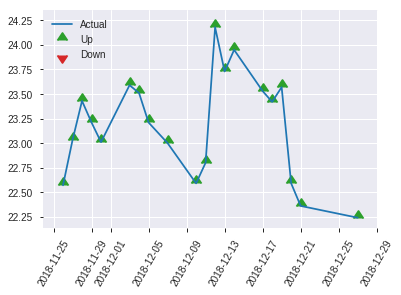


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.33616042803723806
RMSE: 0.5797934356624246
LogLoss: 0.9850778826117047
Mean Per-Class Error: 0.40687368697479
AUC: 0.5668329831932774
pr_auc: 0.5356179496471996
Gini: 0.1336659663865547
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.004858919553593779: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    128  1        (128.0/128.0)
1      0    119  0        (0.0/119.0)
Total  0    247  0.5182   (128.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.00485892   0.650273  246
max f2                       0.00485892   0.82296   246
max f0point5                 0.835623     0.576577  108
max accuracy                 0.836153     0.595142  106
max precision                0.989009     1         0
max recall                   0.00485892   1         246
max specificity              0.989009     1         0
max absolute_mcc             0.835623     0.187425  108
max min_per_class_accuracy   0.810146     0.585938  122
max mean_per_class_accuracy  0.835623     0.593126  108

Gains/Lift Table: Avg response rate: 48.18 %, avg score: 72.68 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0121457                   0.98353            1.38375   1.38375            0.666667         0.985894  0.666667                    0.985894            0.0168067       0.0168067                  38.3754   38.3754
    2        0.0202429                   0.979451           0         0.830252           0                0.982663  0.4                         0.984602            0               0.0168067                  -100      -16.9748
    3        0.0323887                   0.978574           0.691877  0.778361           0.333333         0.978871  0.375                       0.982453            0.00840336      0.0252101                  -30.8123  -22.1639
    4        0.0404858                   0.968536           0         0.622689           0                0.973916  0.3                         0.980746            0               0.0252101                  -100      -37.7311
    5        0.0526316                   0.958148           2.07563   0.957983           1                0.963008  0.461538                    0.976652            0.0252101       0.0504202                  107.563   -4.20168
    6        0.101215                    0.938346           1.38375   1.16235            0.666667         0.946212  0.56                        0.962041            0.0672269       0.117647                   38.3754   16.2353
    7        0.149798                    0.91541            1.55672   1.29026            0.75             0.927982  0.621622                    0.950995            0.0756303       0.193277                   55.6723   29.0257
    8        0.202429                    0.904605           0.957983  1.20387            0.461538         0.909549  0.58                        0.940219            0.0504202       0.243697                   -4.20168  20.3866
    9        0.299595                    0.879373           1.21078   1.20611            0.583333         0.893679  0.581081                    0.925125            0.117647        0.361345                   21.0784   20.6109
    10       0.40081                     0.840813           1.07933   1.17409            0.52             0.860583  0.565657                    0.908827            0.109244        0.470588                   7.93277   17.4094
    11       0.502024                    0.808855           1.16235   1.17173            0.56             0.827269  0.564516                    0.892384            0.117647        0.588235                   16.2353   17.1727
    12       0.59919                     0.725752           0.605392  1.07989            0.291667         0.760192  0.52027                     0.870947            0.0588235       0.647059                   -39.4608  7.98887
    13       0.700405                    0.629779           0.747227  1.03182            0.36             0.671279  0.49711                     0.842093            0.0756303       0.722689                   -25.2773  3.18162
    14       0.797571                    0.538199           0.778361  1.00094            0.375            0.570832  0.482234                    0.809046            0.0756303       0.798319                   -22.1639  0.0938446
    15       0.898785                    0.412051           0.830252  0.981717           0.4              0.485542  0.472973                    0.772616            0.0840336       0.882353                   -16.9748  -1.8283
    16       1                           0.00485892         1.16235   1                  0.56             0.319809  0.481781                    0.726785   

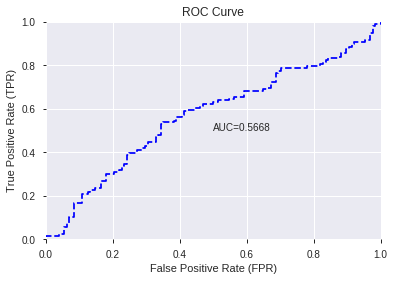

This function is available for GLM models only


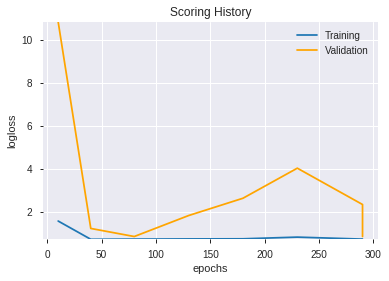

--2019-08-26 14:14:41--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.100.123
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.100.123|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190826_140521_model_3',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190826_140521_model_3',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_50_sid_97b9',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['CDLMORNINGSTAR',
 'CDLINNECK',
 'CDLPIERCING',
 'CDLSTICKSANDWICH',
 'CDLHIKKAKEMOD',
 'CDLSHOOTINGSTAR',
 'AROONOSC_8',
 'CDLSEPARATINGLINES',
 'week',
 'ADXR_14',
 'NATR_20',
 'PLUS_DI_24',
 'DX_12',
 'NATR_14',
 'BBANDS_lowerband_30_1_5',
 'ROC_14',
 'ROCR100_14',
 'BBANDS_upperband_24_6_5',
 'PLUS_DI_14',
 'ROCR100_12',
 'BBANDS_middleband_30_0_3',
 'BBANDS_upperband_24_0_5',
 'BBANDS_upperband_8_3_5',
 'BBANDS_upperband_24_1_4',
 'BBANDS_lowerband_24_1_4',
 'BBANDS_upperband_8_0_5',
 'BBANDS_upperband_8_8_5',
 'BBANDS_lowerband_8_6_4',
 'BBANDS_lowerband_20_0_4',
 'BBANDS_lowerband_14_5_4',
 'BBANDS_middleband_30_7_2',
 'MOM_14',
 'BBANDS_upperband_14_2_5',
 'BBANDS_upperband_24_5_2',
 'MAVP_30_6',
 'BBANDS_middleband_14_5_5',
 'MIDPRICE_20',
 'MAVP_8_6',
 'LINEARREG_30',
 'BBANDS_upperband_20_7_2',
 'BBANDS_middleband_24_0_4',
 'BBANDS_upperband_14_7_5',
 'BBANDS_middleband_12_2_5',
 'MA_12_0',
 'BBANDS_upperband_24_2_3',
 'BBANDS_middleband_24_5_2',
 'BBANDS_middleband_14_0_3'

In [19]:
# DeepLearning with top XGBoost features
model_train(feature_name='XGBF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc  logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190826_141452_model_1  0.470129   0.7222                   0.5  0.514038  0.264235

variable  relative_importance  scaled_importance  percentage
0                  CDLINNECK             0.008913           1.000000    0.109572
1           CDLSTICKSANDWICH             0.006246           0.700817    0.076790
2              CDLHIKKAKEMOD             0.005351           0.600356    0.065782
3                    NATR_20             0.004353           0.488418    0.053517
4                 PLUS_DI_24             0.004161           0.466891    0.051158
5                      DX_12             0.003526           0.395628    0.043350
6                    NATR_14             0.003353           0.376210    0.041222
7         CDLSEPARATINGLINES             0.003090           0.346650    0.037983
8            CDLSHOOTINGSTAR             0.003065           0.343940    0.037686
9             CDLMORNINGSTAR             0.002581           0.289627    0.031735
10                ROCR100_14             0.002448           0.274626    0.030091
11                    ROC_14             0.002435           0.273161    0.029931
12   BBANDS_lowerband_14_5_4             0.002317           0.259970    0.028485
13   BBANDS_lowerband_12_4_5             0.002039           0.228797    0.025070
14                   ADXR_14             0.001817           0.203913    0.022343
15    BBANDS_lowerband_8_6_4             0.001668           0.187159    0.020507
16                ROCR100_12             0.001486           0.166734    0.018269
17   BBANDS_lowerband_20_0_4             0.001159           0.130019    0.014246
18   BBANDS_upperband_24_6_5             0.001157           0.129804    0.014223
19   BBANDS_upperband_24_1_4             0.001143           0.128236    0.014051
20               CDLPIERCING             0.001076           0.120682    0.013223
21  BBANDS_middleband_12_2_5             0.000989           0.110917    0.012153
22              LINEARREG_30             0.000970           0.108863    0.011928
23  BBANDS_middleband_14_5_5             0.000963           0.108072    0.011842
24                   MA_12_0             0.000960           0.107712    0.011802
25  BBANDS_middleband_12_3_5             0.000948           0.106310    0.011649
26   BBANDS_upperband_24_2_3             0.000944           0.105903    0.011604
27                 MAVP_30_6             0.000890           0.099869    0.010943
28                  MAVP_8_6             0.000858           0.096275    0.010549
29  BBANDS_middleband_14_0_3             0.000806           0.090410    0.009906
30   BBANDS_upperband_24_0_5             0.000795           0.089193    0.009773
31  BBANDS_middleband_30_7_2             0.000763           0.085637    0.009383
32   BBANDS_upperband_14_7_5             0.000745           0.083564    0.009156
33               MIDPRICE_20             0.000691           0.077511    0.008493
34   BBANDS_lowerband_24_1_4             0.000641           0.071865    0.007874
35   BBANDS_upperband_24_5_2             0.000640           0.071838    0.007871
36   BBANDS_lowerband_30_1_5             0.000596           0.066819    0.007321
37   BBANDS_upperband_12_0_2             0.000574           0.064421    0.007059
38  BBANDS_middleband_30_0_3             0.000572           0.064175    0.007032
39  BBANDS_middleband_24_5_2             0.000509           0.057080    0.006254
40   BBANDS_upperband_14_2_5             0.000484           0.054340    0.005954
41  BBANDS_middleband_24_0_4             0.000471           0.052819    0.005788
42    BBANDS_upperband_8_0_5             0.000469           0.052622    0.005766
43    BBANDS_upperband_8_8_5             0.000395           0.044282    0.004852
44   BBANDS_upperband_20_7_2             0.000358           0.040217    0.004407
45                AROONOSC_8             0.000352           0.039474    0.004325
46                    MOM_14             0.000256           0.028771    0.003153
47    BBANDS_upperband_8_3_5             0.000234           0.026240    0.002875
48                      week             0.000083  

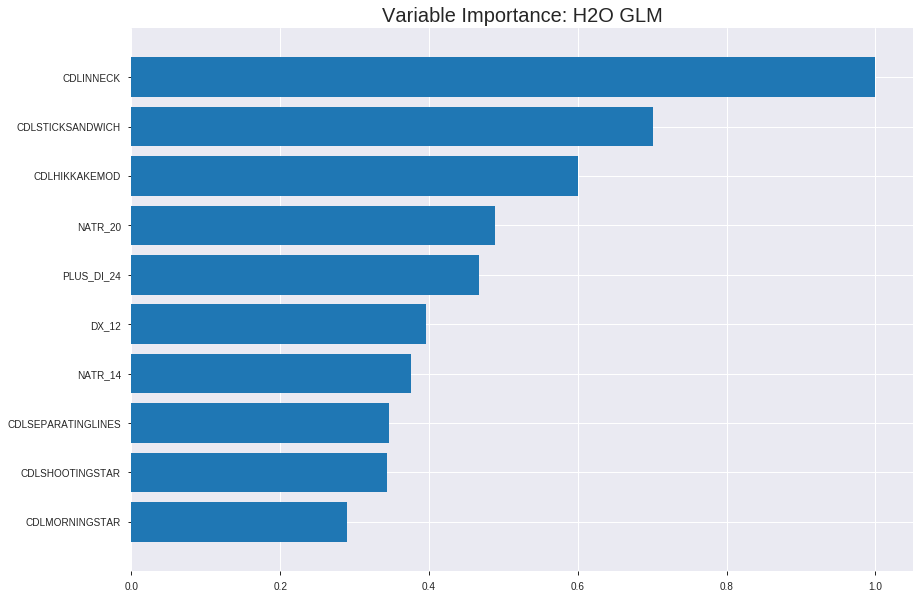

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190826_141452_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24808861870231952
RMSE: 0.49808495129076075
LogLoss: 0.6893175541324243
Null degrees of freedom: 1721
Residual degrees of freedom: 1671
Null deviance: 2376.1277882295276
Residual deviance: 2374.0096564320693
AIC: 2476.0096564320693
AUC: 0.5205427935266644
pr_auc: 0.5572191924891304
Gini: 0.041085587053328876
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5240996131840802: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      5    787   0.9937   (787.0/792.0)
1      0    930   0        (0.0/930.0)
Total  5    1717  0.457    (787.0/1722.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.5241       0.702682   394
max f2                       0.5241       0.855251   394
max f0point5                 0.533539     0.599688   333
max accuracy                 0.533539     0.553426   333
max precision                0.591179     1          0
max recall                   0.5241       1          394
max specificity              0.591179     1          0
max absolute_mcc             0.533539     0.0710968  333
max min_per_class_accuracy   0.539006     0.509677   224
max mean_per_class_accuracy  0.533539     0.522296   333

Gains/Lift Table: Avg response rate: 54.01 %, avg score: 54.01 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010453                    0.556307           1.33728   1.33728            0.722222         0.55927   0.722222                    0.55927             0.0139785       0.0139785                  33.7276   33.7276
    2        0.0203252                   0.555431           1.08918   1.21677            0.588235         0.555722  0.657143                    0.557547            0.0107527       0.0247312                  8.91841   21.6774
    3        0.0301974                   0.554965           1.08918   1.17506            0.588235         0.555132  0.634615                    0.556757            0.0107527       0.0354839                  8.91841   17.5062
    4        0.0400697                   0.554469           0.980266  1.12707            0.529412         0.554731  0.608696                    0.556258            0.00967742      0.0451613                  -1.97343  12.7069
    5        0.0505226                   0.554233           0.720072  1.04286            0.388889         0.554376  0.563218                    0.555869            0.00752688      0.0526882                  -27.9928  4.28624
    6        0.100465                    0.551295           0.947337  0.995376           0.511628         0.552574  0.537572                    0.554231            0.0473118       0.1                        -5.26632  -0.462428
    7        0.150407                    0.54703            1.14111   1.04377            0.616279         0.549049  0.563707                    0.55251             0.0569892       0.156989                   14.111    4.37663
    8        0.200348                    0.543823           1.18417   1.07877            0.639535         0.545281  0.582609                    0.550708            0.0591398       0.216129                   18.4171   7.87658
    9        0.300232                    0.541135           0.979632  1.04579            0.52907          0.54211   0.564797                    0.547847            0.0978495       0.313978                   -2.03676  4.57852
    10       0.400116                    0.540008           0.968867  1.02658            0.523256         0.540572  0.554427                    0.546031            0.0967742       0.410753                   -3.11328  2.65836
    11       0.5                         0.538997           0.979632  1.0172             0.52907          0.539461  0.549361                    0.544719            0.0978495       0.508602                   -2.03676  1.72043
    12       0.599884                    0.538186           0.958102  1.00736            0.517442         0.538588  0.544046                    0.543698            0.0956989       0.604301                   -4.1898   0.736346
    13       0.699768                    0.537011           1.05499   1.01416            0.569767         0.537635  0.547718                    0.542832            0.105376        0.709677                   5.49887   1.41614
    14       0.799652                    0.535237           1.03346   1.01657            0.55814          0.536191  0.54902                     0.542003            0.103226        0.812903                   3.34584   1.65718
    15       0.899535                    0.533348           1.04422   1.01964            0.563953         0.534316  0.550678                    0.541149            0.104301        0.917204                   4.42236   1.96422
    16       1                           0.474278           0.824128  1                  0.445087         0.530402  0.54007                     0.54007       



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.24554517094055162
RMSE: 0.49552514662784936
LogLoss: 0.6842117325403275
Null degrees of freedom: 491
Residual degrees of freedom: 441
Null deviance: 674.6256660447343
Residual deviance: 673.2643448196823
AIC: 775.2643448196823
AUC: 0.4854022582327898
pr_auc: 0.5679568584807326
Gini: -0.029195483534420363
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5201708739037567: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    212  0.9953   (212.0/213.0)
1      0    279  0        (0.0/279.0)
Total  1    491  0.4309   (212.0/492.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.520171     0.724675   398
max f2                       0.520171     0.868077   398
max f0point5                 0.553424     0.623025   391
max accuracy                 0.554075     0.571138   384
max precision                0.586531     1          0
max recall                   0.520171     1          398
max specificity              0.586531     1          0
max absolute_mcc             0.565238     0.0753497  166
max min_per_class_accuracy   0.564491     0.491039   191
max mean_per_class_accuracy  0.568659     0.52196    62

Gains/Lift Table: Avg response rate: 56.71 %, avg score: 56.41 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101626                   0.583728           1.41075   1.41075            0.8              0.584686  0.8                         0.584686            0.0143369       0.0143369                  41.0753   41.0753
    2        0.0203252                   0.583042           1.05806   1.23441            0.6              0.583475  0.7                         0.58408             0.0107527       0.0250896                  5.80645   23.4409
    3        0.0304878                   0.582297           1.05806   1.17563            0.6              0.582791  0.666667                    0.58365             0.0107527       0.0358423                  5.80645   17.5627
    4        0.0406504                   0.580216           1.05806   1.14624            0.6              0.581449  0.65                        0.5831              0.0107527       0.046595                   5.80645   14.6237
    5        0.050813                    0.579291           0.705376  1.05806            0.4              0.579647  0.6                         0.582409            0.00716846      0.0537634                  -29.4624  5.80645
    6        0.101626                    0.569653           1.19914   1.1286             0.68             0.573342  0.64                        0.577876            0.0609319       0.114695                   19.914    12.8602
    7        0.150407                    0.568545           1.10215   1.12002            0.625            0.569117  0.635135                    0.575035            0.0537634       0.168459                   10.2151   12.0023
    8        0.20122                     0.567892           0.705376  1.01531            0.4              0.568218  0.575758                    0.573314            0.0358423       0.204301                   -29.4624  1.53144
    9        0.300813                    0.566488           0.75576   0.929381           0.428571         0.567233  0.527027                    0.5713              0.0752688       0.27957                    -24.424   -7.0619
    10       0.400407                    0.565389           0.935703  0.930954           0.530612         0.566004  0.527919                    0.569983            0.09319         0.37276                    -6.42967  -6.90464
    11       0.5                         0.564467           1.18762   0.982079           0.673469         0.564955  0.556911                    0.568982            0.11828         0.491039                   18.7623   -1.79211
    12       0.599593                    0.562923           1.07966   0.998287           0.612245         0.563808  0.566102                    0.568122            0.107527        0.598566                   7.96577   -0.171314
    13       0.699187                    0.560725           0.863726  0.97912            0.489796         0.562019  0.555233                    0.567253            0.0860215       0.684588                   -13.6274  -2.08802
    14       0.79878                     0.55916            1.18762   1.00512            0.673469         0.559798  0.569975                    0.566323            0.11828         0.802867                   18.7623   0.511642
    15       0.898374                    0.55657            0.971692  1.00141            0.55102          0.557828  0.567873                    0.565382            0.0967742       0.899642                   -2.83081  0.141099
    16       1                           0.503299           0.987527  1                  0.56             0.552948  0.567073                    0.564118  


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-26 14:14:52  0.000 sec   2            1.8       51            1.37864           1.36842
    2019-08-26 14:14:52  0.009 sec   3            1.1       51            1.37817           1.36846
    2019-08-26 14:14:52  0.016 sec   4            0.71      51            1.37759           1.36865
    2019-08-26 14:14:52  0.024 sec   5            0.44      51            1.37691           1.36913
    2019-08-26 14:14:52  0.038 sec   7            0.27      51            1.37616           1.37006
    2019-08-26 14:14:52  0.058 sec   9            0.17      51            1.37538           1.37155

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5222672064777328)

('F1', 0.6502732240437158)

('auc', 0.47012867647058826)

('logloss', 0.7222002130717227)

('mean_per_class_error', 0.48900341386554624)

('rmse', 0.5140377029035553)

('mse', 0.2642347600063638)

glm prediction progress: |████████████████████████████████████████████████| 100%


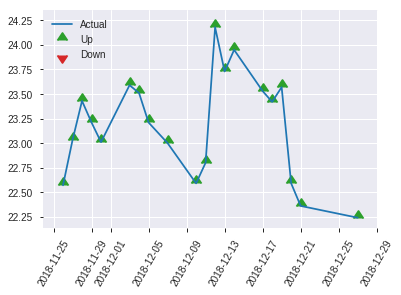


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2642347600063638
RMSE: 0.5140377029035553
LogLoss: 0.7222002130717227
Null degrees of freedom: 246
Residual degrees of freedom: 196
Null deviance: 345.4517445763613
Residual deviance: 356.76690525743106
AIC: 458.76690525743106
AUC: 0.47012867647058826
pr_auc: 0.44847124408101335
Gini: -0.059742647058823484
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5797938715952411: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    128  1        (128.0/128.0)
1      0    119  0        (0.0/119.0)
Total  0    247  0.5182   (128.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.579794     0.650273  246
max f2                       0.579794     0.82296   246
max f0point5                 0.585345     0.540284  233
max accuracy                 0.608444     0.522267  46
max precision                0.608444     0.510638  46
max recall                   0.579794     1         246
max specificity              0.641087     0.992188  0
max absolute_mcc             0.609965     0.129607  10
max min_per_class_accuracy   0.603095     0.462185  122
max mean_per_class_accuracy  0.608444     0.510997  46

Gains/Lift Table: Avg response rate: 48.18 %, avg score: 60.04 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0121457                   0.614807           0.691877  0.691877           0.333333         0.624933  0.333333                    0.624933            0.00840336      0.00840336                 -30.8123   -30.8123
    2        0.0202429                   0.61111            0         0.415126           0                0.612611  0.2                         0.620004            0               0.00840336                 -100       -58.4874
    3        0.0323887                   0.610191           0.691877  0.518908           0.333333         0.610509  0.25                        0.616443            0.00840336      0.0168067                  -30.8123   -48.1092
    4        0.0404858                   0.609979           0         0.415126           0                0.61012   0.2                         0.615179            0               0.0168067                  -100       -58.4874
    5        0.0526316                   0.609722           1.38375   0.638655           0.666667         0.609815  0.307692                    0.613941            0.0168067       0.0336134                  38.3754    -36.1345
    6        0.101215                    0.60931            0.691877  0.664202           0.333333         0.609517  0.32                        0.611817            0.0336134       0.0672269                  -30.8123   -33.5798
    7        0.149798                    0.608793           1.38375   0.89757            0.666667         0.609077  0.432432                    0.610929            0.0672269       0.134454                   38.3754    -10.243
    8        0.202429                    0.608332           1.27731   0.996303           0.615385         0.608573  0.48                        0.610316            0.0672269       0.201681                   27.7311    -0.369748
    9        0.299595                    0.607218           0.778361  0.925619           0.375            0.6078    0.445946                    0.6095              0.0756303       0.277311                   -22.1639   -7.43811
    10       0.40081                     0.604836           0.913277  0.922502           0.44             0.605917  0.444444                    0.608595            0.092437        0.369748                   -8.67227   -7.74977
    11       0.502024                    0.602995           0.913277  0.920642           0.44             0.603899  0.443548                    0.607648            0.092437        0.462185                   -8.67227   -7.93575
    12       0.59919                     0.600839           1.38375   0.995742           0.666667         0.601921  0.47973                     0.60672             0.134454        0.596639                   38.3754    -0.425846
    13       0.700405                    0.592971           0.996303  0.995823           0.48             0.595658  0.479769                    0.605121            0.10084         0.697479                   -0.369748  -0.417739
    14       0.797571                    0.590917           0.951331  0.990402           0.458333         0.592131  0.477157                    0.603539            0.092437        0.789916                   -4.86695   -0.959775
    15       0.898785                    0.588999           0.996303  0.991067           0.48             0.590381  0.477477                    0.602057            0.10084         0.890756                   -0.369748  -0.89333
    16       1                           0.579794           1.07933   1                  0.52             0.585277  0.481781  

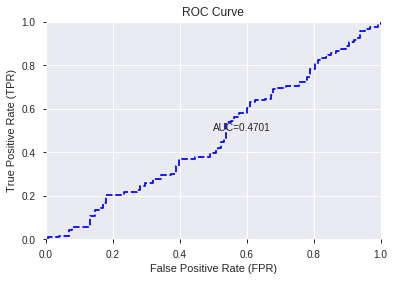

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


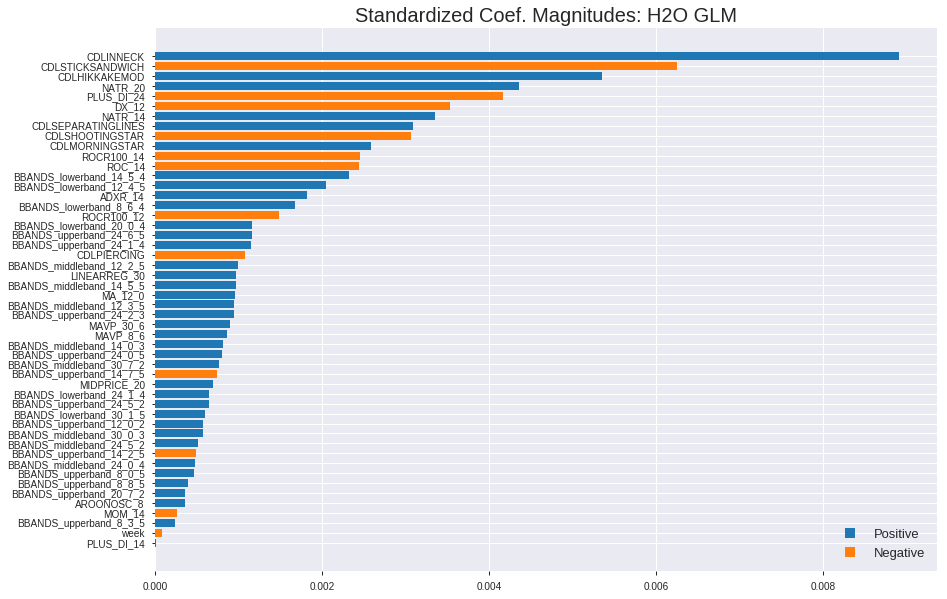

'log_likelihood'
--2019-08-26 14:14:57--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.139.195
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.139.195|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190826_141452_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190826_141452_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_58_sid_97b9',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_58_s

['CDLINNECK',
 'CDLSTICKSANDWICH',
 'CDLHIKKAKEMOD',
 'NATR_20',
 'PLUS_DI_24',
 'DX_12',
 'NATR_14',
 'CDLSEPARATINGLINES',
 'CDLSHOOTINGSTAR',
 'CDLMORNINGSTAR',
 'ROCR100_14',
 'ROC_14',
 'BBANDS_lowerband_14_5_4',
 'BBANDS_lowerband_12_4_5',
 'ADXR_14',
 'BBANDS_lowerband_8_6_4',
 'ROCR100_12',
 'BBANDS_lowerband_20_0_4',
 'BBANDS_upperband_24_6_5',
 'BBANDS_upperband_24_1_4',
 'CDLPIERCING',
 'BBANDS_middleband_12_2_5',
 'LINEARREG_30',
 'BBANDS_middleband_14_5_5',
 'MA_12_0',
 'BBANDS_middleband_12_3_5',
 'BBANDS_upperband_24_2_3',
 'MAVP_30_6',
 'MAVP_8_6',
 'BBANDS_middleband_14_0_3',
 'BBANDS_upperband_24_0_5',
 'BBANDS_middleband_30_7_2',
 'BBANDS_upperband_14_7_5',
 'MIDPRICE_20',
 'BBANDS_lowerband_24_1_4',
 'BBANDS_upperband_24_5_2',
 'BBANDS_lowerband_30_1_5',
 'BBANDS_upperband_12_0_2',
 'BBANDS_middleband_30_0_3',
 'BBANDS_middleband_24_5_2',
 'BBANDS_upperband_14_2_5',
 'BBANDS_middleband_24_0_4',
 'BBANDS_upperband_8_0_5',
 'BBANDS_upperband_8_8_5',
 'BBANDS_upperband

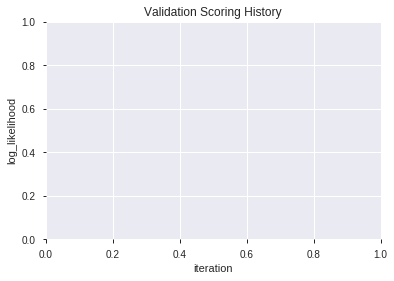

In [20]:
# GLM with top XGBoost features
model_train(feature_name='XGBF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190826_141513_model_5  0.536962  0.703510              0.488872  0.504691  0.254713
1               XGBoost_2_AutoML_20190826_141513  0.534500  0.695637              0.496094  0.501213  0.251214
2               XGBoost_1_AutoML_20190826_141513  0.528690  0.704817              0.488281  0.505693  0.255725
3  XGBoost_grid_1_AutoML_20190826_141513_model_7  0.526261  0.708704              0.496094  0.507587  0.257645
4  XGBoost_grid_1_AutoML_20190826_141513_model_3  0.526129  0.701923              0.500000  0.504255  0.254273
5  XGBoost_grid_1_AutoML_20190826_141513_model_1  0.519105  0.721602              0.500000  0.513678  0.263865
6  XGBoost_grid_1_AutoML_20190826_141513_model_2  0.515494  0.699782              0.500000  0.503258  0.253268
7  XGBoost_grid_1_AutoML_20190826_141513_model_4  0.503184  0.696201              0.500000  0.501512  0.251515
8               XGBoost_3_AutoML_20190826_141513  0.501313  0.714988              0.496094  0.510535  0.260646
9  XGBoost_grid_1_AutoML_20190826_141513_model_6  0.470949  0.712528              0.500000  0.509389  0.259478

variable  relative_importance  scaled_importance  percentage
0                 ROCR100_12          1092.647217           1.000000    0.052818
1                      DX_12          1045.457520           0.956812    0.050536
2     BBANDS_upperband_8_0_5           936.864014           0.857426    0.045287
3                    NATR_14           924.007629           0.845660    0.044666
4                 PLUS_DI_14           916.143738           0.838463    0.044286
5                     MOM_14           845.223999           0.773556    0.040857
6                       week           776.103149           0.710296    0.037516
7                     ROC_14           761.211792           0.696667    0.036796
8                    ADXR_14           758.684692           0.694355    0.036674
9     BBANDS_lowerband_8_6_4           726.171936           0.664599    0.035102
10                PLUS_DI_24           698.192200           0.638991    0.033750
11    BBANDS_upperband_8_3_5           688.863159           0.630453    0.033299
12                  MAVP_8_6           681.548523           0.623759    0.032945
13                AROONOSC_8           620.209167           0.567621    0.029980
14   BBANDS_lowerband_12_4_5           617.922180           0.565528    0.029870
15   BBANDS_lowerband_20_0_4           564.474182           0.516612    0.027286
16                   NATR_20           563.674255           0.515879    0.027247
17   BBANDS_upperband_14_2_5           557.121826           0.509883    0.026931
18   BBANDS_lowerband_30_1_5           515.170105           0.471488    0.024903
19    BBANDS_upperband_8_8_5           478.030670           0.437498    0.023108
20                ROCR100_14           454.536682           0.415996    0.021972
21   BBANDS_lowerband_14_5_4           450.695190           0.412480    0.021786
22   BBANDS_lowerband_24_1_4           442.740692           0.405200    0.021402
23   BBANDS_upperband_14_7_5           365.888947           0.334865    0.017687
24   BBANDS_upperband_12_0_2           355.813354           0.325643    0.017200
25   BBANDS_upperband_24_6_5           330.196136           0.302198    0.015961
26   BBANDS_upperband_24_0_5           319.297882           0.292224    0.015435
27  BBANDS_middleband_12_3_5           281.395966           0.257536    0.013602
28   BBANDS_upperband_24_1_4           280.268829           0.256504    0.013548
29  BBANDS_middleband_12_2_5           265.229492           0.242740    0.012821
30   BBANDS_upperband_20_7_2           262.775696           0.240495    0.012702
31                   MA_12_0           243.394989           0.222757    0.011765
32              LINEARREG_30           220.073837           0.201413    0.010638
33   BBANDS_upperband_24_2_3           212.242538           0.194246    0.010260
34   BBANDS_upperband_24_5_2           201.909561           0.184789    0.009760
35  BBANDS_middleband_24_0_4           199.404358           0.182497    0.009639
36  BBANDS_middleband_14_5_5           175.132614           0.160283    0.008466
37               MIDPRICE_20           170.538528           0.156078    0.008244
38  BBANDS_middleband_24_5_2           164.693787           0.150729    0.007961
39  BBANDS_middleband_30_7_2           147.782425           0.135252    0.007144
40  BBANDS_middleband_30_0_3           140.350784           0.128450    0.006784
41  BBANDS_middleband_14_0_3           125.551903           0.114906    0.006069
42                 MAVP_30_6            77.864853           0.071263    0.003764
43           CDLSHOOTINGSTAR            21.517475           0.019693    0.001040
44                 CDLINNECK             3.929072           0.003596    0.000190
45          CDLSTICKSANDWICH             3.300783           0.003021    0.000160
46            CDLMORNINGSTAR             2.943591           0.002694    0.000142

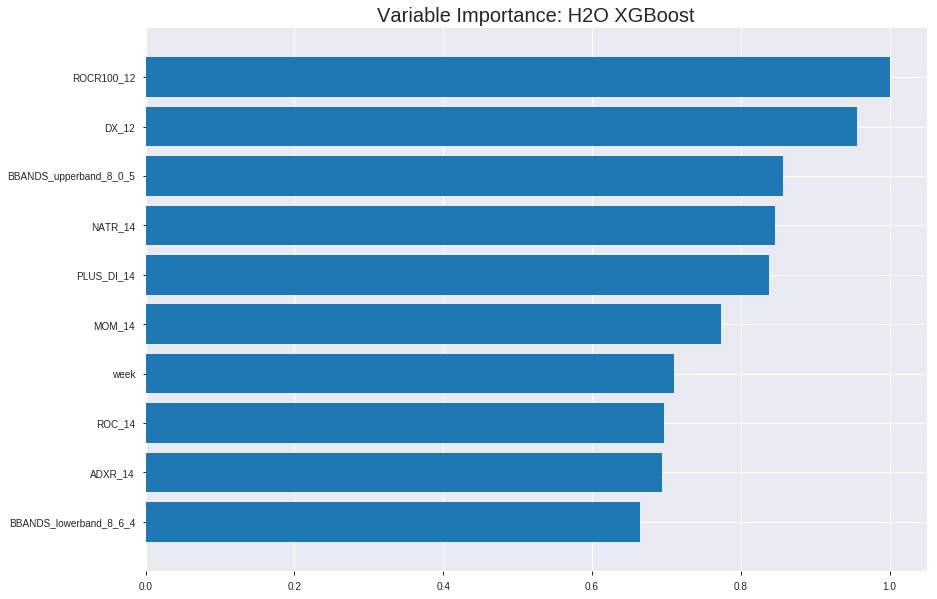

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190826_141513_model_5


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.07294255047959317
RMSE: 0.27007878568964494
LogLoss: 0.30316151579096307
Mean Per-Class Error: 0.004301075268817178
AUC: 0.9998506571087216
pr_auc: 0.9987998791528224
Gini: 0.9997013142174431
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5515879392623901: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      792  0    0        (0.0/792.0)
1      8    922  0.0086   (8.0/930.0)
Total  800  922  0.0046   (8.0/1722.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.551588     0.99568   197
max f2                       0.494824     0.994629  203
max f0point5                 0.551588     0.998268  197
max accuracy                 0.551588     0.995354  197
max precision                0.920951     1         0
max recall                   0.451161     1         213
max specificity              0.920951     1         0
max absolute_mcc             0.551588     0.990699  197
max min_per_class_accuracy   0.511094     0.993548  200
max mean_per_class_accuracy  0.551588     0.995699  197

Gains/Lift Table: Avg response rate: 54.01 %, avg score: 53.71 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010453                    0.895015           1.85161   1.85161            1                0.907229  1                           0.907229            0.0193548       0.0193548                  85.1613   85.1613
    2        0.0203252                   0.877134           1.85161   1.85161            1                0.885445  1                           0.896648            0.0182796       0.0376344                  85.1613   85.1613
    3        0.0301974                   0.867533           1.85161   1.85161            1                0.87119   1                           0.888325            0.0182796       0.055914                   85.1613   85.1613
    4        0.0400697                   0.859591           1.85161   1.85161            1                0.863244  1                           0.882146            0.0182796       0.0741935                  85.1613   85.1613
    5        0.0505226                   0.854099           1.85161   1.85161            1                0.856574  1                           0.876855            0.0193548       0.0935484                  85.1613   85.1613
    6        0.100465                    0.830671           1.85161   1.85161            1                0.841549  1                           0.859304            0.0924731       0.186022                   85.1613   85.1613
    7        0.150407                    0.812274           1.85161   1.85161            1                0.821861  1                           0.846871            0.0924731       0.278495                   85.1613   85.1613
    8        0.200348                    0.797005           1.85161   1.85161            1                0.804348  1                           0.836271            0.0924731       0.370968                   85.1613   85.1613
    9        0.300232                    0.759871           1.85161   1.85161            1                0.777277  1                           0.816645            0.184946        0.555914                   85.1613   85.1613
    10       0.400116                    0.710826           1.85161   1.85161            1                0.736645  1                           0.796674            0.184946        0.74086                    85.1613   85.1613
    11       0.5                         0.638436           1.85161   1.85161            1                0.679016  1                           0.77317             0.184946        0.925806                   85.1613   85.1613
    12       0.599884                    0.377786           0.742798  1.66699            0.401163         0.493128  0.90029                     0.726541            0.0741935       1                          -25.7202  66.6989
    13       0.699768                    0.308689           0         1.42905            0                0.341858  0.771784                    0.671632            0               1                          -100      42.9046
    14       0.799652                    0.25439            0         1.25054            0                0.28005   0.675381                    0.62272             0               1                          -100      25.0545
    15       0.899535                    0.200155           0         1.11168            0                0.227548  0.600387                    0.57884             0               1                          -100      11.1685
    16       1                           0.0844789          0         1                  0                0.162899  0.54007                     0.537053         



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2584193626680233
RMSE: 0.508349646078389
LogLoss: 0.7113679916591004
Mean Per-Class Error: 0.46029582512999145
AUC: 0.5192589227118987
pr_auc: 0.6120202516912009
Gini: 0.038517845423797326
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.21793727576732635: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    213  1        (213.0/213.0)
1      0    279  0        (0.0/279.0)
Total  0    492  0.4329   (213.0/492.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.217937     0.723735  399
max f2                       0.217937     0.867537  399
max f0point5                 0.217937     0.620828  399
max accuracy                 0.264453     0.567073  387
max precision                0.745301     1         0
max recall                   0.217937     1         399
max specificity              0.745301     1         0
max absolute_mcc             0.67928      0.136936  25
max min_per_class_accuracy   0.514464     0.492958  196
max mean_per_class_accuracy  0.604087     0.539704  87

Gains/Lift Table: Avg response rate: 56.71 %, avg score: 50.38 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101626                   0.734204           1.41075   1.41075            0.8              0.739815  0.8                         0.739815            0.0143369       0.0143369                  41.0753   41.0753
    2        0.0203252                   0.720142           1.41075   1.41075            0.8              0.725849  0.8                         0.732832            0.0143369       0.0286738                  41.0753   41.0753
    3        0.0304878                   0.706922           1.76344   1.52832            1                0.716089  0.866667                    0.727251            0.0179211       0.046595                   76.3441   52.8315
    4        0.0406504                   0.695364           1.41075   1.49892            0.8              0.70078   0.85                        0.720634            0.0143369       0.0609319                  41.0753   49.8925
    5        0.050813                    0.688584           1.05806   1.41075            0.6              0.691871  0.8                         0.714881            0.0107527       0.0716846                  5.80645   41.0753
    6        0.101626                    0.646764           1.1286    1.26968            0.64             0.664151  0.72                        0.689516            0.0573477       0.129032                   12.8602   26.9677
    7        0.150407                    0.628984           0.88172   1.14385            0.5              0.637004  0.648649                    0.672485            0.0430108       0.172043                   -11.828   14.3854
    8        0.20122                     0.6067             1.19914   1.15781            0.68             0.617682  0.656566                    0.658646            0.0609319       0.232975                   19.914    15.7815
    9        0.300813                    0.57309            0.683783  1.00087            0.387755         0.588807  0.567568                    0.635523            0.0681004       0.301075                   -31.6217  0.087184
    10       0.400407                    0.545876           1.07966   1.02047            0.612245         0.561161  0.57868                     0.617027            0.107527        0.408602                   7.96577   2.04683
    11       0.5                         0.514464           0.863726  0.989247           0.489796         0.530596  0.560976                    0.599811            0.0860215       0.494624                   -13.6274  -1.07527
    12       0.599593                    0.478462           1.11565   1.01024            0.632653         0.498748  0.572881                    0.583025            0.111111        0.605735                   11.5646   1.02424
    13       0.699187                    0.44081            1.11565   1.02526            0.632653         0.458979  0.581395                    0.565355            0.111111        0.716846                   11.5646   2.52563
    14       0.79878                     0.390597           0.827738  1.00063            0.469388         0.415254  0.56743                     0.54664             0.0824373       0.799283                   -17.2262  0.0629292
    15       0.898374                    0.347888           0.971692  0.997421           0.55102          0.370982  0.565611                    0.527167            0.0967742       0.896057                   -2.83081  -0.25787
    16       1                           0.217937           1.0228    1                  0.58             0.297334  0.567073                    0.50381     


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-26 14:15:19  2.147 sec   0                  0.5              0.693147            0.5             0                  1                0.45993                          0.5                0.693147              0.5               0                    1                  0.432927
    2019-08-26 14:15:19  2.371 sec   5                  0.460907         0.617533            0.93574         0.943631           1.85161          0.141696                         0.503254           0.699758              0.521505          0.581647             0.50384            0.432927
    2019-08-26 14:15:19  2.581 sec   10                 0.422229         0.547252            0.982744        0.983287           1.85161          0.0598142                        0.502235           0.697715              0.510551          0.598152             1.76344            0.432927
    2019-08-26 14:15:19  2.764 sec   15                 0.393685         0.497817            0.992984        0.993269           1.85161          0.0418118                        0.502984           0.699247              0.511148          0.597598             1.76344            0.430894
    2019-08-26 14:15:19  2.919 sec   20                 0.372273         0.461963            0.996117        0.995746           1.85161          0.0272938                        0.502938           0.699223              0.523676          0.597915             1.05806            0.430894
    2019-08-26 14:15:19  3.085 sec   25                 0.34957          0.424824            0.998252        0.997486           1.85161          0.0214866                        0.503629           0.700767              0.521867          0.59834              1.05806            0.430894
    2019-08-26 14:15:20  3.278 sec   30                 0.330315         0.394042            0.999092        0.998181           1.85161          0.0133566                        0.504052           0.701686              0.516289          0.593247             1.05806            0.432927
    2019-08-26 14:15:20  3.477 sec   35                 0.312214         0.365832            0.999425        0.996304           1.85161          0.010453                         0.505733           0.705522              0.518746          0.598149             1.05806            0.432927
    2019-08-26 14:15:20  3.689 sec   40                 0.29434          0.338847            0.99967         0.996502           1.85161          0.00696864                       0.506018           0.706113              0.519781          0.605157             1.05806            0.432927
    2019-08-26 14:15:20  3.885 sec   45                 0.282255         0.320948            0.999836        0.997712           1.85161          0.0058072                        0.506617           0.707547              0.518081          0.605813             1.05806            0.432927
    2019-08-26 14:15:21  4.094 sec   50                 0.270079         0.303162            0.999851        0.9988             1.85161          0.00464576                       0.50835            0.711368              0.519259          0.61202              1.41075            0.432927

Variable Importances: 


variable                relative_importance    scaled_importance      percentage
----------------------  ---------------------  ---------------------  ----------------------
ROCR100_12              1092.647216796875      1.0                    0.05281757045408081
DX_12                   1045.45751953125       0.9568115888273958     0.05053646350417198
BBANDS_upperband_8_0_5  936.864013671875       0.8574258912390015     0.045287152419668984
NATR_14                 924.0076293945312      0.8456596193081283     0.04466568652297822
PLUS_DI_14              916.1437377929688      0.8384625190175005     0.0442855531713129
---                     ---                    ---                    ---
MAVP_30_6               77.86485290527344      0.07126257378253922    0.0037639160114983972
CDLSHOOTINGSTAR         21.517475128173828     0.019692975735803264   0.0010401351333762926
CDLINNECK               3.929072380065918      0.0035959203663045976  0.00018992777729455714
CDLSTICKSANDWICH        3.300783157348633      0.0030209047408961223  0.00015955684898734767
CDLMORNINGSTAR          2.9435911178588867     0.0026939995568634714  0.00014229051139789888


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.562753036437247)

('F1', 0.6518105849582173)

('auc', 0.5369616596638656)

('logloss', 0.7035101441651849)

('mean_per_class_error', 0.4463957457983193)

('rmse', 0.504690827812561)

('mse', 0.25471283167812814)

xgboost prediction progress: |████████████████████████████████████████████| 100%


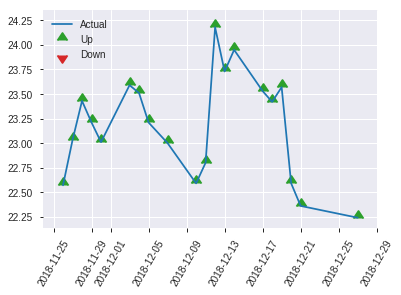


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.25471283167812814
RMSE: 0.504690827812561
LogLoss: 0.7035101441651849
Mean Per-Class Error: 0.4463957457983193
AUC: 0.5369616596638656
pr_auc: 0.5106377254654813
Gini: 0.07392331932773111
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3122812807559967: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      5    123  0.9609   (123.0/128.0)
1      2    117  0.0168   (2.0/119.0)
Total  7    240  0.5061   (125.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.312281     0.651811  239
max f2                       0.231699     0.82296   246
max f0point5                 0.396814     0.543131  204
max accuracy                 0.583436     0.562753  60
max precision                0.73909      1         0
max recall                   0.231699     1         246
max specificity              0.73909      1         0
max absolute_mcc             0.583436     0.124219  60
max min_per_class_accuracy   0.513867     0.537815  122
max mean_per_class_accuracy  0.583436     0.553604  60

Gains/Lift Table: Avg response rate: 48.18 %, avg score: 50.73 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0121457                   0.716917           0.691877  0.691877           0.333333         0.730803  0.333333                    0.730803            0.00840336      0.00840336                 -30.8123   -30.8123
    2        0.0202429                   0.707583           2.07563   1.24538            1                0.714458  0.6                         0.724265            0.0168067       0.0252101                  107.563    24.5378
    3        0.0323887                   0.699387           0         0.778361           0                0.704583  0.375                       0.716884            0               0.0252101                  -100       -22.1639
    4        0.0404858                   0.697062           1.03782   0.830252           0.5              0.698106  0.4                         0.713129            0.00840336      0.0336134                  3.78151    -16.9748
    5        0.0526316                   0.686124           2.07563   1.11765            1                0.693181  0.538462                    0.708525            0.0252101       0.0588235                  107.563    11.7647
    6        0.101215                    0.644316           1.21078   1.16235            0.583333         0.660587  0.56                        0.685515            0.0588235       0.117647                   21.0784    16.2353
    7        0.149798                    0.612933           1.21078   1.17806            0.583333         0.629793  0.567568                    0.667443            0.0588235       0.176471                   21.0784    17.806
    8        0.202429                    0.595804           1.11765   1.16235            0.538462         0.603935  0.56                        0.650931            0.0588235       0.235294                   11.7647    16.2353
    9        0.299595                    0.563852           0.951331  1.09391            0.458333         0.580969  0.527027                    0.628241            0.092437        0.327731                   -4.86695   9.39132
    10       0.40081                     0.537201           0.913277  1.0483             0.44             0.549449  0.505051                    0.608344            0.092437        0.420168                   -8.67227   4.82981
    11       0.502024                    0.512566           1.16235   1.07129            0.56             0.522828  0.516129                    0.591103            0.117647        0.537815                   16.2353    7.1293
    12       0.59919                     0.488174           0.778361  1.02379            0.375            0.499335  0.493243                    0.576221            0.0756303       0.613445                   -22.1639   2.37906
    13       0.700405                    0.457334           0.996303  1.01982            0.48             0.472178  0.491329                    0.561186            0.10084         0.714286                   -0.369748  1.98183
    14       0.797571                    0.405802           1.03782   1.02201            0.5              0.435757  0.492386                    0.545905            0.10084         0.815126                   3.78151    2.20108
    15       0.898785                    0.36091            0.830252  1.00042            0.4              0.387815  0.481982                    0.528102            0.0840336       0.89916                    -16.9748   0.0416383
    16       1                           0.231699           0.996303  1                  0.48             0.322569  0.481781                 

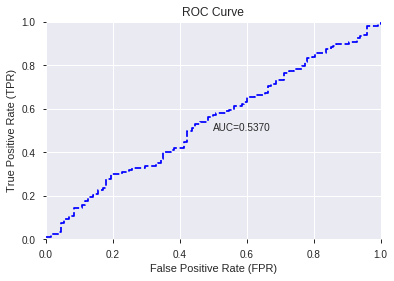

This function is available for GLM models only


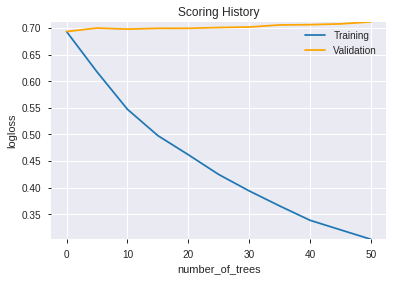

--2019-08-26 14:15:27--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.186.107
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.186.107|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at he

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190826_141513_model_5',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190826_141513_model_5',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_66_sid_97b9',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['ROCR100_12',
 'DX_12',
 'BBANDS_upperband_8_0_5',
 'NATR_14',
 'PLUS_DI_14',
 'MOM_14',
 'week',
 'ROC_14',
 'ADXR_14',
 'BBANDS_lowerband_8_6_4',
 'PLUS_DI_24',
 'BBANDS_upperband_8_3_5',
 'MAVP_8_6',
 'AROONOSC_8',
 'BBANDS_lowerband_12_4_5',
 'BBANDS_lowerband_20_0_4',
 'NATR_20',
 'BBANDS_upperband_14_2_5',
 'BBANDS_lowerband_30_1_5',
 'BBANDS_upperband_8_8_5',
 'ROCR100_14',
 'BBANDS_lowerband_14_5_4',
 'BBANDS_lowerband_24_1_4',
 'BBANDS_upperband_14_7_5',
 'BBANDS_upperband_12_0_2',
 'BBANDS_upperband_24_6_5',
 'BBANDS_upperband_24_0_5',
 'BBANDS_middleband_12_3_5',
 'BBANDS_upperband_24_1_4',
 'BBANDS_middleband_12_2_5',
 'BBANDS_upperband_20_7_2',
 'MA_12_0',
 'LINEARREG_30',
 'BBANDS_upperband_24_2_3',
 'BBANDS_upperband_24_5_2',
 'BBANDS_middleband_24_0_4',
 'BBANDS_middleband_14_5_5',
 'MIDPRICE_20',
 'BBANDS_middleband_24_5_2',
 'BBANDS_middleband_30_7_2',
 'BBANDS_middleband_30_0_3',
 'BBANDS_middleband_14_0_3',
 'MAVP_30_6',
 'CDLSHOOTINGSTAR',
 'CDLINNECK',
 'CDLSTICK

In [21]:
# XGBoost with top XGBoost features
model_train(feature_name='XGBF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

In [0]:
# PCA
try:
  del xgb_features,glm_features,dl_features
except:
  pass
gc.collect()

if features_to_include is True or 'PCA' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.pca import H2OPrincipalComponentAnalysisEstimator
      h2o_model = H2OPrincipalComponentAnalysisEstimator(seed=1, k=PCA_k, pca_method="GramSVD", max_iterations=10000)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OPrincipalComponentAnalysisEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [23]:
# DeepLearning with PCA
model_train(feature_name='PCA',model_algo="DeepLearning",training_frame=training_frame)

[]

In [24]:
# GLM with PCA
model_train(feature_name='PCA',model_algo="GLM",training_frame=training_frame)

[]

In [25]:
# XGBoost with PCA
model_train(feature_name='PCA',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# Generalized Low Rank
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'GLRM' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator

      h2o_model = H2OGeneralizedLowRankEstimator(seed=1, k=GLRM_k)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OGeneralizedLowRankEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [27]:
# DeepLearning with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="DeepLearning",training_frame=training_frame)

[]

In [28]:
# GLM with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="GLM",training_frame=training_frame)

[]

In [29]:
# XGBoost with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# High Correlation Filter 
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'HCF' in features_to_include:
  corr_matrix = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).corr().abs()

  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

  features_list = [column for column in upper.columns if not any(upper[column] > HCF_threshold)]

  del corr_matrix, upper
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [31]:
# DeepLearning with low correlation features
model_train(feature_name='HCF',model_algo="DeepLearning",features_list=features_list)

[]

In [32]:
# GLM with low correlation features
model_train(feature_name='HCF',model_algo="GLM",features_list=features_list)

[]

In [33]:
# XGBoost with low correlation features
model_train(feature_name='HCF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
#	Low Variance Filter  
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'LVF' in features_to_include:
  df_variance = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).var()
  features_list = [column for column in df_variance.index if df_variance[column]  > LVF_threshold]

  del df_variance
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [35]:
# DeepLearning with Low Variance features  
model_train(feature_name='LVF',model_algo="DeepLearning",features_list=features_list)

[]

In [36]:
# GLM with Low Variance features  
model_train(feature_name='LVF',model_algo="GLM",features_list=features_list)

[]

In [37]:
# XGBoost with Low Variance features  
model_train(feature_name='LVF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select k best features
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'KBest' in features_to_include:
  from sklearn.feature_selection import SelectKBest
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectKBest(score_func=f_classif, k=select_k).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectKBest, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [39]:
# DeepLearning with Select k best features 
model_train(feature_name='KBest',model_algo="DeepLearning",features_list=features_list)

[]

In [40]:
# GLM with Select k best features
model_train(feature_name='KBest',model_algo="GLM",features_list=features_list)

[]

In [41]:
# XGBoost with Select k best features
model_train(feature_name='KBest',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select Percentile
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Percentile' in features_to_include:
  from sklearn.feature_selection import SelectPercentile
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectPercentile(score_func=f_classif, percentile=select_percentile).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectPercentile, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [43]:
# DeepLearning with Select Percentile features  
model_train(feature_name='Percentile',model_algo="DeepLearning",features_list=features_list)

[]

In [44]:
# GLM with Select Percentile features  
model_train(feature_name='Percentile',model_algo="GLM",features_list=features_list)

[]

In [45]:
# XGBoost with Select Percentile features  
model_train(feature_name='Percentile',model_algo="XGBoost",features_list=features_list)

[]

In [46]:
# Select Family-wise error
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Fwe' in features_to_include:
  from sklearn.feature_selection import SelectFwe
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectFwe(score_func=f_classif, alpha=select_alpha).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectFwe, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

0

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc    logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190826_141541_model_4  0.508666  16.640139                   0.5  0.694105  0.481781
1  DeepLearning_grid_1_AutoML_20190826_141541_model_1  0.500000  17.898637                   0.5  0.719874  0.518219
2  DeepLearning_grid_1_AutoML_20190826_141541_model_7  0.500000  17.898637                   0.5  0.719874  0.518219
3  DeepLearning_grid_1_AutoML_20190826_141541_model_3  0.500000  16.640139                   0.5  0.694105  0.481781
4  DeepLearning_grid_1_AutoML_20190826_141541_model_9  0.500000   0.700583                   0.5  0.503691  0.253705
5  DeepLearning_grid_1_AutoML_20190826_141541_model_6  0.500000   0.703291                   0.5  0.505020  0.255045
6  DeepLearning_grid_1_AutoML_20190826_141541_model_8  0.500000   0.707194                   0.5  0.506919  0.256967
7               DeepLearning_1_AutoML_20190826_141541  0.500000  17.898637                   0.5  0.719874  0.518219
8  DeepLearning_grid_1_AutoML_20190826_141541_model_2  0.500000  17.898637                   0.5  0.719874  0.518219
9  DeepLearning_grid_1_AutoML_20190826_141541_model_5  0.500000   0.698602                   0.5  0.502714  0.252721

variable  relative_importance  scaled_importance  percentage
0           CDL3WHITESOLDIERS             1.000000           1.000000    0.003049
1          CDLMORNINGDOJISTAR             0.989667           0.989667    0.003018
2             CDLLADDERBOTTOM             0.989229           0.989229    0.003016
3            CDLSTICKSANDWICH             0.983211           0.983211    0.002998
4                   CDLONNECK             0.980551           0.980551    0.002990
...                       ...                  ...                ...         ...
1035  BBANDS_lowerband_24_1_3             0.270366           0.270366    0.000824
1036                 WILLR_30             0.269496           0.269496    0.000822
1037   BBANDS_upperband_8_6_2             0.268368           0.268368    0.000818
1038  BBANDS_upperband_30_5_4             0.268170           0.268170    0.000818
1039                MAVP_14_5             0.263399           0.263399    0.000803

[1040 rows x 4 columns]

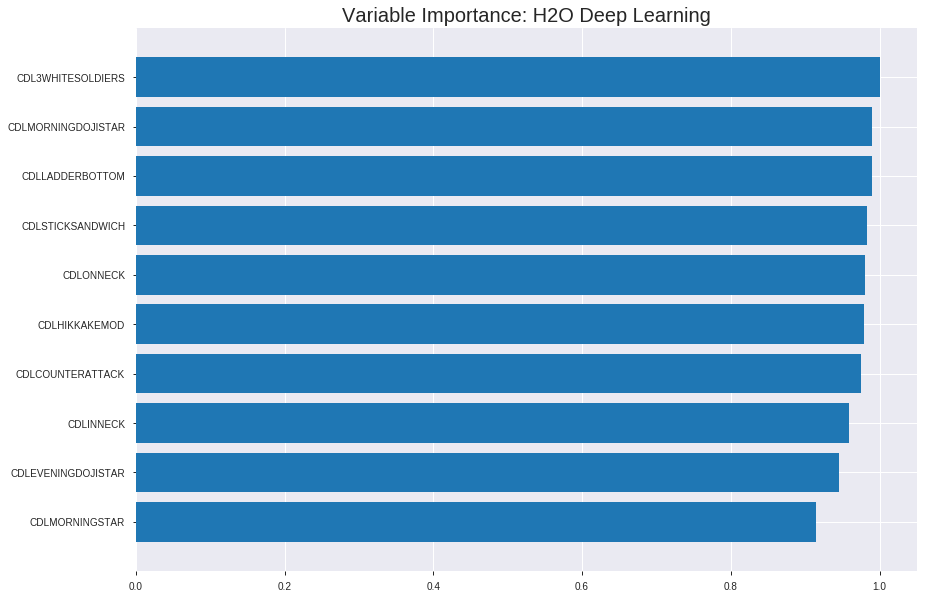

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190826_141541_model_4


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.20318947579773677
RMSE: 0.4507654332330029
LogLoss: 0.615905430722787
Mean Per-Class Error: 0.29477435646790484
AUC: 0.7748723797110895
pr_auc: 0.7793183568644266
Gini: 0.5497447594221789
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4947573471958225: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      448  344   0.4343   (344.0/792.0)
1      155  775   0.1667   (155.0/930.0)
Total  603  1119  0.2898   (499.0/1722.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.494757     0.756467  227
max f2                       0.0639375    0.865078  374
max f0point5                 0.718391     0.735794  141
max accuracy                 0.531665     0.711963  214
max precision                0.999151     1         0
max recall                   0.0112993    1         394
max specificity              0.999151     1         0
max absolute_mcc             0.518586     0.419088  219
max min_per_class_accuracy   0.664351     0.698925  165
max mean_per_class_accuracy  0.718391     0.705226  141

Gains/Lift Table: Avg response rate: 54.01 %, avg score: 60.62 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010453                    0.99759            1.85161   1.85161            1                0.998727   1                           0.998727            0.0193548       0.0193548                  85.1613   85.1613
    2        0.0203252                   0.994707           1.74269   1.79871            0.941176         0.996331   0.971429                    0.997563            0.0172043       0.0365591                  74.2694   79.871
    3        0.0301974                   0.991835           1.74269   1.7804             0.941176         0.993225   0.961538                    0.996145            0.0172043       0.0537634                  74.2694   78.0397
    4        0.0400697                   0.989277           1.52486   1.71744            0.823529         0.990925   0.927536                    0.994859            0.0150538       0.0688172                  52.4858   71.7438
    5        0.0505226                   0.985371           1.74875   1.72392            0.944444         0.987218   0.931034                    0.993278            0.0182796       0.0870968                  74.8746   72.3915
    6        0.100465                    0.967412           1.46407   1.59474            0.790698         0.976721   0.861272                    0.985047            0.0731183       0.160215                   46.4066   59.4742
    7        0.150407                    0.942288           1.67937   1.62284            0.906977         0.956174   0.876448                    0.97546             0.083871        0.244086                   67.937    62.2842
    8        0.200348                    0.916075           1.4856    1.58863            0.802326         0.928351   0.857971                    0.963717            0.0741935       0.31828                    48.5596   58.863
    9        0.300232                    0.855027           1.32412   1.50063            0.715116         0.887289   0.810445                    0.93829             0.132258        0.450538                   32.4119   50.063
    10       0.400116                    0.779369           1.21647   1.42969            0.656977         0.819059   0.772134                    0.908526            0.121505        0.572043                   21.6467   42.9692
    11       0.5                         0.678509           1.10881   1.36559            0.598837         0.729083   0.737515                    0.872679            0.110753        0.682796                   10.8815   36.5591
    12       0.599884                    0.560078           1.02269   1.3085             0.552326         0.620136   0.70668                     0.830629            0.102151        0.784946                   2.26932   30.8497
    13       0.699768                    0.422536           0.785859  1.2339             0.424419         0.493982   0.66639                     0.782577            0.0784946       0.863441                   -21.4141  23.3896
    14       0.799652                    0.265028           0.592086  1.15373            0.319767         0.348857   0.623094                    0.728401            0.0591398       0.922581                   -40.7914  15.3728
    15       0.899535                    0.112622           0.549025  1.08658            0.296512         0.187101   0.58683                     0.668295            0.0548387       0.977419                   -45.0975  8.65824
    16       1                           0.000633803        0.224762  1                  0.121387         0.0498422  0.54007                     0.



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.4125960656094793
RMSE: 0.6423364115550972
LogLoss: 3.016205192745564
Mean Per-Class Error: 0.4704427280529052
AUC: 0.5161879280461743
pr_auc: 0.5904262026178895
Gini: 0.03237585609234861
Confusion Matrix (Act/Pred) for max f1 @ threshold = 1.1968640642155163e-08: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    213  1        (213.0/213.0)
1      0    279  0        (0.0/279.0)
Total  0    492  0.4329   (213.0/492.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       1.19686e-08  0.723735   399
max f2                       1.19686e-08  0.867537   399
max f0point5                 1.19686e-08  0.620828   399
max accuracy                 1.19686e-08  0.567073   399
max precision                0.991072     1          0
max recall                   1.19686e-08  1          399
max specificity              0.991072     1          0
max absolute_mcc             0.975735     0.0899612  18
max min_per_class_accuracy   0.172056     0.519713   241
max mean_per_class_accuracy  0.24257      0.529557   224

Gains/Lift Table: Avg response rate: 56.71 %, avg score: 33.85 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101626                   0.98746            1.41075   1.41075            0.8              0.989168     0.8                         0.989168            0.0143369       0.0143369                  41.0753   41.0753
    2        0.0203252                   0.981731           1.05806   1.23441            0.6              0.985752     0.7                         0.98746             0.0107527       0.0250896                  5.80645   23.4409
    3        0.0304878                   0.978864           1.76344   1.41075            1                0.980293     0.8                         0.985071            0.0179211       0.0430108                  76.3441   41.0753
    4        0.0406504                   0.973002           1.05806   1.32258            0.6              0.976441     0.75                        0.982914            0.0107527       0.0537634                  5.80645   32.2581
    5        0.050813                    0.965722           1.05806   1.26968            0.6              0.969599     0.72                        0.980251            0.0107527       0.0645161                  5.80645   26.9677
    6        0.101626                    0.90186            0.916989  1.09333            0.52             0.93609      0.62                        0.95817             0.046595        0.111111                   -8.30108  9.33333
    7        0.150407                    0.816868           0.955197  1.04853            0.541667         0.865463     0.594595                    0.928103            0.046595        0.157706                   -4.48029  4.85324
    8        0.20122                     0.751688           1.05806   1.05094            0.6              0.784616     0.59596                     0.891869            0.0537634       0.21147                    5.80645   5.09395
    9        0.300813                    0.619239           1.07966   1.06045            0.612245         0.690792     0.601351                    0.825296            0.107527        0.318996                   7.96577   6.04475
    10       0.400407                    0.398582           0.899715  1.02047            0.510204         0.50309      0.57868                     0.745154            0.0896057       0.408602                   -10.0285  2.04683
    11       0.5                         0.171394           1.11565   1.03943            0.632653         0.272128     0.589431                    0.650933            0.111111        0.519713                   11.5646   3.94265
    12       0.599593                    0.040627           0.899715  1.01622            0.510204         0.100278     0.576271                    0.559468            0.0896057       0.609319                   -10.0285  1.62202
    13       0.699187                    0.0116104          0.899715  0.999625           0.510204         0.0222054    0.56686                     0.48294             0.0896057       0.698925                   -10.0285  -0.0375094
    14       0.79878                     0.0035951          1.00768   1.00063            0.571429         0.00656961   0.56743                     0.423545            0.100358        0.799283                   0.768049  0.0629292
    15       0.898374                    0.000289987        0.935703  0.993432           0.530612         0.00191468   0.563348                    0.376803            0.09319         0.892473                   -6.42967  -0.656838
    16       1                           4.54797e-49        1.05806   1                  0.6           


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-26 14:21:51  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-26 14:21:57  8.791 sec         135 obs/sec       0.430314  1             741        0.652661         2.87873             -0.714878      0.526603        0.568536           1.23441          0.45993                          0.753043           18.195                -1.30986         0.531333          0.610338             1.05806            0.432927
    2019-08-26 14:22:30  40.812 sec        166 obs/sec       3.39605   8             5848       0.578538         1.82141             -0.347477      0.570425        0.605612           1.23441          0.45993                          0.753043           16.5999               -1.30986         0.511855          0.603829             1.76344            0.432927
    2019-08-26 14:22:56  1 min  6.595 sec  175 obs/sec       5.9367    14            10223      0.63539          2.6127              -0.625323      0.581144        0.638103           1.54301          0.45993                          0.753043           17.6565               -1.30986         0.503525          0.57802              1.05806            0.432927
    2019-08-26 14:23:23  1 min 34.305 sec  183 obs/sec       8.93206   21            15381      0.583778         1.29441             -0.371999      0.61751         0.660188           1.64588          0.45993                          0.707505           5.64773               -1.03895         0.525679          0.612486             1.41075            0.432927
    2019-08-26 14:23:49  2 min  0.495 sec  190 obs/sec       11.8955   28            20484      0.583713         1.14114             -0.371695      0.666366        0.709867           1.85161          0.44367                          0.741815           10.5411               -1.24149         0.522456          0.600366             1.76344            0.432927
    2019-08-26 14:24:15  2 min 25.707 sec  196 obs/sec       14.856    35            25582      0.521829         1.28378             -0.0962641     0.657912        0.557769           1.64588          0.408827                         0.657972           12.5521               -0.76344         0.48467           0.109263             0.914035           0.428862
    2019-08-26 14:24:40  2 min 50.825 sec  201 obs/sec       17.8624   42            30759      0.457508         0.609806            0.157333       0.74278         0.756548           1.85161          0.329268                         0.630294           3.24562               -0.618201        0.483046          0.546872             0.705376           0.432927
    2019-08-26 14:25:07  3 min 18.096 sec  205 obs/sec       21.2364   50            36569      0.452651         0.605215            0.175131       0.767579        0.791733           1.85161          0.321719                         0.738352           6.13339               -1.22062         0.525838          0.620498             1.76344            0.432927
    2019-08-26 14:25:34

Variable Importances: 


variable                 relative_importance    scaled_importance    percentage
-----------------------  ---------------------  -------------------  ---------------------
CDL3WHITESOLDIERS        1.0                    1.0                  0.003049011111743676
CDLMORNINGDOJISTAR       0.9896672368049622     0.9896672368049622   0.0030175064019469892
CDLLADDERBOTTOM          0.9892287254333496     0.9892287254333496   0.0030161693759023166
CDLSTICKSANDWICH         0.9832112193107605     0.9832112193107605   0.002997821932869557
CDLONNECK                0.9805508255958557     0.9805508255958557   0.0029897103628711993
---                      ---                    ---                  ---
BBANDS_lowerband_24_1_3  0.27036604285240173    0.27036604285240173  0.0008243490688951397
WILLR_30                 0.26949575543403625    0.26949575543403625  0.0008216955528861327
BBANDS_upperband_8_6_2   0.26836758852005005    0.26836758852005005  0.0008182557594294871
BBANDS_upperband_30_5_4  0.2681698501110077     0.2681698501110077   0.0008176528528230985
MAVP_14_5                0.2633987069129944     0.2633987069129944   0.0008031055841966356


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5263157894736842)

('F1', 0.6502732240437158)

('auc', 0.5086659663865546)

('logloss', 16.640139234795015)

('mean_per_class_error', 0.4913012079831933)

('rmse', 0.6941047302231981)

('mse', 0.4817813765182186)

deeplearning prediction progress: |███████████████████████████████████████| 100%


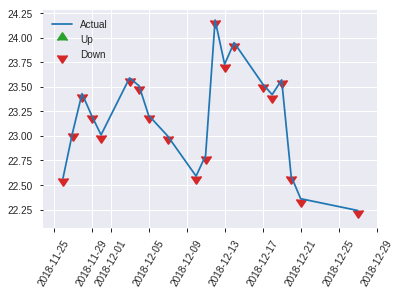


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.4817813765182186
RMSE: 0.6941047302231981
LogLoss: 16.640139234795015
Mean Per-Class Error: 0.4913012079831933
AUC: 0.5086659663865546
pr_auc: 0.6112183739892718
Gini: 0.017331932773109182
Confusion Matrix (Act/Pred) for max f1 @ threshold = 2.9460492241732e-53: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    128  1        (128.0/128.0)
1      0    119  0        (0.0/119.0)
Total  0    247  0.5182   (128.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       2.94605e-53  0.650273   4
max f2                       2.94605e-53  0.82296    4
max f0point5                 2.94605e-53  0.537489   4
max accuracy                 1.57907e-45  0.526316   3
max precision                2.49335e-30  1          0
max recall                   2.94605e-53  1          4
max specificity              2.49335e-30  1          0
max absolute_mcc             1.57907e-45  0.0688707  3
max min_per_class_accuracy   1.57907e-45  0.0252101  3
max mean_per_class_accuracy  1.57907e-45  0.508699   3

Gains/Lift Table: Avg response rate: 48.18 %, avg score:  0.00 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score         cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ------------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0121457                   1.81918e-43        1.38375   1.38375            0.666667         8.31116e-31   0.666667                    8.31116e-31         0.0168067       0.0168067                  38.3754    38.3754
    2        0.0202429                   3.02417e-51        2.07563   1.6605             1                7.89534e-46   0.8                         4.9867e-31          0.0168067       0.0336134                  107.563    66.0504
    3        0.0323887                   2.11357e-53        1.38375   1.55672            0.666667         1.15269e-51   0.75                        3.11669e-31         0.0168067       0.0504202                  38.3754    55.6723
    4        0.0404858                   8.17634e-57        2.07563   1.6605             1                3.16225e-54   0.8                         2.49335e-31         0.0168067       0.0672269                  107.563    66.0504
    5        0.0526316                   2.63862e-59        0.691877  1.43697            0.333333         1.40466e-57   0.692308                    1.91796e-31         0.00840336      0.0756303                  -30.8123   43.6975
    6        0.101215                    9.90413e-78        0.691877  1.07933            0.333333         1.34928e-62   0.52                        9.97339e-32         0.0336134       0.109244                   -30.8123   7.93277
    7        0.149798                    4.62401e-105       0.864846  1.00977            0.416667         3.46041e-79   0.486486                    6.73878e-32         0.0420168       0.151261                   -13.5154   0.976607
    8        0.202429                    9.30673e-135       1.11765   1.03782            0.538462         3.4684e-106   0.5                         4.9867e-32          0.0588235       0.210084                   11.7647    3.78151
    9        1                           0                  0.990402  1                  0.477157         8.22269e-157  0.481781                    1.00945e-32         0.789916        1                          -0.959775  0

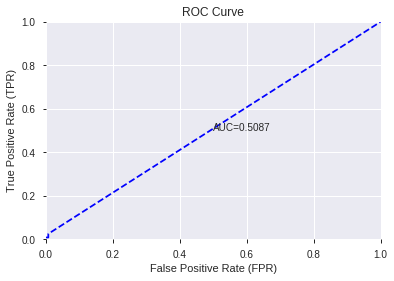

This function is available for GLM models only


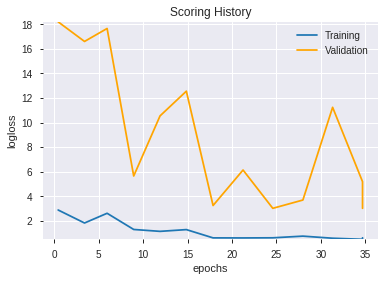

--2019-08-26 14:47:50--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.36.12
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.36.12|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190826_141541_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190826_141541_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_74_sid_97b9',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['CDL3WHITESOLDIERS',
 'CDLMORNINGDOJISTAR',
 'CDLLADDERBOTTOM',
 'CDLSTICKSANDWICH',
 'CDLONNECK',
 'CDLHIKKAKEMOD',
 'CDLCOUNTERATTACK',
 'CDLINNECK',
 'CDLEVENINGDOJISTAR',
 'CDLMORNINGSTAR',
 'CDLSTALLEDPATTERN',
 'CDLPIERCING',
 'CDLADVANCEBLOCK',
 'CDLINVERTEDHAMMER',
 'CDLSEPARATINGLINES',
 'CDLTASUKIGAP',
 'CDLEVENINGSTAR',
 'CDLTHRUSTING',
 'CDLXSIDEGAP3METHODS',
 'CDLHOMINGPIGEON',
 'is_quarter_start',
 'CDLDARKCLOUDCOVER',
 'is_quarter_end',
 'CDL3INSIDE',
 'CDLDRAGONFLYDOJI',
 'CDLHAMMER',
 'CDLSHOOTINGSTAR',
 'CDLTAKURI',
 'CDLGRAVESTONEDOJI',
 'CDLMATCHINGLOW',
 'CDLHANGINGMAN',
 'is_month_start',
 'is_month_end',
 'CDLDOJISTAR',
 'CDLHARAMICROSS',
 'TANH',
 'CDL3OUTSIDE',
 'BOP',
 'day',
 'OBV',
 'dayofweek',
 'EXP',
 'HT_PHASOR_quadrature',
 'weekday',
 'HT_DCPERIOD',
 'SINH',
 'CDLDOJI',
 'weekday_name',
 'COSH',
 'HT_TRENDMODE',
 'CDLRICKSHAWMAN',
 'HT_PHASOR_inphase',
 'CORREL_8',
 'BETA_8',
 'Volume',
 'AD',
 'CORREL_24',
 'aroonup_12',
 'CORREL_20',
 'aroondown_8',

In [47]:
# DeepLearning with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc    logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190826_144803_model_1  0.490415  14.279517                   0.5  0.693979  0.481606

variable  relative_importance  scaled_importance    percentage
0                      BETA_12         1.042013e-02           1.000000  1.160401e-02
1          CDLGAPSIDESIDEWHITE         1.030562e-02           0.989011  1.147649e-02
2                          OBV         9.987856e-03           0.958515  1.112262e-02
3                  CDLHIGHWAVE         9.659261e-03           0.926981  1.075669e-02
4                          day         9.238971e-03           0.886646  1.028865e-02
...                        ...                  ...                ...           ...
1035    BBANDS_upperband_8_3_4         2.376689e-06           0.000228  2.646715e-06
1036  BBANDS_middleband_14_3_4         1.977906e-06           0.000190  2.202625e-06
1037                 MAVP_24_2         1.580899e-06           0.000152  1.760512e-06
1038                 MAVP_24_6         1.170843e-06           0.000112  1.303868e-06
1039   BBANDS_upperband_24_7_2         5.950139e-07           0.000057  6.626160e-07

[1040 rows x 4 columns]

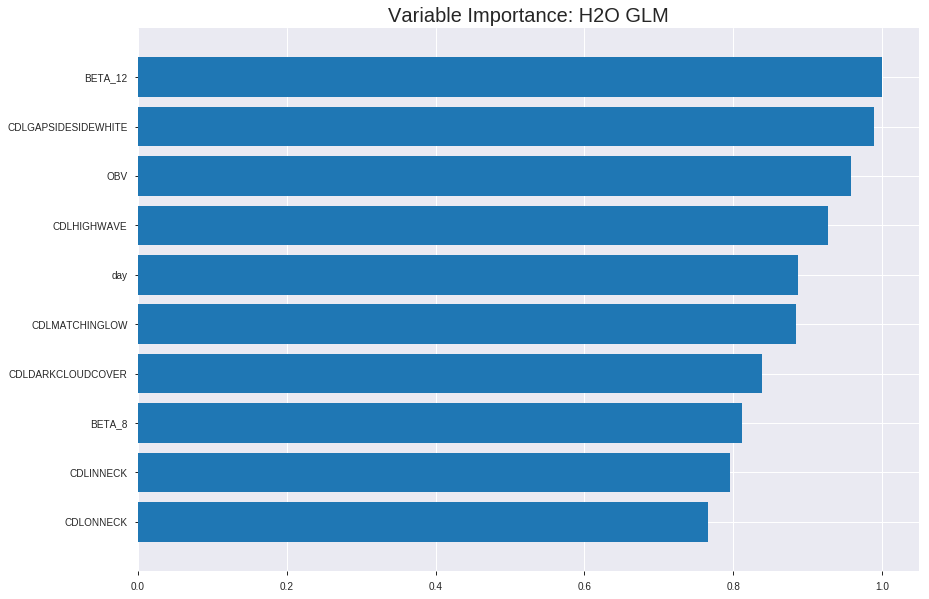

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190826_144803_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24467292908015342
RMSE: 0.4946442449681927
LogLoss: 0.6824255984543578
Null degrees of freedom: 1721
Residual degrees of freedom: 681
Null deviance: 2376.1277882295276
Residual deviance: 2350.273761076808
AIC: 4432.273761076808
AUC: 0.6089598946453786
pr_auc: 0.632664266610304
Gini: 0.21791978929075717
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5059906878999328: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      65   727   0.9179   (727.0/792.0)
1      26   904   0.028    (26.0/930.0)
Total  91   1631  0.4373   (753.0/1722.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.505991     0.705974  351
max f2                       0.478302     0.855251  394
max f0point5                 0.526544     0.619381  276
max accuracy                 0.526544     0.587108  276
max precision                0.624019     1         0
max recall                   0.478302     1         394
max specificity              0.624019     1         0
max absolute_mcc             0.543932     0.170679  186
max min_per_class_accuracy   0.539048     0.577419  213
max mean_per_class_accuracy  0.543932     0.58427   186

Gains/Lift Table: Avg response rate: 54.01 %, avg score: 54.01 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010453                    0.597829           1.64588   1.64588            0.888889         0.606678  0.888889                    0.606678            0.0172043       0.0172043                  64.5878   64.5878
    2        0.0203252                   0.590751           1.08918   1.37548            0.588235         0.59351   0.742857                    0.600282            0.0107527       0.027957                   8.91841   37.5484
    3        0.0301974                   0.58601            1.41594   1.38871            0.764706         0.587811  0.75                        0.596205            0.0139785       0.0419355                  41.5939   38.871
    4        0.0400697                   0.58135            1.30702   1.36858            0.705882         0.583104  0.73913                     0.592977            0.0129032       0.0548387                  30.7021   36.8583
    5        0.0505226                   0.578386           1.02867   1.29826            0.555556         0.580095  0.701149                    0.590312            0.0107527       0.0655914                  2.86738   29.8257
    6        0.100465                    0.568916           1.22723   1.26295            0.662791         0.572413  0.682081                    0.581414            0.0612903       0.126882                   22.7232   26.295
    7        0.150407                    0.561251           1.24876   1.25824            0.674419         0.56525   0.679537                    0.576047            0.0623656       0.189247                   24.8762   25.8239
    8        0.200348                    0.557509           1.29182   1.26661            0.697674         0.559314  0.684058                    0.571876            0.0645161       0.253763                   29.1823   26.6611
    9        0.300232                    0.550363           1.09805   1.21053            0.593023         0.553609  0.653772                    0.565799            0.109677        0.363441                   9.80495   21.0532
    10       0.400116                    0.544272           1.10881   1.18514            0.598837         0.54723   0.640058                    0.561163            0.110753        0.474194                   10.8815   18.514
    11       0.5                         0.539282           0.958102  1.13978            0.517442         0.541684  0.615563                    0.557272            0.0956989       0.569892                   -4.1898   13.9785
    12       0.599884                    0.534221           1.00116   1.1167             0.540698         0.536733  0.603098                    0.553852            0.1             0.669892                   0.116279  11.6704
    13       0.699768                    0.528527           0.904276  1.08638            0.488372         0.531614  0.586722                    0.550678            0.0903226       0.760215                   -9.57239  8.6382
    14       0.799652                    0.522084           0.882746  1.06095            0.476744         0.525519  0.572985                    0.547535            0.088172        0.848387                   -11.7254  6.0946
    15       0.899535                    0.513011           0.807389  1.03279            0.436047         0.518208  0.557779                    0.544279            0.0806452       0.929032                   -19.2611  3.27912
    16       1                           0.46836            0.706396  1                  0.381503         0.502381  0.54007                     0.54007             0.



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.265392047145964
RMSE: 0.5151621561663512
LogLoss: 0.7797918381571665
Null degrees of freedom: 491
Residual degrees of freedom: -549
Null deviance: 674.6256660447343
Residual deviance: 767.3151687466518
AIC: 2849.3151687466516
AUC: 0.47571810793073854
pr_auc: 0.5491946049367714
Gini: -0.048563784138522914
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.0011855611815654104: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      3    210  0.9859   (210.0/213.0)
1      0    279  0        (0.0/279.0)
Total  3    489  0.4268   (210.0/492.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.00118556   0.726562  397
max f2                       0.00118556   0.869159  397
max f0point5                 0.00118556   0.624161  397
max accuracy                 0.00118556   0.573171  397
max precision                0.628486     0.75      3
max recall                   0.00118556   1         397
max specificity              0.63225      0.995305  0
max absolute_mcc             0.581348     0.106986  137
max min_per_class_accuracy   0.570377     0.478873  190
max mean_per_class_accuracy  0.558959     0.513958  244

Gains/Lift Table: Avg response rate: 56.71 %, avg score: 53.17 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101626                   0.625595           1.05806   1.05806            0.6              0.629594  0.6                         0.629594            0.0107527       0.0107527                  5.80645   5.80645
    2        0.0203252                   0.618052           1.05806   1.05806            0.6              0.62127   0.6                         0.625432            0.0107527       0.0215054                  5.80645   5.80645
    3        0.0304878                   0.615957           1.05806   1.05806            0.6              0.616852  0.6                         0.622572            0.0107527       0.0322581                  5.80645   5.80645
    4        0.0406504                   0.613282           1.41075   1.14624            0.8              0.615047  0.65                        0.620691            0.0143369       0.046595                   41.0753   14.6237
    5        0.050813                    0.610422           0.352688  0.987527           0.2              0.611905  0.56                        0.618934            0.00358423      0.0501792                  -64.7312  -1.24731
    6        0.101626                    0.603633           0.775914  0.88172            0.44             0.60694   0.5                         0.612937            0.0394265       0.0896057                  -22.4086  -11.828
    7        0.150407                    0.598263           0.955197  0.905551           0.541667         0.600765  0.513514                    0.608989            0.046595        0.136201                   -4.48029  -9.44493
    8        0.20122                     0.593358           1.19914   0.979689           0.68             0.5959    0.555556                    0.605684            0.0609319       0.197133                   19.914    -2.03106
    9        0.300813                    0.585128           0.683783  0.88172            0.387755         0.589111  0.5                         0.600197            0.0681004       0.265233                   -31.6217  -11.828
    10       0.400407                    0.577204           1.04367   0.922002           0.591837         0.580942  0.522843                    0.595408            0.103943        0.369176                   4.36691   -7.79979
    11       0.5                         0.57026            1.15163   0.967742           0.653061         0.573811  0.54878                     0.591106            0.114695        0.483871                   15.1635   -3.22581
    12       0.599593                    0.562577           1.22361   1.01024            0.693878         0.567166  0.572881                    0.58713             0.121864        0.605735                   22.3612   1.02424
    13       0.699187                    0.55321            0.827738  0.984246           0.469388         0.557781  0.55814                     0.582949            0.0824373       0.688172                   -17.2262  -1.57539
    14       0.79878                     0.539225           1.00768   0.987168           0.571429         0.546614  0.559796                    0.578419            0.100358        0.78853                    0.768049  -1.28321
    15       0.898374                    0.510382           1.07966   0.997421           0.612245         0.529187  0.565611                    0.572961            0.107527        0.896057                   7.96577   -0.25787
    16       1                           0.00068569         1.0228    1                  0.58             0.166661  0.567073                    0.53167  


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-26 14:48:06  0.000 sec   2            2.9       1041          1.36799           1.55996
    2019-08-26 14:48:08  1.912 sec   4            2.1       1041          1.36485           1.55958
    2019-08-26 14:48:10  3.786 sec   6            1.5       1041          1.36115           3.53202
    2019-08-26 14:48:12  5.719 sec   8            1.1       1041          1.35686           6.66102
    2019-08-26 14:48:14  7.565 sec   10           0.82      1041          1.35195           11.4763
    2019-08-26 14:48:16  9.385 sec   12           0.6       1041          1.34651           18.3288
    2019-08-26 14:48:18  11.173 sec  14           0.43      1041          1.34062           27.476

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5465587044534413)

('F1', 0.6502732240437158)

('auc', 0.49041491596638653)

('logloss', 14.279517241128547)

('mean_per_class_error', 0.46999737394957986)

('rmse', 0.6939786833485675)

('mse', 0.48160641294221124)

glm prediction progress: |████████████████████████████████████████████████| 100%


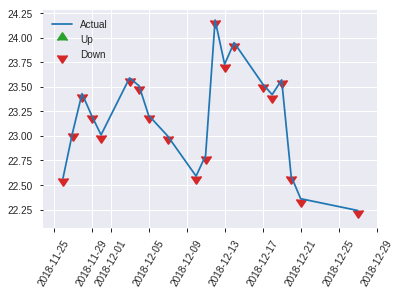


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.48160641294221124
RMSE: 0.6939786833485675
LogLoss: 14.279517241128547
Null degrees of freedom: 246
Residual degrees of freedom: -794
Null deviance: 345.4517445763613
Residual deviance: 103961.13774984881
AIC: 106043.13774984881
AUC: 0.49041491596638653
pr_auc: 0.49132048947410134
Gini: -0.019170168067226934
Confusion Matrix (Act/Pred) for max f1 @ threshold = 6.228345205970866e-64: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    128  1        (128.0/128.0)
1      0    119  0        (0.0/119.0)
Total  0    247  0.5182   (128.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       6.22835e-64  0.650273  78
max f2                       6.22835e-64  0.82296   78
max f0point5                 6.22835e-64  0.537489  78
max accuracy                 0.000180153  0.546559  10
max precision                0.0166705    1         0
max recall                   6.22835e-64  1         78
max specificity              0.0166705    1         0
max absolute_mcc             0.000180153  0.14535   10
max min_per_class_accuracy   3.53885e-21  0.294118  71
max mean_per_class_accuracy  0.000180153  0.530003  10

Gains/Lift Table: Avg response rate: 48.18 %, avg score:  0.01 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score         cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ------------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0121457                   0.00145783         1.38375   1.38375            0.666667         0.00762908    0.666667                    0.00762908          0.0168067       0.0168067                  38.3754   38.3754
    2        0.0202429                   0.000473021        2.07563   1.6605             1                0.000886124   0.8                         0.0049319           0.0168067       0.0336134                  107.563   66.0504
    3        0.0323887                   0.000320032        1.38375   1.55672            0.666667         0.000399201   0.75                        0.00323214          0.0168067       0.0504202                  38.3754   55.6723
    4        0.0404858                   0.000183821        2.07563   1.6605             1                0.000259809   0.8                         0.00263767          0.0168067       0.0672269                  107.563   66.0504
    5        0.0526316                   0.000111582        0.691877  1.43697            0.333333         0.000151836   0.692308                    0.00206402          0.00840336      0.0756303                  -30.8123  43.6975
    6        0.101215                    5.89583e-06        0.691877  1.07933            0.333333         3.71193e-05   0.52                        0.00109111          0.0336134       0.109244                   -30.8123  7.93277
    7        0.149798                    6.04924e-08        0.691877  0.953668           0.333333         1.49963e-06   0.459459                    0.00073772          0.0336134       0.142857                   -30.8123  -4.6332
    8        0.202429                    3.15983e-10        1.27731   1.03782            0.615385         1.30231e-08   0.5                         0.000545916         0.0672269       0.210084                   27.7311   3.78151
    9        0.299595                    4.24692e-26        0.864846  0.981717           0.416667         1.86506e-12   0.472973                    0.000368862         0.0840336       0.294118                   -13.5154  -1.8283
    10       0.40081                     2.2031e-201        1.24538   1.0483             0.6              3.05602e-28   0.505051                    0.000275715         0.12605         0.420168                   24.5378   4.82981
    11       0.502024                    8.55066e-277       1.24538   1.08803            0.6              3.48925e-204  0.524194                    0.000220128         0.12605         0.546218                   24.5378   8.8032
    12       1                           0                  0.911252  1                  0.439024         1.26331e-281  0.481781                    0.000110509         0.453782        1                          -8.87477  0

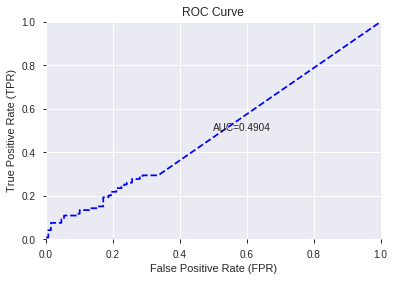

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


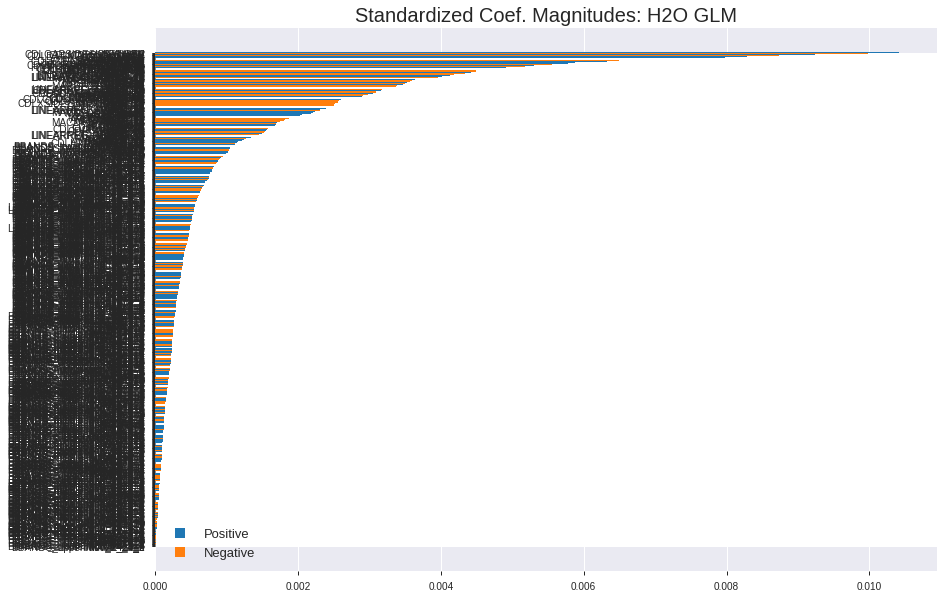

'log_likelihood'
--2019-08-26 14:48:38--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.133.3
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.133.3|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190826_144803_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190826_144803_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_82_sid_97b9',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_82_s

['BETA_12',
 'CDLGAPSIDESIDEWHITE',
 'OBV',
 'CDLHIGHWAVE',
 'day',
 'CDLMATCHINGLOW',
 'CDLDARKCLOUDCOVER',
 'BETA_8',
 'CDLINNECK',
 'CDLONNECK',
 'CDLHAMMER',
 'is_month_end',
 'weekday',
 'dayofweek',
 'aroondown_24',
 'CDLSPINNINGTOP',
 'TANH',
 'CDLEVENINGDOJISTAR',
 'MFI_30',
 'is_quarter_end',
 'CDLHIKKAKE',
 'AROONOSC_24',
 'HT_PHASOR_inphase',
 'BETA_14',
 'weekday_name',
 'CDLSTICKSANDWICH',
 'CDLMORNINGDOJISTAR',
 'BETA_30',
 'SIN',
 'HT_PHASOR_quadrature',
 'BOP',
 'MACDFIX_hist_24',
 'CDLCOUNTERATTACK',
 'CDL3WHITESOLDIERS',
 'is_quarter_start',
 'CDLHIKKAKEMOD',
 'CDLLADDERBOTTOM',
 'MACDFIX_hist_20',
 'ROC_30',
 'ROCR_30',
 'ROCR100_30',
 'ROCP_30',
 'aroonup_20',
 'CORREL_14',
 'ADOSC',
 'LINEARREG_ANGLE_8',
 'LINEARREG_SLOPE_8',
 'SAREXT',
 'LINEARREG_SLOPE_20',
 'LINEARREG_ANGLE_20',
 'CORREL_12',
 'AROONOSC_20',
 'STDDEV_14',
 'MACDFIX_signal_24',
 'STOCH_slowd',
 'MACDFIX_hist_14',
 'DX_30',
 'COS',
 'HT_TRENDMODE',
 'MFI_24',
 'aroonup_12',
 'STOCHF_fastk',
 'MACD

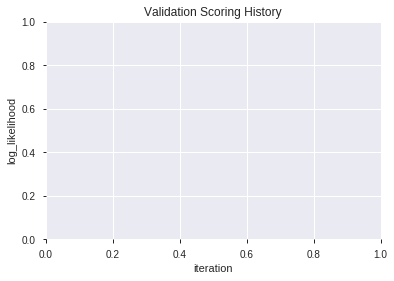

In [48]:
# GLM with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190826_144852_model_5  0.570772  0.692306              0.481355  0.499537  0.249537
1  XGBoost_grid_1_AutoML_20190826_144852_model_2  0.565060  0.694644              0.500000  0.500692  0.250693
2               XGBoost_1_AutoML_20190826_144852  0.550945  0.694973              0.496094  0.500707  0.250707
3  XGBoost_grid_1_AutoML_20190826_144852_model_4  0.543789  0.694625              0.500000  0.500663  0.250664
4  XGBoost_grid_1_AutoML_20190826_144852_model_3  0.541492  0.693504              0.488577  0.500219  0.250219
5  XGBoost_grid_1_AutoML_20190826_144852_model_6  0.539062  0.707548              0.500000  0.506631  0.256675
6  XGBoost_grid_1_AutoML_20190826_144852_model_7  0.532891  0.703656              0.492188  0.504901  0.254925
7               XGBoost_2_AutoML_20190826_144852  0.532235  0.699796              0.492188  0.503231  0.253241
8               XGBoost_3_AutoML_20190826_144852  0.511489  0.699768              0.466912  0.503279  0.253290
9  XGBoost_grid_1_AutoML_20190826_144852_model_1  0.505679  0.710172              0.500000  0.508204  0.258272

variable  relative_importance  scaled_importance  percentage
0                        day           460.891968           1.000000    0.019297
1                     Volume           410.266296           0.890157    0.017177
2                        BOP           370.644531           0.804190    0.015518
3                  dayofyear           354.695984           0.769586    0.014850
4                       Open           341.389221           0.740714    0.014293
..                       ...                  ...                ...         ...
615  BBANDS_lowerband_12_7_4             1.048416           0.002275    0.000044
616  BBANDS_lowerband_24_6_4             1.011423           0.002194    0.000042
617  BBANDS_lowerband_24_5_4             0.578921           0.001256    0.000024
618  BBANDS_upperband_14_0_3             0.500198           0.001085    0.000021
619                  quarter             0.351249           0.000762    0.000015

[620 rows x 4 columns]

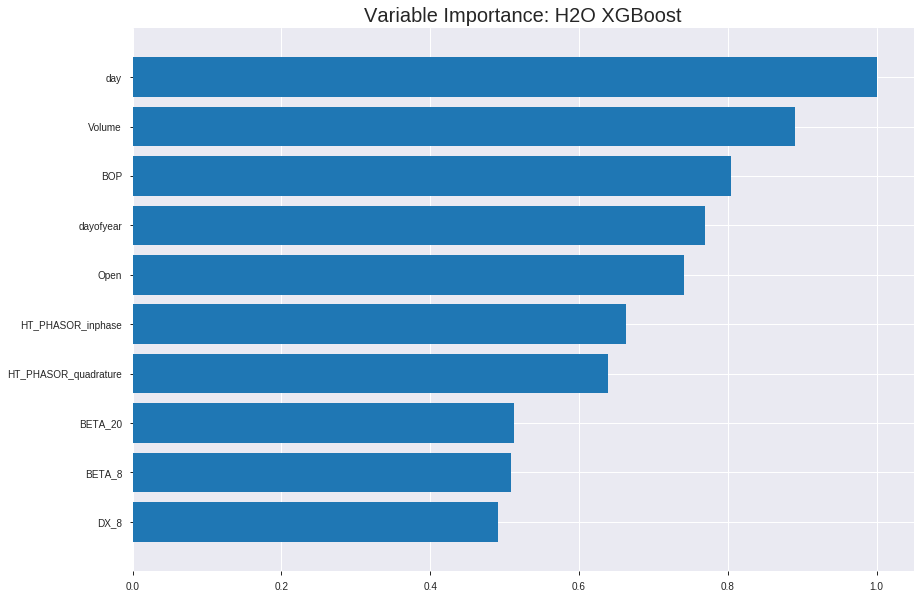

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190826_144852_model_5


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.03889713077548896
RMSE: 0.1972235553261551
LogLoss: 0.20982966316694288
Mean Per-Class Error: 0.0005376344086021057
AUC: 0.999998642337352
pr_auc: 0.9989235756007133
Gini: 0.9999972846747041
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4944419860839844: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      791  1    0.0013   (1.0/792.0)
1      0    930  0        (0.0/930.0)
Total  791  931  0.0006   (1.0/1722.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.494442     0.999463  201
max f2                       0.494442     0.999785  201
max f0point5                 0.607735     0.999785  199
max accuracy                 0.607735     0.999419  199
max precision                0.943981     1         0
max recall                   0.494442     1         201
max specificity              0.943981     1         0
max absolute_mcc             0.607735     0.998832  199
max min_per_class_accuracy   0.607735     0.998925  199
max mean_per_class_accuracy  0.607735     0.999462  199

Gains/Lift Table: Avg response rate: 54.01 %, avg score: 53.68 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010453                    0.9146             1.85161   1.85161            1                0.92626   1                           0.92626             0.0193548       0.0193548                  85.1613   85.1613
    2        0.0203252                   0.908268           1.85161   1.85161            1                0.911127  1                           0.91891             0.0182796       0.0376344                  85.1613   85.1613
    3        0.0301974                   0.904273           1.85161   1.85161            1                0.905991  1                           0.914687            0.0182796       0.055914                   85.1613   85.1613
    4        0.0400697                   0.896175           1.85161   1.85161            1                0.899965  1                           0.91106             0.0182796       0.0741935                  85.1613   85.1613
    5        0.0505226                   0.892779           1.85161   1.85161            1                0.894818  1                           0.907699            0.0193548       0.0935484                  85.1613   85.1613
    6        0.100465                    0.877769           1.85161   1.85161            1                0.884472  1                           0.896153            0.0924731       0.186022                   85.1613   85.1613
    7        0.150407                    0.866242           1.85161   1.85161            1                0.872195  1                           0.888198            0.0924731       0.278495                   85.1613   85.1613
    8        0.200348                    0.8521             1.85161   1.85161            1                0.858191  1                           0.880718            0.0924731       0.370968                   85.1613   85.1613
    9        0.300232                    0.825792           1.85161   1.85161            1                0.839494  1                           0.867003            0.184946        0.555914                   85.1613   85.1613
    10       0.400116                    0.793394           1.85161   1.85161            1                0.809603  1                           0.852674            0.184946        0.74086                    85.1613   85.1613
    11       0.5                         0.731248           1.85161   1.85161            1                0.766893  1                           0.835538            0.184946        0.925806                   85.1613   85.1613
    12       0.599884                    0.274879           0.742798  1.66699            0.401163         0.46256   0.90029                     0.773435            0.0741935       1                          -25.7202  66.6989
    13       0.699768                    0.218277           0         1.42905            0                0.244365  0.771784                    0.697916            0               1                          -100      42.9046
    14       0.799652                    0.181039           0         1.25054            0                0.198453  0.675381                    0.635529            0               1                          -100      25.0545
    15       0.899535                    0.146337           0         1.11168            0                0.164059  0.600387                    0.583177            0               1                          -100      11.1685
    16       1                           0.0723069          0         1                  0                0.121395  0.54007                     0.536784         



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2681330222848881
RMSE: 0.5178156257635416
LogLoss: 0.733476869444075
Mean Per-Class Error: 0.4798323994144076
AUC: 0.48925572551197266
pr_auc: 0.5608026745029634
Gini: -0.021488548976054678
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.17336630821228027: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    213  1        (213.0/213.0)
1      0    279  0        (0.0/279.0)
Total  0    492  0.4329   (213.0/492.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.173366     0.723735  399
max f2                       0.173366     0.867537  399
max f0point5                 0.173366     0.620828  399
max accuracy                 0.173366     0.567073  399
max precision                0.78231      1         0
max recall                   0.173366     1         399
max specificity              0.78231      1         0
max absolute_mcc             0.29924      0.108769  374
max min_per_class_accuracy   0.515775     0.507042  192
max mean_per_class_accuracy  0.628363     0.520168  58

Gains/Lift Table: Avg response rate: 56.71 %, avg score: 50.15 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101626                   0.726371           1.05806   1.05806            0.6              0.75269   0.6                         0.75269             0.0107527       0.0107527                  5.80645   5.80645
    2        0.0203252                   0.718132           0.705376  0.88172            0.4              0.723432  0.5                         0.738061            0.00716846      0.0179211                  -29.4624  -11.828
    3        0.0304878                   0.704008           0.705376  0.822939           0.4              0.712476  0.466667                    0.729533            0.00716846      0.0250896                  -29.4624  -17.7061
    4        0.0406504                   0.690469           0.705376  0.793548           0.4              0.696768  0.45                        0.721342            0.00716846      0.0322581                  -29.4624  -20.6452
    5        0.050813                    0.677925           1.76344   0.987527           1                0.683448  0.56                        0.713763            0.0179211       0.0501792                  76.3441   -1.24731
    6        0.101626                    0.650803           1.05806   1.0228             0.6              0.665966  0.58                        0.689865            0.0537634       0.103943                   5.80645   2.27957
    7        0.150407                    0.624905           1.17563   1.07236            0.666667         0.636341  0.608108                    0.672505            0.0573477       0.16129                    17.5627   7.23627
    8        0.20122                     0.610138           0.775914  0.997502           0.44             0.616566  0.565657                    0.658379            0.0394265       0.200717                   -22.4086  -0.24981
    9        0.300813                    0.569034           0.935703  0.977042           0.530612         0.590825  0.554054                    0.636013            0.09319         0.293907                   -6.42967  -2.29584
    10       0.400407                    0.540058           0.935703  0.966759           0.530612         0.554755  0.548223                    0.615802            0.09319         0.387097                   -6.42967  -3.32405
    11       0.5                         0.516383           1.18762   1.01075            0.673469         0.527639  0.573171                    0.598241            0.11828         0.505376                   18.7623   1.07527
    12       0.599593                    0.476661           0.971692  1.00426            0.55102          0.495645  0.569492                    0.5812              0.0967742       0.602151                   -2.83081  0.426463
    13       0.699187                    0.44234            0.863726  0.984246           0.489796         0.457849  0.55814                     0.563629            0.0860215       0.688172                   -13.6274  -1.57539
    14       0.79878                     0.396807           0.863726  0.969219           0.489796         0.420007  0.549618                    0.545722            0.0860215       0.774194                   -13.6274  -3.07806
    15       0.898374                    0.332573           1.07966   0.981463           0.612245         0.375323  0.556561                    0.526832            0.107527        0.88172                    7.96577   -1.85374
    16       1                           0.173366           1.16387   1                  0.66             0.277691  0.567073                    0.50151


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-26 14:49:17  12.186 sec  0                  0.5              0.693147            0.5             0                  1                0.45993                          0.5                0.693147              0.5               0                    1                  0.432927
    2019-08-26 14:49:19  13.398 sec  5                  0.447142         0.592202            0.974006        0.971064           1.85161          0.0813008                        0.503747           0.700714              0.478638          0.555525             1.41075            0.432927
    2019-08-26 14:49:19  14.061 sec  10                 0.40543          0.518365            0.993557        0.99149            1.85161          0.0319396                        0.503255           0.699757              0.491536          0.567536             1.41075            0.426829
    2019-08-26 14:49:20  14.781 sec  15                 0.360405         0.443532            0.99822         0.997365           1.85161          0.014518                         0.505005           0.703431              0.478781          0.566513             1.05806            0.430894
    2019-08-26 14:49:21  15.505 sec  20                 0.32467          0.3878              0.999624        0.998605           1.85161          0.00929152                       0.507166           0.708033              0.476046          0.561979             1.41075            0.430894
    2019-08-26 14:49:21  16.216 sec  25                 0.295318         0.343887            0.999876        0.998821           1.85161          0.0058072                        0.510664           0.715832              0.471848          0.54645              0.705376           0.430894
    2019-08-26 14:49:22  16.941 sec  30                 0.26873          0.30562             0.999935        0.997796           1.85161          0.00174216                       0.510259           0.715515              0.494868          0.559345             0.705376           0.432927
    2019-08-26 14:49:23  17.626 sec  35                 0.247593         0.276216            0.999969        0.998899           1.85161          0.00116144                       0.51057            0.716212              0.496332          0.563306             0.705376           0.432927
    2019-08-26 14:49:24  18.340 sec  40                 0.227932         0.249511            0.999989        0.998916           1.85161          0.00058072                       0.51202            0.719956              0.498915          0.572439             1.05806            0.432927
    2019-08-26 14:49:24  19.061 sec  45                 0.211231         0.227623            0.999999        0.998924           1.85161          0.00058072                       0.51506            0.726753              0.489281          0.56102              0.705376           0.432927
    2019-08-26 14:49:25  19.789 sec  50                 0.197224         0.20983             0.999999        0.998924           1.85161          0.00058072                       0.517816           0.733477              0.489256          0.560803             1.05806            0.432927

Variable Importances: 


variable                 relative_importance    scaled_importance      percentage
-----------------------  ---------------------  ---------------------  ----------------------
day                      460.8919677734375      1.0                    0.019296610089947173
Volume                   410.26629638671875     0.890157184488828      0.017177016107846086
BOP                      370.64453125           0.8041896087722649     0.015518133318865555
dayofyear                354.69598388671875     0.7695859522140296     0.014850400050574846
Open                     341.38922119140625     0.7407141913118006     0.014293272937834353
---                      ---                    ---                    ---
BBANDS_lowerband_12_7_4  1.0484161376953125     0.0022747546301581166  4.389505314846317e-05
BBANDS_lowerband_24_6_4  1.0114232301712036     0.002194490902189888   4.2346235285494664e-05
BBANDS_lowerband_24_5_4  0.5789209604263306     0.0012560881961625181  2.423824415993319e-05
BBANDS_upperband_14_0_3  0.50019770860672       0.0010852818959357611  2.0942261583551007e-05
quarter                  0.35124924778938293    0.0007621075487304824  1.4706092214457534e-05


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5951417004048583)

('F1', 0.6535211267605634)

('auc', 0.5707720588235294)

('logloss', 0.6923058620637604)

('mean_per_class_error', 0.40805540966386555)

('rmse', 0.4995366459510145)

('mse', 0.2495368606479892)

xgboost prediction progress: |████████████████████████████████████████████| 100%


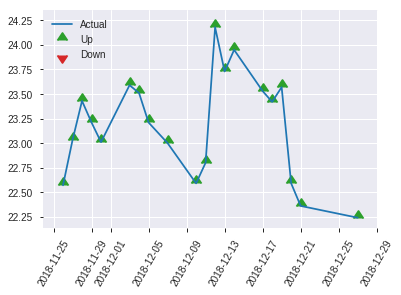


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2495368606479892
RMSE: 0.4995366459510145
LogLoss: 0.6923058620637604
Mean Per-Class Error: 0.40805540966386555
AUC: 0.5707720588235294
pr_auc: 0.5614271686141408
Gini: 0.14154411764705888
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3229828178882599: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      8    120  0.9375   (120.0/128.0)
1      3    116  0.0252   (3.0/119.0)
Total  11   236  0.498    (123.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.322983     0.653521  235
max f2                       0.257221     0.8241    245
max f0point5                 0.549531     0.573614  100
max accuracy                 0.549531     0.595142  100
max precision                0.753325     1         0
max recall                   0.257221     1         245
max specificity              0.753325     1         0
max absolute_mcc             0.549531     0.186895  100
max min_per_class_accuracy   0.52145      0.554622  119
max mean_per_class_accuracy  0.549531     0.591945  100

Gains/Lift Table: Avg response rate: 48.18 %, avg score: 51.65 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0121457                   0.739458           0.691877  0.691877           0.333333         0.745821  0.333333                    0.745821            0.00840336      0.00840336                 -30.8123  -30.8123
    2        0.0202429                   0.715769           2.07563   1.24538            1                0.738906  0.6                         0.743055            0.0168067       0.0252101                  107.563   24.5378
    3        0.0323887                   0.702659           2.07563   1.55672            1                0.709858  0.75                        0.730606            0.0252101       0.0504202                  107.563   55.6723
    4        0.0404858                   0.694408           1.03782   1.45294            0.5              0.695688  0.7                         0.723622            0.00840336      0.0588235                  3.78151   45.2941
    5        0.0526316                   0.684595           2.07563   1.59664            1                0.691207  0.769231                    0.716142            0.0252101       0.0840336                  107.563   59.6639
    6        0.101215                    0.654812           1.21078   1.41143            0.583333         0.66849   0.68                        0.693269            0.0588235       0.142857                   21.0784   41.1429
    7        0.149798                    0.630065           1.38375   1.40245            0.666667         0.64306   0.675676                    0.676985            0.0672269       0.210084                   38.3754   40.2453
    8        0.202429                    0.60481            0.957983  1.28689            0.461538         0.617208  0.62                        0.661443            0.0504202       0.260504                   -4.20168  28.6891
    9        0.299595                    0.579381           1.21078   1.26221            0.583333         0.592777  0.608108                    0.639173            0.117647        0.378151                   21.0784   26.2208
    10       0.40081                     0.553536           1.07933   1.21603            0.52             0.567606  0.585859                    0.6211              0.109244        0.487395                   7.93277   21.6026
    11       0.502024                    0.519288           0.664202  1.10477            0.32             0.534215  0.532258                    0.603583            0.0672269       0.554622                   -33.5798  10.4771
    12       0.59919                     0.499349           0.778361  1.05184            0.375            0.509501  0.506757                    0.588327            0.0756303       0.630252                   -22.1639  5.18397
    13       0.700405                    0.462718           0.830252  1.01982            0.4              0.476114  0.491329                    0.572111            0.0840336       0.714286                   -16.9748  1.98183
    14       0.797571                    0.423713           0.951331  1.01147            0.458333         0.443044  0.48731                     0.556387            0.092437        0.806723                   -4.86695  1.14746
    15       0.898785                    0.374621           0.830252  0.991067           0.4              0.400064  0.477477                    0.538783            0.0840336       0.890756                   -16.9748  -0.89333
    16       1                           0.189881           1.07933   1                  0.52             0.318743  0.481781                    0.516512       

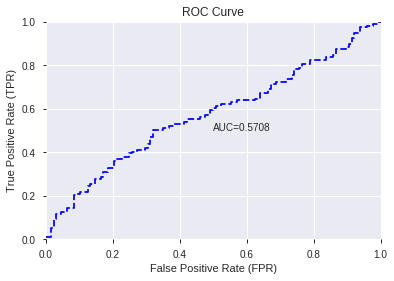

This function is available for GLM models only


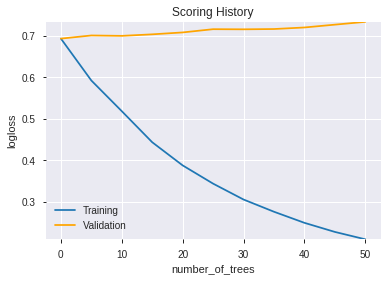

--2019-08-26 14:49:35--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.21.187
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.21.187|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190826_144852_model_5',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190826_144852_model_5',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_90_sid_97b9',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['day',
 'Volume',
 'BOP',
 'dayofyear',
 'Open',
 'HT_PHASOR_inphase',
 'HT_PHASOR_quadrature',
 'BETA_20',
 'BETA_8',
 'DX_8',
 'CORREL_8',
 'High',
 'MFI_8',
 'PLUS_DM_8',
 'MFI_14',
 'ULTOSC',
 'PLUS_DI_8',
 'WILLR_8',
 'dayofweek',
 'STOCH_slowk',
 'ADX_8',
 'CCI_8',
 'MFI_20',
 'MFI_24',
 'OBV',
 'MFI_30',
 'BETA_12',
 'DIV',
 'CORREL_20',
 'STDDEV_8',
 'ADXR_8',
 'ADOSC',
 'ROC_24',
 'TRIX_8',
 'CMO_8',
 'TAN',
 'STOCH_slowd',
 'MFI_12',
 'SAREXT',
 'CORREL_24',
 'MINUS_DM_8',
 'HT_DCPERIOD',
 'MACDFIX_hist_8',
 'WILLR_12',
 'CORREL_12',
 'ROC_14',
 'STOCHRSI_fastd',
 'AD',
 'CCI_12',
 'MACDEXT_hist',
 'AdjClose',
 'Close',
 'DX_12',
 'STOCHF_fastk',
 'ROC_30',
 'TRANGE',
 'aroondown_8',
 'BETA_14',
 'MINUS_DI_8',
 'WILLR_30',
 'CORREL_30',
 'BETA_30',
 'DX_30',
 'CCI_20',
 'AROONOSC_24',
 'ADXR_12',
 'weekday_name',
 'MOM_30',
 'PLUS_DI_12',
 'MACDFIX_8',
 'ADXR_14',
 'SAR_0.08',
 'DX_24',
 'NATR_8',
 'STDDEV_12',
 'aroonup_8',
 'ATR_8',
 'Low',
 'MOM_14',
 'COS',
 'CORREL_14',

In [49]:
# XGBoost with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="XGBoost",features_list=features_list)

In [50]:
# recursive feature elimination with cross validation
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'RFE' in features_to_include:
  from sklearn.feature_selection import RFECV
  from sklearn.svm import LinearSVC
  from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
  from sklearn.linear_model import LogisticRegression, LinearRegression

  bestfeatures = RFECV(ExtraTreeClassifier(random_state=1,criterion='entropy'), min_features_to_select=select_rfe, step=1,cv=5).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, RFECV, LinearSVC, DecisionTreeClassifier,ExtraTreeClassifier, LogisticRegression, LinearRegression
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list = []

488

['BBANDS_middleband_12_3_5',
 'BBANDS_lowerband_12_3_5',
 'MA_12_4',
 'MAVP_12_4',
 'BBANDS_upperband_12_4_2',
 'BBANDS_middleband_12_4_2',
 'BBANDS_lowerband_12_4_2',
 'BBANDS_upperband_12_4_3',
 'BBANDS_middleband_12_4_3',
 'BBANDS_lowerband_12_4_3',
 'BBANDS_upperband_12_4_4',
 'BBANDS_middleband_12_4_4',
 'BBANDS_lowerband_12_4_4',
 'BBANDS_upperband_12_4_5',
 'BBANDS_middleband_12_4_5',
 'BBANDS_lowerband_12_4_5',
 'MA_12_5',
 'MAVP_12_5',
 'BBANDS_upperband_12_5_2',
 'BBANDS_middleband_12_5_2',
 'BBANDS_lowerband_12_5_2',
 'BBANDS_upperband_12_5_3',
 'BBANDS_middleband_12_5_3',
 'BBANDS_lowerband_12_5_3',
 'BBANDS_upperband_12_5_4',
 'BBANDS_middleband_12_5_4',
 'BBANDS_lowerband_12_5_4',
 'BBANDS_upperband_12_5_5',
 'BBANDS_middleband_12_5_5',
 'BBANDS_lowerband_12_5_5',
 'MA_12_6',
 'MAVP_12_6',
 'BBANDS_upperband_12_6_2',
 'BBANDS_middleband_12_6_2',
 'BBANDS_lowerband_12_6_2',
 'BBANDS_upperband_12_6_3',
 'BBANDS_middleband_12_6_3',
 'BBANDS_lowerband_12_6_3',
 'BBANDS_upperb

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190826_145047_model_4  0.530331  1.640351              0.496094  0.643893  0.414598
1  DeepLearning_grid_1_AutoML_20190826_145047_model_7  0.512933  0.949822              0.500000  0.555235  0.308285
2  DeepLearning_grid_1_AutoML_20190826_145047_model_9  0.500000  0.704862              0.500000  0.505787  0.255820
3  DeepLearning_grid_1_AutoML_20190826_145047_model_6  0.500000  0.705338              0.500000  0.506018  0.256055
4  DeepLearning_grid_1_AutoML_20190826_145047_model_5  0.500000  0.709002              0.500000  0.507793  0.257854
5  DeepLearning_grid_1_AutoML_20190826_145047_model_8  0.500000  0.702999              0.500000  0.504877  0.254901
6  DeepLearning_grid_1_AutoML_20190826_145047_model_3  0.482405  2.125554              0.496094  0.647427  0.419161
7               DeepLearning_1_AutoML_20190826_145047  0.475840  2.916352              0.500000  0.690239  0.476430
8  DeepLearning_grid_1_AutoML_20190826_145047_model_2  0.475381  1.389010              0.500000  0.645618  0.416823
9  DeepLearning_grid_1_AutoML_20190826_145047_model_1  0.451484  5.148344              0.500000  0.672537  0.452306

variable  relative_importance  scaled_importance  percentage
0            CDLCOUNTERATTACK             1.000000           1.000000    0.004410
1          CDLEVENINGDOJISTAR             0.984623           0.984623    0.004342
2           CDL3WHITESOLDIERS             0.975216           0.975216    0.004300
3            CDLSTICKSANDWICH             0.952274           0.952274    0.004199
4           CDLSTALLEDPATTERN             0.944316           0.944316    0.004164
..                        ...                  ...                ...         ...
483                    SMA_14             0.411881           0.411881    0.001816
484  BBANDS_middleband_14_5_2             0.411131           0.411131    0.001813
485   BBANDS_upperband_12_5_4             0.410363           0.410363    0.001810
486   BBANDS_upperband_24_7_5             0.409842           0.409842    0.001807
487                   MA_24_3             0.408187           0.408187    0.001800

[488 rows x 4 columns]

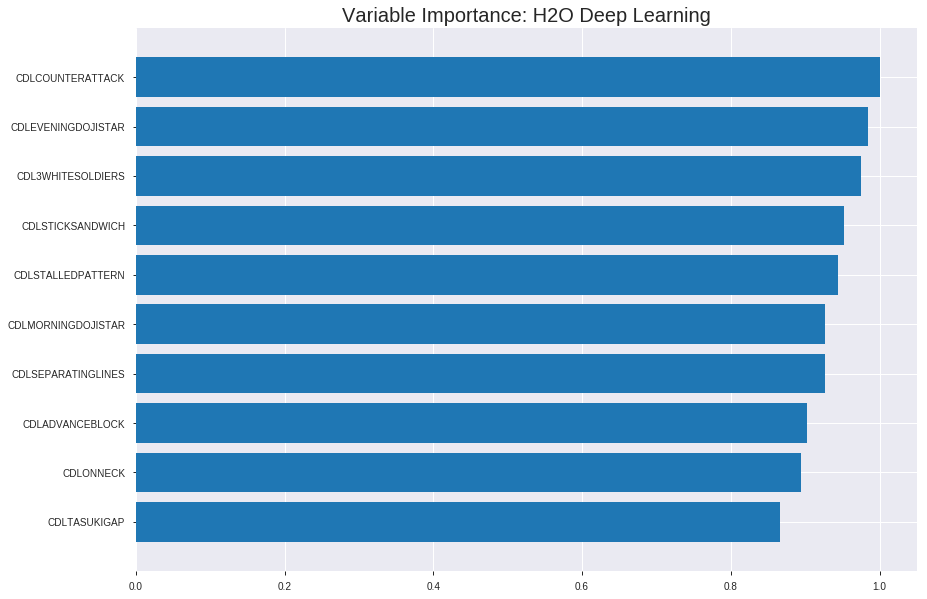

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190826_145047_model_4


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.19274030989982086
RMSE: 0.43902199250131063
LogLoss: 0.5658400533957573
Mean Per-Class Error: 0.26467904855001634
AUC: 0.8105307103290975
pr_auc: 0.819881502514064
Gini: 0.621061420658195
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.26777888842228437: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      485  307   0.3876   (307.0/792.0)
1      139  791   0.1495   (139.0/930.0)
Total  624  1098  0.259    (446.0/1722.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.267779     0.780079  280
max f2                       0.0679906    0.880939  363
max f0point5                 0.445648     0.758481  214
max accuracy                 0.279054     0.740999  275
max precision                0.997646     1         0
max recall                   0.0192942    1         386
max specificity              0.997646     1         0
max absolute_mcc             0.267779     0.479964  280
max min_per_class_accuracy   0.39243      0.732258  232
max mean_per_class_accuracy  0.325787     0.735321  256

Gains/Lift Table: Avg response rate: 54.01 %, avg score: 43.39 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010453                    0.982315           1.85161    1.85161            1                0.990243   1                           0.990243            0.0193548       0.0193548                  85.1613   85.1613
    2        0.0203252                   0.963763           1.85161    1.85161            1                0.97411    1                           0.982407            0.0182796       0.0376344                  85.1613   85.1613
    3        0.0301974                   0.952711           1.85161    1.85161            1                0.957805   1                           0.974364            0.0182796       0.055914                   85.1613   85.1613
    4        0.0400697                   0.939289           1.85161    1.85161            1                0.94671    1                           0.967551            0.0182796       0.0741935                  85.1613   85.1613
    5        0.0505226                   0.929277           1.74875    1.83033            0.944444         0.934361   0.988506                    0.960684            0.0182796       0.0924731                  74.8746   83.033
    6        0.100465                    0.87955            1.67937    1.75529            0.906977         0.902513   0.947977                    0.931766            0.083871        0.176344                   67.937    75.5286
    7        0.150407                    0.813939           1.37794    1.62999            0.744186         0.846116   0.880309                    0.903327            0.0688172       0.245161                   37.7944   62.9991
    8        0.200348                    0.757356           1.44254    1.58326            0.77907          0.783413   0.855072                    0.873435            0.072043        0.317204                   44.2536   58.3263
    9        0.300232                    0.642949           1.50713    1.55793            0.813953         0.703578   0.841393                    0.816926            0.150538        0.467742                   50.7127   55.7933
    10       0.400116                    0.52779            1.21647    1.47269            0.656977         0.58519    0.795356                    0.759076            0.121505        0.589247                   21.6467   47.2691
    11       0.5                         0.412219           1.21647    1.42151            0.656977         0.470107   0.767712                    0.701349            0.121505        0.710753                   21.6467   42.1505
    12       0.599884                    0.305596           1.01193    1.35331            0.546512         0.358656   0.730881                    0.644289            0.101075        0.811828                   1.1928    35.3309
    13       0.699768                    0.187301           0.785859   1.27231            0.424419         0.247344   0.687137                    0.58763             0.0784946       0.890323                   -21.4141  27.2312
    14       0.799652                    0.0991523          0.667442   1.19676            0.360465         0.140329   0.646333                    0.531758            0.0666667       0.956989                   -33.2558  19.6758
    15       0.899535                    0.0369334          0.366017   1.10451            0.197674         0.0700863  0.596514                    0.480494            0.0365591       0.993548                   -63.3983  10.4513
    16       1                           0.000198937        0.0642178  1                  0.0346821        0.0169717  0.54007   



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.3928305819115692
RMSE: 0.6267619818651808
LogLoss: 1.1268188741759984
Mean Per-Class Error: 0.49268009490635567
AUC: 0.47367358271492754
pr_auc: 0.5406728195209805
Gini: -0.05265283457014491
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.020547710778426216: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    213  1        (213.0/213.0)
1      0    279  0        (0.0/279.0)
Total  0    492  0.4329   (213.0/492.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.0205477    0.723735   399
max f2                       0.0205477    0.867537   399
max f0point5                 0.0205477    0.620828   399
max accuracy                 0.0392025    0.567073   385
max precision                0.0862196    0.571429   337
max recall                   0.0205477    1          399
max specificity              0.879821     0.995305   0
max absolute_mcc             0.839455     0.0896434  2
max min_per_class_accuracy   0.182341     0.476703   216
max mean_per_class_accuracy  0.0862196    0.50732    337

Gains/Lift Table: Avg response rate: 56.71 %, avg score: 23.88 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101626                   0.765071           0.352688  0.352688           0.2              0.832714   0.2                         0.832714            0.00358423      0.00358423                 -64.7312  -64.7312
    2        0.0203252                   0.695687           1.05806   0.705376           0.6              0.736265   0.4                         0.78449             0.0107527       0.0143369                  5.80645   -29.4624
    3        0.0304878                   0.655772           1.05806   0.822939           0.6              0.674473   0.466667                    0.747818            0.0107527       0.0250896                  5.80645   -17.7061
    4        0.0406504                   0.642404           0.705376  0.793548           0.4              0.647532   0.45                        0.722746            0.00716846      0.0322581                  -29.4624  -20.6452
    5        0.050813                    0.595984           0.705376  0.775914           0.4              0.624088   0.44                        0.703015            0.00716846      0.0394265                  -29.4624  -22.4086
    6        0.101626                    0.493834           1.05806   0.916989           0.6              0.544436   0.52                        0.623725            0.0537634       0.09319                    5.80645   -8.30108
    7        0.150407                    0.435199           0.955197  0.929381           0.541667         0.464707   0.527027                    0.572152            0.046595        0.139785                   -4.48029  -7.0619
    8        0.20122                     0.386363           0.987527  0.944064           0.56             0.409407   0.535354                    0.531055            0.0501792       0.189964                   -1.24731  -5.59357
    9        0.300813                    0.284283           1.07966   0.988957           0.612245         0.332491   0.560811                    0.465314            0.107527        0.297491                   7.96577   -1.10433
    10       0.400407                    0.221526           0.863726  0.957808           0.489796         0.250066   0.543147                    0.411775            0.0860215       0.383513                   -13.6274  -4.2192
    11       0.5                         0.180688           0.935703  0.953405           0.530612         0.200922   0.54065                     0.369776            0.09319         0.476703                   -6.42967  -4.6595
    12       0.599593                    0.149598           0.899715  0.944487           0.510204         0.164965   0.535593                    0.335756            0.0896057       0.566308                   -10.0285  -5.5513
    13       0.699187                    0.128048           1.18762   0.97912            0.673469         0.137793   0.555233                    0.307558            0.11828         0.684588                   18.7623   -2.08802
    14       0.79878                     0.0970577          1.07966   0.991655           0.612245         0.111572   0.562341                    0.283122            0.107527        0.792115                   7.96577   -0.834496
    15       0.898374                    0.0664579          0.971692  0.989442           0.55102          0.0797452  0.561086                    0.260576            0.0967742       0.888889                   -2.83081  -1.05581
    16       1                           0.0205477          1.09333   1                  0.62             0.0467174  0.567073       


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-26 14:53:03  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-26 14:53:09  7.313 sec         232 obs/sec       0.793264  1             1366       0.609659         1.57811             -0.496345      0.554495        0.554054           1.23441          0.45993                          0.64619            1.99928               -0.700852        0.48446           0.56111              1.05806            0.432927
    2019-08-26 14:53:26  24.072 sec        260 obs/sec       3.19396   4             5500       0.581891         1.33822             -0.363143      0.593943        0.573487           1.54301          0.43554                          0.657596           5.45784               -0.761426        0.46579           0.483989             1.05806            0.432927
    2019-08-26 14:53:45  42.628 sec        286 obs/sec       6.36411   8             10959      0.533301         0.954073            -0.144992      0.633702        0.618728           1.44014          0.416957                         0.652621           3.07863               -0.734874        0.45359           0.499553             1.41075            0.428862
    2019-08-26 14:54:01  59.219 sec        307 obs/sec       9.53775   12            16424      0.530732         0.930185            -0.133988      0.655058        0.655242           1.54301          0.441928                         0.747297           3.20043               -1.27474         0.475684          0.543033             1.05806            0.424797
    2019-08-26 14:54:17  1 min 15.036 sec  322 obs/sec       12.7189   16            21902      0.512218         0.891089            -0.0562544     0.709081        0.679532           1.44014          0.337979                         0.596034           1.2129                -0.447065        0.476947          0.546424             1.05806            0.432927
    2019-08-26 14:54:32  1 min 30.139 sec  335 obs/sec       15.9036   20            27386      0.568185         1.05528             -0.299683      0.749462        0.780253           1.74875          0.333914                         0.752683           5.11894               -1.30765         0.4913            0.573178             1.41075            0.420732
    2019-08-26 14:54:47  1 min 44.938 sec  346 obs/sec       19.1063   24            32901      0.487714         0.825771            0.0423906      0.746222        0.78312            1.85161          0.315912                         0.75105            4.55952               -1.29765         0.50223           0.573789             1.41075            0.426829
    2019-08-26 14:55:04  2 min  2.177 sec  358 obs/sec       23.043    29            39680      0.439022         0.56584             0.224055       0.810531        0.819882           1.85161          0.259001                         0.626762           1.12682               -0.600117        0.473674          0.540673             0.352688           0.432927

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
CDLCOUNTERATTACK          1.0                    1.0                  0.004409632156722385
CDLEVENINGDOJISTAR        0.9846229553222656     0.9846229553222656   0.00434182504603609
CDL3WHITESOLDIERS         0.9752160310745239     0.9752160310745239   0.004300343970377397
CDLSTICKSANDWICH          0.9522736072540283     0.9522736072540283   0.004199176320545386
CDLSTALLEDPATTERN         0.9443164467811584     0.9443164467811584   0.004164088169848019
---                       ---                    ---                  ---
SMA_14                    0.41188114881515503    0.41188114881515503  0.0018162443585630656
BBANDS_middleband_14_5_2  0.41113072633743286    0.41113072633743286  0.0018129352714741746
BBANDS_upperband_12_5_4   0.41036343574523926    0.41036343574523926  0.0018095518022052872
BBANDS_upperband_24_7_5   0.40984153747558594    0.40984153747558594  0.001807250422812886
MA_24_3                   0.4081869423389435     0.4081869423389435   0.001799954266891991


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5708502024291497)

('F1', 0.6520547945205479)

('auc', 0.5303308823529411)

('logloss', 1.640350845531145)

('mean_per_class_error', 0.44291622899159666)

('rmse', 0.6438931995063384)

('mse', 0.41459845237050924)

deeplearning prediction progress: |███████████████████████████████████████| 100%


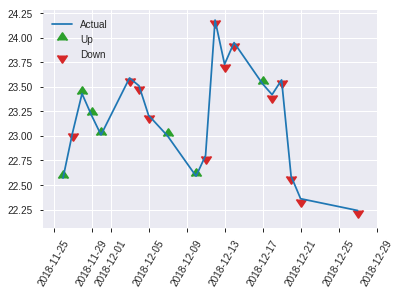


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.41459845237050924
RMSE: 0.6438931995063384
LogLoss: 1.640350845531145
Mean Per-Class Error: 0.44291622899159666
AUC: 0.5303308823529411
pr_auc: 0.5459404931656312
Gini: 0.06066176470588225
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.00016495828563529858: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    127  0.9922   (127.0/128.0)
1      0    119  0        (0.0/119.0)
Total  1    246  0.5142   (127.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.000164958  0.652055  245
max f2                       0.000164958  0.8241    245
max f0point5                 0.000164958  0.539438  245
max accuracy                 0.157101     0.57085   28
max precision                0.438427     1         0
max recall                   0.000164958  1         245
max specificity              0.438427     1         0
max absolute_mcc             0.248106     0.195863  14
max min_per_class_accuracy   0.0382882    0.529412  122
max mean_per_class_accuracy  0.0429828    0.557084  111

Gains/Lift Table: Avg response rate: 48.18 %, avg score:  7.17 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0121457                   0.377185           2.07563   2.07563            1                0.418561    1                           0.418561            0.0252101       0.0252101                  107.563   107.563
    2        0.0202429                   0.335415           1.03782   1.6605             0.5              0.357184    0.8                         0.39401             0.00840336      0.0336134                  3.78151   66.0504
    3        0.0323887                   0.282966           1.38375   1.55672            0.666667         0.308187    0.75                        0.361827            0.0168067       0.0504202                  38.3754   55.6723
    4        0.0404858                   0.271895           2.07563   1.6605             1                0.278648    0.8                         0.345191            0.0168067       0.0672269                  107.563   66.0504
    5        0.0526316                   0.253945           2.07563   1.7563             1                0.260721    0.846154                    0.325698            0.0252101       0.092437                   107.563   75.6303
    6        0.101215                    0.206423           1.21078   1.49445            0.583333         0.22962     0.72                        0.279581            0.0588235       0.151261                   21.0784   49.4454
    7        0.149798                    0.141859           0.691877  1.23416            0.333333         0.160495    0.594595                    0.240958            0.0336134       0.184874                   -30.8123  23.4159
    8        0.202429                    0.113455           0.798319  1.12084            0.384615         0.125331    0.54                        0.210895            0.0420168       0.226891                   -20.1681  12.084
    9        0.299595                    0.0814405          0.778361  1.00977            0.375            0.0952935   0.486486                    0.173403            0.0756303       0.302521                   -22.1639  0.976607
    10       0.40081                     0.0509152          1.16235   1.0483             0.56             0.067654    0.505051                    0.146699            0.117647        0.420168                   16.2353   4.82981
    11       0.502024                    0.0382301          1.07933   1.05455            0.52             0.0438438   0.508065                    0.125962            0.109244        0.529412                   7.93277   5.45541
    12       0.59919                     0.028194           0.778361  1.00977            0.375            0.032677    0.486486                    0.110834            0.0756303       0.605042                   -22.1639  0.976607
    13       0.700405                    0.0207036          0.913277  0.995823           0.44             0.0242406   0.479769                    0.0983209           0.092437        0.697479                   -8.67227  -0.417739
    14       0.797571                    0.0122022          1.03782   1.00094            0.5              0.0172334   0.482234                    0.0884422           0.10084         0.798319                   3.78151   0.0938446
    15       0.898785                    0.00614209         0.913277  0.991067           0.44             0.00893122  0.477477                    0.0794883           0.092437        0.890756                   -8.67227  -0.89333
    16       1                           0.000147059        1.07933   1                  0.52             0.00213572  0.4

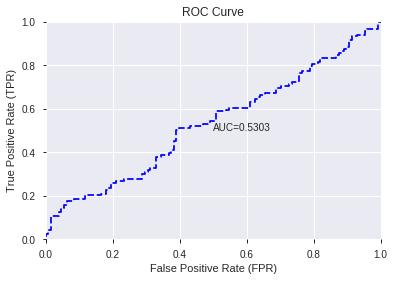

This function is available for GLM models only


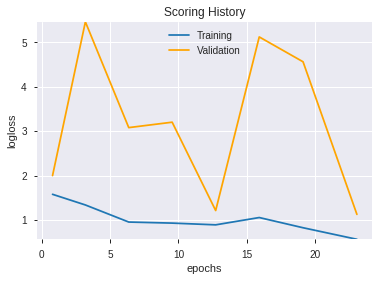

--2019-08-26 15:06:14--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.110.187
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.110.187|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190826_145047_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190826_145047_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_98_sid_97b9',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['CDLCOUNTERATTACK',
 'CDLEVENINGDOJISTAR',
 'CDL3WHITESOLDIERS',
 'CDLSTICKSANDWICH',
 'CDLSTALLEDPATTERN',
 'CDLMORNINGDOJISTAR',
 'CDLSEPARATINGLINES',
 'CDLADVANCEBLOCK',
 'CDLONNECK',
 'CDLTASUKIGAP',
 'CDLHOMINGPIGEON',
 'CDLINVERTEDHAMMER',
 'CDL3INSIDE',
 'CDLHAMMER',
 'CDLTAKURI',
 'CDLMATCHINGLOW',
 'BOP',
 'CDLHANGINGMAN',
 'CDLHIKKAKE',
 'HT_PHASOR_inphase',
 'aroondown_8',
 'CDLHARAMICROSS',
 'HT_PHASOR_quadrature',
 'aroonup_8',
 'HT_DCPERIOD',
 'CORREL_8',
 'BETA_12',
 'TRANGE',
 'BETA_8',
 'CORREL_12',
 'CDLSPINNINGTOP',
 'CDL3OUTSIDE',
 'BETA_20',
 'aroondown_24',
 'CORREL_14',
 'aroondown_12',
 'CDLRICKSHAWMAN',
 'STOCHRSI_fastd',
 'CDLLONGLINE',
 'STOCHRSI_fastk',
 'HT_TRENDMODE',
 'BETA_14',
 'CDLBELTHOLD',
 'STOCH_slowd',
 'STOCHF_fastd',
 'AROONOSC_20',
 'AD',
 'MFI_24',
 'PLUS_DM_12',
 'CDLENGULFING',
 'ADOSC',
 'AROONOSC_24',
 'MFI_8',
 'WILLR_12',
 'DX_14',
 'aroonup_24',
 'MINUS_DI_20',
 'CDLHARAMI',
 'aroonup_12',
 'MACDEXT_hist',
 'MFI_30',
 'MFI_12',
 'ADX_

In [51]:
# DeepLearning with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190826_150631_model_1  0.462644  0.744045              0.492483  0.523809  0.274376

variable  relative_importance  scaled_importance  percentage
0                     BETA_12         8.396520e-03           1.000000    0.018844
1                 CDLHIGHWAVE         7.492983e-03           0.892391    0.016816
2              CDLMATCHINGLOW         6.957970e-03           0.828673    0.015615
3                      BETA_8         6.880431e-03           0.819438    0.015441
4                aroondown_24         5.969590e-03           0.710960    0.013397
..                        ...                  ...                ...         ...
483               MINUS_DI_12         1.652061e-06           0.000197    0.000004
484   BBANDS_upperband_12_4_2         1.215556e-06           0.000145    0.000003
485  BBANDS_middleband_30_6_2         6.455726e-07           0.000077    0.000001
486  BBANDS_middleband_30_6_5         6.196283e-07           0.000074    0.000001
487   BBANDS_upperband_14_3_2         4.621889e-07           0.000055    0.000001

[488 rows x 4 columns]

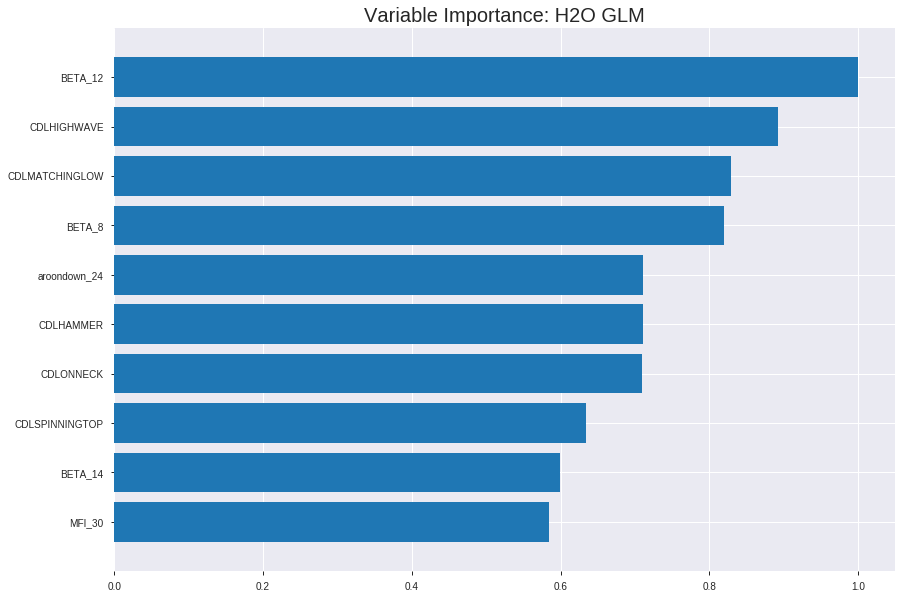

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190826_150631_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24646203663523425
RMSE: 0.4964494300885381
LogLoss: 0.6860406443755483
Null degrees of freedom: 1721
Residual degrees of freedom: 1233
Null deviance: 2376.1277882295276
Residual deviance: 2362.7239792293885
AIC: 3340.7239792293885
AUC: 0.5839809384164223
pr_auc: 0.6041021813782529
Gini: 0.16796187683284458
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5083428103554506: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      18   774   0.9773   (774.0/792.0)
1      6    924   0.0065   (6.0/930.0)
Total  24   1698  0.453    (780.0/1722.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.508343     0.703196  382
max f2                       0.49752      0.855094  396
max f0point5                 0.531257     0.61128   276
max accuracy                 0.536746     0.577816  235
max precision                0.592412     1         0
max recall                   0.49752      1         396
max specificity              0.592412     1         0
max absolute_mcc             0.537671     0.146829  228
max min_per_class_accuracy   0.538703     0.566667  219
max mean_per_class_accuracy  0.537951     0.573452  226

Gains/Lift Table: Avg response rate: 54.01 %, avg score: 54.01 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010453                    0.581022           1.33728   1.33728            0.722222         0.584734  0.722222                    0.584734            0.0139785       0.0139785                  33.7276   33.7276
    2        0.0203252                   0.577065           1.30702   1.32258            0.705882         0.578796  0.714286                    0.58185             0.0129032       0.0268817                  30.7021   32.2581
    3        0.0301974                   0.572733           0.871347  1.17506            0.470588         0.57479   0.634615                    0.579542            0.00860215      0.0354839                  -12.8653  17.5062
    4        0.0400697                   0.571085           1.1981    1.18074            0.647059         0.571941  0.637681                    0.577669            0.011828        0.0473118                  19.8102   18.0739
    5        0.0505226                   0.567671           1.33728   1.21313            0.722222         0.569425  0.655172                    0.575963            0.0139785       0.0612903                  33.7276   21.3126
    6        0.100465                    0.560005           1.09805   1.15592            0.593023         0.563332  0.624277                    0.569684            0.0548387       0.116129                   9.80495   15.592
    7        0.150407                    0.555009           1.29182   1.20105            0.697674         0.557211  0.648649                    0.565542            0.0645161       0.180645                   29.1823   20.1046
    8        0.200348                    0.55148            0.990398  1.14854            0.534884         0.553252  0.62029                     0.562479            0.0494624       0.230108                   -0.96024  14.8537
    9        0.300232                    0.546258           1.09805   1.13174            0.593023         0.548823  0.611219                    0.557936            0.109677        0.339785                   9.80495   13.174
    10       0.400116                    0.542356           1.07652   1.11795            0.581395         0.544269  0.603774                    0.554524            0.107527        0.447312                   7.65191   11.7955
    11       0.5                         0.538872           1.14111   1.12258            0.616279         0.540508  0.606272                    0.551724            0.113978        0.56129                    14.111    12.2581
    12       0.599884                    0.535759           1.01193   1.10416            0.546512         0.53732   0.596321                    0.549326            0.101075        0.662366                   1.1928    10.4156
    13       0.699768                    0.532224           0.893511  1.07409            0.482558         0.53407   0.580083                    0.547148            0.0892473       0.751613                   -10.6489  7.40891
    14       0.799652                    0.528161           0.87198   1.04884            0.47093          0.530222  0.566449                    0.545034            0.0870968       0.83871                    -12.802   4.88439
    15       0.899535                    0.522306           0.87198   1.02921            0.47093          0.525504  0.555842                    0.542865            0.0870968       0.925806                   -12.802   2.92051
    16       1                           0.481799           0.738505  1                  0.398844         0.51504   0.54007                     0.54007            



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.2465641501328739
RMSE: 0.49655226324413615
LogLoss: 0.6863064212890849
Null degrees of freedom: 491
Residual degrees of freedom: 3
Null deviance: 674.6256660447343
Residual deviance: 675.3255185484595
AIC: 1653.3255185484595
AUC: 0.47820014471536504
pr_auc: 0.5516093118443509
Gini: -0.04359971056926992
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5251971313260487: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    212  0.9953   (212.0/213.0)
1      0    279  0        (0.0/279.0)
Total  1    491  0.4309   (212.0/492.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.525197     0.724675   398
max f2                       0.525197     0.868077   398
max f0point5                 0.525197     0.621935   398
max accuracy                 0.525197     0.569106   398
max precision                0.617898     0.666667   2
max recall                   0.525197     1          398
max specificity              0.622408     0.995305   0
max absolute_mcc             0.584103     0.0672536  157
max min_per_class_accuracy   0.579805     0.483871   194
max mean_per_class_accuracy  0.565005     0.510273   291

Gains/Lift Table: Avg response rate: 56.71 %, avg score: 57.79 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101626                   0.616531           0.705376  0.705376           0.4              0.619137  0.4                         0.619137            0.00716846      0.00716846                 -29.4624  -29.4624
    2        0.0203252                   0.608413           1.41075   1.05806            0.8              0.612594  0.6                         0.615866            0.0143369       0.0215054                  41.0753   5.80645
    3        0.0304878                   0.607841           1.05806   1.05806            0.6              0.608121  0.6                         0.613284            0.0107527       0.0322581                  5.80645   5.80645
    4        0.0406504                   0.60639            0.705376  0.969892           0.4              0.607051  0.55                        0.611726            0.00716846      0.0394265                  -29.4624  -3.01075
    5        0.050813                    0.604348           1.41075   1.05806            0.8              0.605592  0.6                         0.610499            0.0143369       0.0537634                  41.0753   5.80645
    6        0.101626                    0.600349           0.775914  0.916989           0.44             0.602342  0.52                        0.606421            0.0394265       0.09319                    -22.4086  -8.30108
    7        0.150407                    0.596408           0.955197  0.929381           0.541667         0.598604  0.527027                    0.603886            0.046595        0.139785                   -4.48029  -7.0619
    8        0.20122                     0.593242           1.05806   0.961877           0.6              0.594754  0.545455                    0.601579            0.0537634       0.193548                   5.80645   -3.81232
    9        0.300813                    0.587332           0.971692  0.965126           0.55102          0.589767  0.547297                    0.597669            0.0967742       0.290323                   -2.83081  -3.48736
    10       0.400407                    0.583975           0.863726  0.939905           0.489796         0.585263  0.532995                    0.594583            0.0860215       0.376344                   -13.6274  -6.0095
    11       0.5                         0.579253           1.07966   0.967742           0.612245         0.581948  0.54878                     0.592066            0.107527        0.483871                   7.96577   -3.22581
    12       0.599593                    0.574042           1.04367   0.980354           0.591837         0.576965  0.555932                    0.589558            0.103943        0.587814                   4.36691   -1.96464
    13       0.699187                    0.569225           0.971692  0.97912            0.55102          0.571526  0.555233                    0.586989            0.0967742       0.684588                   -2.83081  -2.08802
    14       0.79878                     0.562938           1.15163   1.00063            0.653061         0.565967  0.56743                     0.584368            0.114695        0.799283                   15.1635   0.0629292
    15       0.898374                    0.555034           0.899715  0.989442           0.510204         0.559457  0.561086                    0.581607            0.0896057       0.888889                   -10.0285  -1.05581
    16       1                           0.522551           1.09333   1                  0.62             0.54554   0.567073                    0.5779


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-26 15:06:32  0.000 sec   2            2.9       489           1.37208           1.37261
    2019-08-26 15:06:33  0.490 sec   4            2.1       489           1.37003           1.37407
    2019-08-26 15:06:33  0.981 sec   6            1.5       489           1.36761           1.37581
    2019-08-26 15:06:34  1.404 sec   8            1.1       489           1.36481           1.37797
    2019-08-26 15:06:34  1.842 sec   10           0.82      489           1.3616            1.3806

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5141700404858299)

('F1', 0.6519337016574586)

('auc', 0.46264443277310924)

('logloss', 0.7440450730785423)

('mean_per_class_error', 0.4924829306722689)

('rmse', 0.5238086942785509)

('mse', 0.27437554820180043)

glm prediction progress: |████████████████████████████████████████████████| 100%


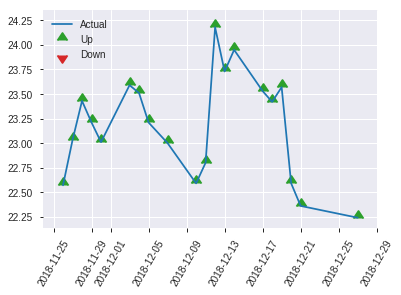


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.27437554820180043
RMSE: 0.5238086942785509
LogLoss: 0.7440450730785423
Null degrees of freedom: 246
Residual degrees of freedom: -242
Null deviance: 345.4517445763613
Residual deviance: 367.55826610079987
AIC: 1345.5582661007998
AUC: 0.46264443277310924
pr_auc: 0.4513337750639354
Gini: -0.07471113445378152
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5382418563599618: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      3    125  0.9766   (125.0/128.0)
1      1    118  0.0084   (1.0/119.0)
Total  4    243  0.5101   (126.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.538242     0.651934  242
max f2                       0.495957     0.82296   246
max f0point5                 0.538242     0.540788  242
max accuracy                 0.698779     0.51417   0
max precision                0.657244     0.490566  52
max recall                   0.495957     1         246
max specificity              0.698779     0.992188  0
max absolute_mcc             0.610993     0.115773  188
max min_per_class_accuracy   0.63146      0.484375  123
max mean_per_class_accuracy  0.538242     0.507517  242

Gains/Lift Table: Avg response rate: 48.18 %, avg score: 62.98 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0121457                   0.684657           0         0                  0                0.691497  0                           0.691497            0               0                          -100       -100
    2        0.0202429                   0.683589           2.07563   0.830252           1                0.683655  0.4                         0.688361            0.0168067       0.0168067                  107.563    -16.9748
    3        0.0323887                   0.677276           0.691877  0.778361           0.333333         0.679894  0.375                       0.685186            0.00840336      0.0252101                  -30.8123   -22.1639
    4        0.0404858                   0.674186           1.03782   0.830252           0.5              0.675396  0.4                         0.683228            0.00840336      0.0336134                  3.78151    -16.9748
    5        0.0526316                   0.67118            0         0.638655           0                0.6731    0.307692                    0.680891            0               0.0336134                  -100       -36.1345
    6        0.101215                    0.664686           1.03782   0.830252           0.5              0.667987  0.4                         0.674697            0.0504202       0.0840336                  3.78151    -16.9748
    7        0.149798                    0.661235           1.03782   0.89757            0.5              0.662943  0.432432                    0.670885            0.0504202       0.134454                   3.78151    -10.243
    8        0.202429                    0.657843           1.27731   0.996303           0.615385         0.659645  0.48                        0.667962            0.0672269       0.201681                   27.7311    -0.369748
    9        0.299595                    0.647822           1.03782   1.00977            0.5              0.653598  0.486486                    0.663304            0.10084         0.302521                   3.78151    0.976607
    10       0.40081                     0.639944           0.830252  0.964434           0.4              0.644606  0.464646                    0.658582            0.0840336       0.386555                   -16.9748   -3.55657
    11       0.502024                    0.63146            0.996303  0.970859           0.48             0.635408  0.467742                    0.65391             0.10084         0.487395                   -0.369748  -2.91407
    12       0.59919                     0.624305           0.778361  0.939643           0.375            0.62783   0.452703                    0.649681            0.0756303       0.563025                   -22.1639   -6.03566
    13       0.700405                    0.614432           1.07933   0.959829           0.52             0.618302  0.462428                    0.645146            0.109244        0.672269                   7.93277    -4.0171
    14       0.797571                    0.606893           0.951331  0.958794           0.458333         0.611706  0.461929                    0.641072            0.092437        0.764706                   -4.86695   -4.12063
    15       0.898785                    0.594914           1.16235   0.981717           0.56             0.601884  0.472973                    0.636659            0.117647        0.882353                   16.2353    -1.8283
    16       1                           0.495957           1.16235   1                  0.56             0.569287  0.481781           

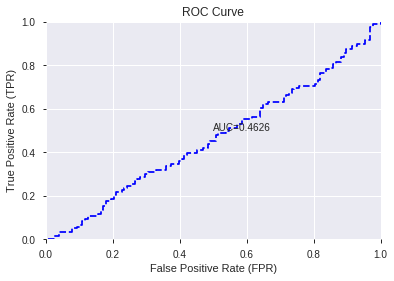

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


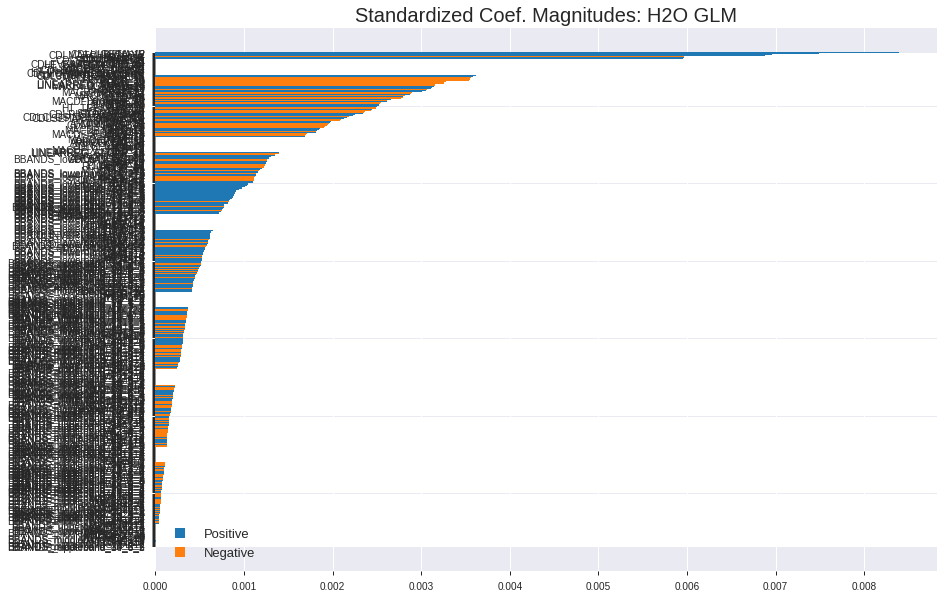

'log_likelihood'
--2019-08-26 15:06:46--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.236.219
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.236.219|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190826_150631_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190826_150631_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_106_sid_97b9',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_106

['BETA_12',
 'CDLHIGHWAVE',
 'CDLMATCHINGLOW',
 'BETA_8',
 'aroondown_24',
 'CDLHAMMER',
 'CDLONNECK',
 'CDLSPINNINGTOP',
 'BETA_14',
 'MFI_30',
 'AROONOSC_24',
 'CDLEVENINGDOJISTAR',
 'HT_PHASOR_inphase',
 'CDLHIKKAKE',
 'MACDFIX_hist_24',
 'MACDFIX_hist_20',
 'CDLSTICKSANDWICH',
 'BOP',
 'HT_PHASOR_quadrature',
 'CDLMORNINGDOJISTAR',
 'AROONOSC_20',
 'CDLCOUNTERATTACK',
 'CDL3WHITESOLDIERS',
 'MACDFIX_hist_14',
 'ROCR100_30',
 'ROCR_30',
 'ROCP_30',
 'ROC_30',
 'STDDEV_14',
 'LINEARREG_SLOPE_8',
 'LINEARREG_ANGLE_8',
 'CORREL_14',
 'MACDFIX_signal_24',
 'NATR_30',
 'APO',
 'MACDEXT',
 'ADOSC',
 'MACDFIX_hist_12',
 'CORREL_12',
 'TRANGE',
 'STOCH_slowd',
 'MACDEXT_hist',
 'DX_8',
 'NATR_24',
 'CMO_30',
 'DX_30',
 'aroonup_24',
 'MACDFIX_signal_20',
 'aroonup_12',
 'PLUS_DI_30',
 'ULTOSC',
 'NATR_20',
 'ADXR_8',
 'HT_TRENDMODE',
 'MFI_24',
 'DX_24',
 'CCI_30',
 'CDLTAKURI',
 'STOCHF_fastd',
 'STOCH_slowk',
 'CDLRICKSHAWMAN',
 'ADXR_12',
 'ADX_12',
 'CDLCLOSINGMARUBOZU',
 'CDLSEPARATING

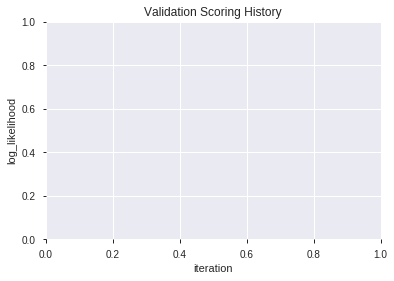

In [52]:
# GLM with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190826_150658_model_7  0.567489  0.692301              0.496094  0.499212  0.249213
1  XGBoost_grid_1_AutoML_20190826_150658_model_4  0.547728  0.694328              0.488281  0.500515  0.250515
2               XGBoost_1_AutoML_20190826_150658  0.538537  0.700395              0.476562  0.503359  0.253371
3  XGBoost_grid_1_AutoML_20190826_150658_model_5  0.535714  0.711169              0.500000  0.507559  0.257617
4  XGBoost_grid_1_AutoML_20190826_150658_model_3  0.525998  0.700991              0.500000  0.503672  0.253686
5  XGBoost_grid_1_AutoML_20190826_150658_model_1  0.519663  0.705672              0.496094  0.506051  0.256088
6  XGBoost_grid_1_AutoML_20190826_150658_model_2  0.513918  0.695817              0.484670  0.501326  0.251328
7               XGBoost_2_AutoML_20190826_150658  0.513459  0.706950              0.496094  0.506712  0.256757
8  XGBoost_grid_1_AutoML_20190826_150658_model_6  0.508863  0.703998              0.474133  0.505188  0.255215
9               XGBoost_3_AutoML_20190826_150658  0.496127  0.706707              0.496094  0.506612  0.256656

variable  relative_importance  scaled_importance  percentage
0                         BOP           226.061691           1.000000    0.024682
1                      BETA_8           143.789062           0.636061    0.015699
2                   STDDEV_12           132.921173           0.587986    0.014513
3                   CORREL_14           128.993118           0.570610    0.014084
4                       ADOSC           127.918419           0.565856    0.013967
..                        ...                  ...                ...         ...
277   BBANDS_lowerband_12_7_4             2.910687           0.012876    0.000318
278   BBANDS_upperband_12_6_3             2.895950           0.012810    0.000316
279   BBANDS_lowerband_20_3_3             2.080362           0.009203    0.000227
280   BBANDS_lowerband_20_2_4             1.872694           0.008284    0.000204
281  BBANDS_middleband_12_4_2             0.860794           0.003808    0.000094

[282 rows x 4 columns]

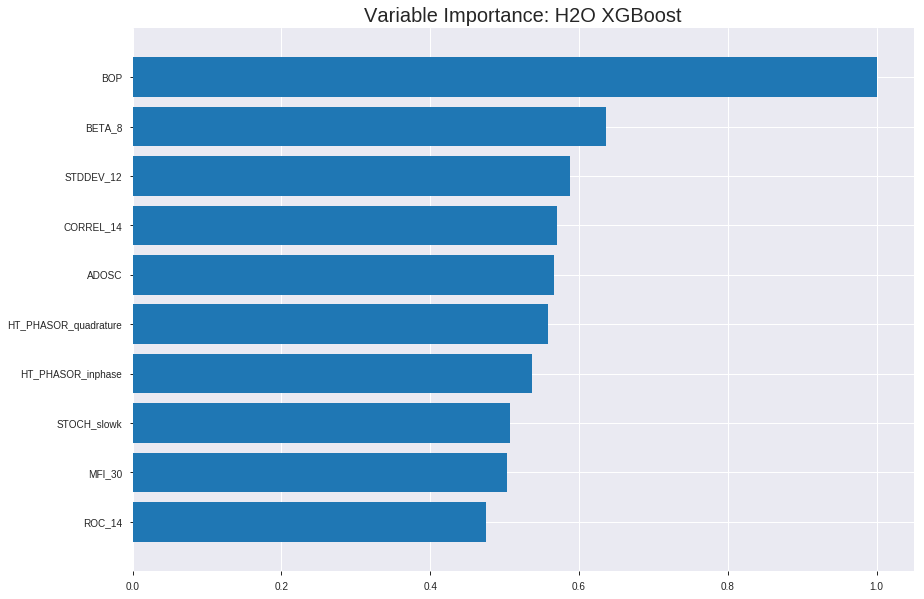

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190826_150658_model_7


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.13668562756439512
RMSE: 0.3697101940228253
LogLoss: 0.4545752847892248
Mean Per-Class Error: 0.06817367220593029
AUC: 0.9843610839578582
pr_auc: 0.9842153030887353
Gini: 0.9687221679157163
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5014892816543579: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      697  95    0.1199   (95.0/792.0)
1      24   906   0.0258   (24.0/930.0)
Total  721  1001  0.0691   (119.0/1722.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.501489     0.938374  220
max f2                       0.492689     0.962228  225
max f0point5                 0.561258     0.94883   186
max accuracy                 0.533588     0.932636  203
max precision                0.86409      1         0
max recall                   0.406416     1         275
max specificity              0.86409      1         0
max absolute_mcc             0.533588     0.864338  203
max min_per_class_accuracy   0.536416     0.92803   201
max mean_per_class_accuracy  0.533588     0.931826  203

Gains/Lift Table: Avg response rate: 54.01 %, avg score: 53.70 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010453                    0.825034           1.85161    1.85161            1                0.841943  1                           0.841943            0.0193548       0.0193548                  85.1613   85.1613
    2        0.0203252                   0.796753           1.85161    1.85161            1                0.811141  1                           0.826982            0.0182796       0.0376344                  85.1613   85.1613
    3        0.0301974                   0.786817           1.85161    1.85161            1                0.790289  1                           0.814986            0.0182796       0.055914                   85.1613   85.1613
    4        0.0400697                   0.779549           1.85161    1.85161            1                0.782907  1                           0.807083            0.0182796       0.0741935                  85.1613   85.1613
    5        0.0505226                   0.770249           1.85161    1.85161            1                0.775183  1                           0.800483            0.0193548       0.0935484                  85.1613   85.1613
    6        0.100465                    0.73878            1.85161    1.85161            1                0.752898  1                           0.776828            0.0924731       0.186022                   85.1613   85.1613
    7        0.150407                    0.715973           1.85161    1.85161            1                0.727787  1                           0.760544            0.0924731       0.278495                   85.1613   85.1613
    8        0.200348                    0.69977            1.83008    1.84625            0.988372         0.707763  0.997101                    0.747387            0.0913978       0.369892                   83.0083   84.6246
    9        0.300232                    0.657367           1.85161    1.84803            1                0.677638  0.998066                    0.724182            0.184946        0.554839                   85.1613   84.8031
    10       0.400116                    0.617631           1.80855    1.83818            0.976744         0.637558  0.992743                    0.702558            0.180645        0.735484                   80.8552   83.8176
    11       0.5                         0.559163           1.55019    1.78065            0.837209         0.588902  0.961672                    0.679853            0.154839        0.890323                   55.0188   78.0645
    12       0.599884                    0.487653           0.925806   1.63831            0.5              0.525392  0.884802                    0.654134            0.0924731       0.982796                   -7.41935  63.831
    13       0.699768                    0.414684           0.161478   1.42751            0.0872093        0.448516  0.770954                    0.624785            0.016129        0.998925                   -83.8522  42.7509
    14       0.799652                    0.364628           0.0107652  1.25054            0.00581395       0.388713  0.675381                    0.595297            0.00107527      1                          -98.9235  25.0545
    15       0.899535                    0.311973           0          1.11168            0                0.339646  0.600387                    0.56691             0               1                          -100      11.1685
    16       1                           0.148663           0          1                  0                0.269132  0.54007                     



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2628923911564764
RMSE: 0.5127303298581783
LogLoss: 0.7204726291007914
Mean Per-Class Error: 0.4888434549952042
AUC: 0.47224325643226145
pr_auc: 0.5495281298586202
Gini: -0.0555134871354771
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.21985211968421936: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    213  1        (213.0/213.0)
1      0    279  0        (0.0/279.0)
Total  0    492  0.4329   (213.0/492.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.219852     0.723735   399
max f2                       0.219852     0.867537   399
max f0point5                 0.219852     0.620828   399
max accuracy                 0.219852     0.567073   399
max precision                0.769442     1          0
max recall                   0.219852     1          399
max specificity              0.769442     1          0
max absolute_mcc             0.677166     0.0780174  22
max min_per_class_accuracy   0.518601     0.488263   202
max mean_per_class_accuracy  0.611076     0.511157   80

Gains/Lift Table: Avg response rate: 56.71 %, avg score: 51.58 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101626                   0.71647            1.05806   1.05806            0.6              0.735069  0.6                         0.735069            0.0107527       0.0107527                  5.80645   5.80645
    2        0.0203252                   0.699244           0.352688  0.705376           0.2              0.709714  0.4                         0.722392            0.00358423      0.0143369                  -64.7312  -29.4624
    3        0.0304878                   0.69134            1.05806   0.822939           0.6              0.694856  0.466667                    0.713213            0.0107527       0.0250896                  5.80645   -17.7061
    4        0.0406504                   0.6834             0.705376  0.793548           0.4              0.688723  0.45                        0.707091            0.00716846      0.0322581                  -29.4624  -20.6452
    5        0.050813                    0.676626           0.352688  0.705376           0.2              0.679031  0.4                         0.701479            0.00358423      0.0358423                  -64.7312  -29.4624
    6        0.101626                    0.646635           1.19914   0.952258           0.68             0.658345  0.54                        0.679912            0.0609319       0.0967742                  19.914    -4.77419
    7        0.150407                    0.626227           1.17563   1.0247             0.666667         0.636946  0.581081                    0.665977            0.0573477       0.154122                   17.5627   2.47021
    8        0.20122                     0.606593           1.05806   1.03313            0.6              0.616442  0.585859                    0.653468            0.0537634       0.207885                   5.80645   3.3127
    9        0.300813                    0.566763           0.827738  0.965126           0.469388         0.585062  0.547297                    0.63082             0.0824373       0.290323                   -17.2262  -3.48736
    10       0.400407                    0.539973           0.935703  0.957808           0.530612         0.552605  0.543147                    0.611366            0.09319         0.383513                   -6.42967  -4.2192
    11       0.5                         0.518176           1.07966   0.982079           0.612245         0.530657  0.556911                    0.59529             0.107527        0.491039                   7.96577   -1.79211
    12       0.599593                    0.490796           0.935703  0.974376           0.530612         0.504116  0.552542                    0.580145            0.09319         0.584229                   -6.42967  -2.56242
    13       0.699187                    0.468684           0.863726  0.958615           0.489796         0.480013  0.543605                    0.565882            0.0860215       0.670251                   -13.6274  -4.13853
    14       0.79878                     0.432724           1.11565   0.978194           0.632653         0.450917  0.554707                    0.551548            0.111111        0.781362                   11.5646   -2.18063
    15       0.898374                    0.384775           1.11565   0.993432           0.632653         0.409695  0.563348                    0.535823            0.111111        0.892473                   11.5646   -0.656838
    16       1                           0.219852           1.05806   1                  0.6              0.338711  0.567073                    0.5157


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-26 15:07:18  12.034 sec  0                  0.5              0.693147            0.5             0                  1                0.45993                          0.5                0.693147              0.5               0                    1                  0.432927
    2019-08-26 15:07:18  12.309 sec  5                  0.479881         0.653567            0.835364        0.851521           1.85161          0.252033                         0.499378           0.691903              0.505797          0.575715             1.46953            0.430894
    2019-08-26 15:07:18  12.417 sec  10                 0.463228         0.621663            0.888242        0.895469           1.65671          0.186992                         0.499726           0.69261               0.502398          0.565893             1.41075            0.432927
    2019-08-26 15:07:18  12.520 sec  15                 0.450114         0.596979            0.9133          0.920794           1.85161          0.167247                         0.501632           0.696486              0.486403          0.560908             1.05806            0.432927
    2019-08-26 15:07:18  12.629 sec  20                 0.436659         0.572124            0.935299        0.94085            1.85161          0.138792                         0.503111           0.699513              0.483248          0.563882             1.05806            0.432927
    2019-08-26 15:07:18  12.737 sec  25                 0.423581         0.548306            0.947315        0.951853           1.85161          0.121951                         0.505961           0.7054                0.472437          0.55909              0.705376           0.432927
    2019-08-26 15:07:19  12.840 sec  30                 0.412206         0.527949            0.95906         0.963175           1.85161          0.103949                         0.508184           0.71017               0.463644          0.55483              1.41075            0.432927
    2019-08-26 15:07:19  12.954 sec  35                 0.402005         0.509914            0.966553        0.96974            1.85161          0.0958188                        0.508713           0.711437              0.47141           0.560578             1.41075            0.432927
    2019-08-26 15:07:19  13.072 sec  40                 0.389084         0.487634            0.977554        0.97915            1.85161          0.0807201                        0.511236           0.716983              0.465327          0.55304              1.41075            0.432927
    2019-08-26 15:07:19  13.181 sec  45                 0.379358         0.471007            0.981536        0.982611           1.85161          0.0720093                        0.512016           0.718859              0.471267          0.548258             0.705376           0.432927
    2019-08-26 15:07:19  13.296 sec  50                 0.36971          0.454575            0.984361        0.984215           1.85161          0.0691057                        0.51273            0.720473              0.472243          0.549528             1.05806            0.432927

Variable Importances: 


variable                  relative_importance    scaled_importance      percentage
------------------------  ---------------------  ---------------------  ----------------------
BOP                       226.0616912841797      1.0                    0.024682287877740263
BETA_8                    143.7890625            0.6360611640264353     0.015699444758351045
STDDEV_12                 132.92117309570312     0.5879862808272516     0.014512846651540052
CORREL_14                 128.9931182861328      0.5706102504735178     0.014083966468176841
ADOSC                     127.91841888427734     0.5658562410889534     0.013966626639973546
---                       ---                    ---                    ---
BBANDS_lowerband_12_7_4   2.9106874465942383     0.012875633328493702   0.0003178000884221086
BBANDS_upperband_12_6_3   2.895949602127075      0.012810439423310376   0.00031619095368649967
BBANDS_lowerband_20_3_3   2.080362319946289      0.009202630963824331   0.0002271419866817185
BBANDS_lowerband_20_2_4   1.8726940155029297     0.008283995421182558   0.0002044679597635101
BBANDS_middleband_12_4_2  0.8607940673828125     0.0038077838951523974  9.398481827637461e-05


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5668016194331984)

('F1', 0.6520547945205479)

('auc', 0.5674894957983193)

('logloss', 0.6923005728305202)

('mean_per_class_error', 0.4330357142857143)

('rmse', 0.4992119428213864)

('mse', 0.24921256385550317)

xgboost prediction progress: |████████████████████████████████████████████| 100%


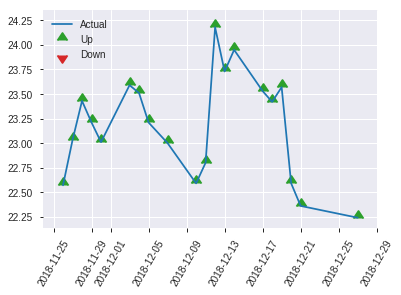


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.24921256385550317
RMSE: 0.4992119428213864
LogLoss: 0.6923005728305202
Mean Per-Class Error: 0.4330357142857143
AUC: 0.5674894957983193
pr_auc: 0.5216471643412931
Gini: 0.13497899159663862
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2741098701953888: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    127  0.9922   (127.0/128.0)
1      0    119  0        (0.0/119.0)
Total  1    246  0.5142   (127.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.27411      0.652055  245
max f2                       0.27411      0.8241    245
max f0point5                 0.471037     0.557823  153
max accuracy                 0.512939     0.566802  101
max precision                0.577592     0.604167  47
max recall                   0.27411      1         245
max specificity              0.745795     0.992188  0
max absolute_mcc             0.494655     0.133841  123
max min_per_class_accuracy   0.497362     0.563025  121
max mean_per_class_accuracy  0.494655     0.566964  123

Gains/Lift Table: Avg response rate: 48.18 %, avg score: 49.81 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0121457                   0.719889           0.691877  0.691877           0.333333         0.73741   0.333333                    0.73741             0.00840336      0.00840336                 -30.8123  -30.8123
    2        0.0202429                   0.69764            1.03782   0.830252           0.5              0.712577  0.4                         0.727477            0.00840336      0.0168067                  3.78151   -16.9748
    3        0.0323887                   0.684571           0.691877  0.778361           0.333333         0.690946  0.375                       0.713778            0.00840336      0.0252101                  -30.8123  -22.1639
    4        0.0404858                   0.670116           1.03782   0.830252           0.5              0.676945  0.4                         0.706411            0.00840336      0.0336134                  3.78151   -16.9748
    5        0.0526316                   0.664177           1.38375   0.957983           0.666667         0.667005  0.461538                    0.697318            0.0168067       0.0504202                  38.3754   -4.20168
    6        0.101215                    0.62174            1.21078   1.07933            0.583333         0.64477   0.52                        0.672095            0.0588235       0.109244                   21.0784   7.93277
    7        0.149798                    0.594773           1.38375   1.17806            0.666667         0.605241  0.567568                    0.650413            0.0672269       0.176471                   38.3754   17.806
    8        0.202429                    0.575733           1.27731   1.20387            0.615385         0.585901  0.58                        0.633639            0.0672269       0.243697                   27.7311   20.3866
    9        0.299595                    0.548678           1.03782   1.15001            0.5              0.562885  0.554054                    0.610692            0.10084         0.344538                   3.78151   15.0011
    10       0.40081                     0.51789            1.07933   1.13216            0.52             0.532883  0.545455                    0.591043            0.109244        0.453782                   7.93277   13.2162
    11       0.502024                    0.494655           1.16235   1.13825            0.56             0.504775  0.548387                    0.57365             0.117647        0.571429                   16.2353   13.8249
    12       0.59919                     0.4756             0.864846  1.09391            0.416667         0.484222  0.527027                    0.559149            0.0840336       0.655462                   -13.5154  9.39132
    13       0.700405                    0.448827           0.747227  1.04381            0.36             0.463383  0.50289                     0.54531             0.0756303       0.731092                   -25.2773  4.38141
    14       0.797571                    0.41749            1.1243    1.05362            0.541667         0.434755  0.507614                    0.531841            0.109244        0.840336                   12.43     5.36194
    15       0.898785                    0.369826           0.747227  1.01912            0.36             0.397993  0.490991                    0.516768            0.0756303       0.915966                   -25.2773  1.91158
    16       1                           0.267247           0.830252  1                  0.4              0.332564  0.481781                    0.498124     

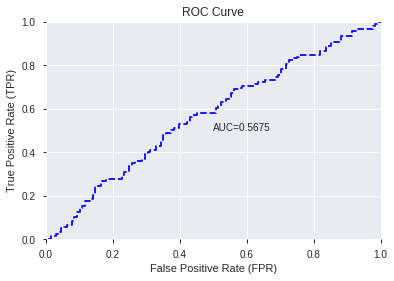

This function is available for GLM models only


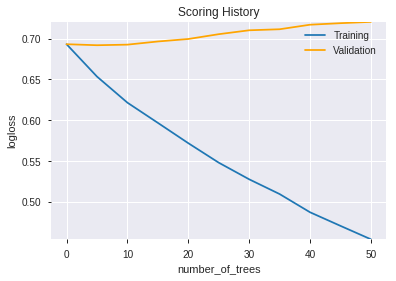

--2019-08-26 15:07:25--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.32.252
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.32.252|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.calculateChildInclusiveNa(SharedTreeNode.java:133)
	at hex.genmodel.algos.tree.SharedTreeNode.setRightChild(SharedTreeNode.java:220)
	at hex.genmodel.algos.tree.SharedTreeSubgraph.makeRightEdge(SharedTreeSubgraph.java:86)
	at hex.genmodel.algos.tree.SharedTreeSubgraph.makeRightChildNode(SharedTreeSubgraph.java:77)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.con

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190826_150658_model_7',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190826_150658_model_7',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_114_sid_97b9',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_trainin

['BOP',
 'BETA_8',
 'STDDEV_12',
 'CORREL_14',
 'ADOSC',
 'HT_PHASOR_quadrature',
 'HT_PHASOR_inphase',
 'STOCH_slowk',
 'MFI_30',
 'ROC_14',
 'CORREL_8',
 'ULTOSC',
 'MFI_14',
 'BETA_12',
 'MFI_8',
 'DX_30',
 'AD',
 'STDDEV_8',
 'CCI_8',
 'CORREL_12',
 'ADX_24',
 'ATR_8',
 'MOM_24',
 'AROONOSC_24',
 'BETA_14',
 'MACDFIX_hist_24',
 'MINUS_DM_14',
 'PLUS_DM_8',
 'MACDEXT',
 'STDDEV_14',
 'DX_24',
 'BETA_20',
 'PLUS_DI_20',
 'DX_20',
 'HT_DCPERIOD',
 'ROC_8',
 'NATR_8',
 'STOCHRSI_fastk',
 'CCI_20',
 'MACDEXT_hist',
 'MFI_24',
 'ADXR_8',
 'STOCHF_fastd',
 'ADXR_12',
 'TRIX_8',
 'MINUS_DI_30',
 'DX_8',
 'WILLR_8',
 'MOM_14',
 'ROC_12',
 'LINEARREG_ANGLE_8',
 'aroondown_24',
 'NATR_12',
 'STOCHRSI_fastd',
 'MFI_20',
 'MFI_12',
 'ROC_30',
 'ATR_24',
 'LINEARREG_ANGLE_12',
 'MACDFIX_signal_24',
 'CMO_8',
 'aroondown_8',
 'MACDFIX_hist_8',
 'LINEARREG_ANGLE_14',
 'ADX_20',
 'PLUS_DM_30',
 'STOCH_slowd',
 'WILLR_24',
 'MINUS_DI_14',
 'APO',
 'MINUS_DM_24',
 'MACDFIX_hist_20',
 'MINUS_DM_12',
 

In [53]:
# XGBoost with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="XGBoost",features_list=features_list)

In [54]:
# Experiment Summary
pd.set_option('precision', 3) 

for k in models_summary:
  print(k)
  display(models_summary[k].max())
  print('\n'*3)
  display(models_summary[k].groupby(models_summary[k].index).max())
  print('\n'*3)
  
display(models_summary)

pd.set_option('precision', 6) 

accuracy


DeepLearning    0.595
GLM             0.547
XGBoost         0.595
dtype: float64

DeepLearning    GLM  XGBoost
All          0.482  0.547    0.595
DLF          0.595  0.522    0.563
Fwe          0.526  0.547    0.595
RFE          0.571  0.514    0.567
XGBF         0.595  0.522    0.563





F1


DeepLearning    0.652
GLM             0.652
XGBoost         0.654
dtype: float64

DeepLearning    GLM  XGBoost
All          0.650  0.650    0.654
DLF          0.650  0.650    0.652
Fwe          0.650  0.650    0.654
RFE          0.652  0.652    0.652
XGBF         0.650  0.650    0.652





auc


DeepLearning    0.574
GLM             0.490
XGBoost         0.571
dtype: float64

DeepLearning    GLM  XGBoost
All          0.500  0.490    0.571
DLF          0.574  0.470    0.537
Fwe          0.509  0.490    0.571
RFE          0.530  0.463    0.567
XGBF         0.567  0.470    0.537





logloss


DeepLearning    17.899
GLM             14.280
XGBoost          0.704
dtype: float64

DeepLearning     GLM  XGBoost
All         17.899  14.280    0.692
DLF          0.777   0.722    0.704
Fwe         16.640  14.280    0.692
RFE          1.640   0.744    0.692
XGBF         0.985   0.722    0.704





mean_per_class_error


DeepLearning    0.500
GLM             0.492
XGBoost         0.446
dtype: float64

DeepLearning    GLM  XGBoost
All          0.500  0.470    0.408
DLF          0.407  0.489    0.446
Fwe          0.491  0.470    0.408
RFE          0.443  0.492    0.433
XGBF         0.407  0.489    0.446





rmse


DeepLearning    0.720
GLM             0.694
XGBoost         0.505
dtype: float64

DeepLearning    GLM  XGBoost
All          0.720  0.694    0.500
DLF          0.524  0.514    0.505
Fwe          0.694  0.694    0.500
RFE          0.644  0.524    0.499
XGBF         0.580  0.514    0.505





mse


DeepLearning    0.518
GLM             0.482
XGBoost         0.255
dtype: float64

DeepLearning    GLM  XGBoost
All          0.518  0.482    0.250
DLF          0.275  0.264    0.255
Fwe          0.482  0.482    0.250
RFE          0.415  0.274    0.249
XGBF         0.336  0.264    0.255

{'F1':       DeepLearning    GLM  XGBoost
 All          0.650    NaN      NaN
 DLF          0.650    NaN      NaN
 DLF            NaN  0.650      NaN
 DLF            NaN    NaN    0.652
 All            NaN  0.650      NaN
 All            NaN    NaN    0.654
 XGBF         0.650    NaN      NaN
 XGBF           NaN  0.650      NaN
 XGBF           NaN    NaN    0.652
 Fwe          0.650    NaN      NaN
 Fwe            NaN  0.650      NaN
 Fwe            NaN    NaN    0.654
 RFE          0.652    NaN      NaN
 RFE            NaN  0.652      NaN
 RFE            NaN    NaN    0.652,
 'accuracy':       DeepLearning    GLM  XGBoost
 All          0.482    NaN      NaN
 DLF          0.595    NaN      NaN
 DLF            NaN  0.522      NaN
 DLF            NaN    NaN    0.563
 All            NaN  0.547      NaN
 All            NaN    NaN    0.595
 XGBF         0.595    NaN      NaN
 XGBF           NaN  0.522      NaN
 XGBF           NaN    NaN    0.563
 Fwe          0.526    NaN      NaN
 Fwe     